# Earthquake Data Analysis

The project consists of analyzing a dataset (called also "catalog") of earthquakes collected in about 20 years of recording in South California.

The catalog includes the magnitude, time of occurrence (s), and 3D coordinates (m) of earthquakes. Coordinates were converted from latitude, longitude, and depth of events in a seismic catalog. Magnitudes should be within the range $[0,8]$.

* __Waiting time (t)__: time interval between an event and the next one in the sequence.
* __Distance (r)__: Euclidean 3D distance between events (each 3D set of coordinates refers to the hypocenter, i.e. the point triggering the slip in a fault that forms the earthquake).

## Data

The catalog `SouthCalifornia-1982-2011.dat` is a data file with the following content:

* column 1: index of the event
* column 2: index of the previous event that triggered it (defined with a given algorithm), -1 if no ancestor is found
* column 3: time (seconds) from 0:00 of Jan.1st, 1982
* column 4: magnitude
* columns 5, 6, and 7: 3D coordinates (in meters) of the earthquake hypocenter, i.e. of the point from where it started. These Euclidean coordinates are derived from latitude, longitude and depth.

By joining each event to that with the index of the second column (if not -1), a set of causal trees would emerge.


## Assignments

1. Visualize the process in space and/or time with a suitable time series and/or 3D visualizations of the hypocenters. For instance, plot a space variable (a single coordinate or an appropriate linear combination of coordinates) as a function of time.
2. Compute the distribution $P_m(t)$ of waiting times for events of magnitude $m$ or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$. If deemed appropriate, choose a function and fit it to the data.
3. Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude $m$ or above. Make a clever choice for the bin sizes, and try several values of $m$. Fit the data with an appropriate function, if possible.
4. Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$, for different values of m and $R$. In this case, if the following event is farther than $R$, skip the $t$ and go to the next pair.
5. Comment whether there is a scaling law from the analysis of the previous points. Is there a suitable rescaling that collapses distributions for various $m$ (and eventually $R$ if point 4 is considered) on a single curve?

#0) Data:
We approached the data exploration following the popular model of OSEMN (Obtaining, Scrubbing, Exploring, Modelling, iNterpreting data).


In [66]:
from google.colab import drive
drive.mount('/content/gdrive')

#import of necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from ctypes import c_ulong
import datetime as dt
import math


columns = ['Event', 'Prev event', 'Time [s]', 'Magnitude', 'x [m]', 'y [m]', 'z [m]']
df = pd.read_csv('/content/gdrive/MyDrive/SouthCalifornia-1982-2011.dat', sep=" ", header=None)
df.columns = columns
dfc = df.copy()
df

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Event  Prev event      Time [s]  Magnitude    x [m]    y [m]    z [m]
0            0          -1  0.000000e+00       2.71 -2571956 -4627162  3520602
1            1           0  3.650139e+04       2.12 -2363740 -4787011  3461373
2            2           0  3.748828e+04       2.33 -2363746 -4786942  3461232
3            3           0  4.798252e+04       2.57 -2475085 -4664024  3548479
4            4           0  6.026857e+04       2.98 -2238642 -4839098  3469546
...        ...         ...           ...        ...      ...      ...      ...
110266  110266          -1  9.304996e+08       2.60 -2668492 -4335735  3810743
110267  110267          -1  9.305115e+08       2.02 -2297480 -4823870  3445285
110268  110268          -1  9.305318e+08       2.00 -2404797 -4441247  3868121
110269  110269          -1  9.305363e+08       2.17 -2388375 -4691191  3550903
110270  110270          -1  9.305667e+08       3.27 -2579453 -4409462  3774036

[110271 rows x 7 columns]

In [67]:
#Giving a general description of the dataset
df_describe = df.describe()
df_describe

Event     Prev event      Time [s]      Magnitude  \
count  110271.000000  110271.000000  1.102710e+05  110271.000000   
mean    55135.000000   35859.277625  4.262426e+08       2.457920   
std     31832.640104   36365.001297  2.598605e+08       0.438374   
min         0.000000      -1.000000  0.000000e+00       2.000000   
25%     27567.500000      -1.000000  2.115783e+08       2.140000   
50%     55135.000000   28462.000000  3.551023e+08       2.340000   
75%     82702.500000   66972.000000  5.952398e+08       2.640000   
max    110270.000000  110250.000000  9.305667e+08       7.300000   

              x [m]         y [m]         z [m]  
count  1.102710e+05  1.102710e+05  1.102710e+05  
mean  -2.388225e+06 -4.691072e+06  3.562612e+06  
std    8.878019e+04  1.237294e+05  1.271897e+05  
min   -2.770239e+06 -5.020849e+06  3.186133e+06  
25%   -2.421620e+06 -4.801152e+06  3.458838e+06  
50%   -2.361829e+06 -4.699729e+06  3.564367e+06  
75%   -2.329898e+06 -4.615062e+06  3.634552e+06  
max   -1.998294e+06 -4.268289e+06  3.876120e+06

In [68]:
#Converting the time tag into date starting from first of January of 1982
df['Elapsed time'] = (pd.to_datetime(df.loc[:,'Time [s]'], unit='s', origin=pd.Timestamp('1982-01-01')))
df

Event  Prev event      Time [s]  Magnitude    x [m]    y [m]  \
0            0          -1  0.000000e+00       2.71 -2571956 -4627162   
1            1           0  3.650139e+04       2.12 -2363740 -4787011   
2            2           0  3.748828e+04       2.33 -2363746 -4786942   
3            3           0  4.798252e+04       2.57 -2475085 -4664024   
4            4           0  6.026857e+04       2.98 -2238642 -4839098   
...        ...         ...           ...        ...      ...      ...   
110266  110266          -1  9.304996e+08       2.60 -2668492 -4335735   
110267  110267          -1  9.305115e+08       2.02 -2297480 -4823870   
110268  110268          -1  9.305318e+08       2.00 -2404797 -4441247   
110269  110269          -1  9.305363e+08       2.17 -2388375 -4691191   
110270  110270          -1  9.305667e+08       3.27 -2579453 -4409462   

          z [m]                  Elapsed time  
0       3520602 1982-01-01 00:00:00.000000000  
1       3461373 1982-01-01 10:08:21.390720000  
2       3461232 1982-01-01 10:24:48.277440000  
3       3548479 1982-01-01 13:19:42.516480000  
4       3469546 1982-01-01 16:44:28.570560000  
...         ...                           ...  
110266  3810743 2011-06-27 16:06:08.170560000  
110267  3445285 2011-06-27 19:25:04.728000256  
110268  3868121 2011-06-28 01:03:15.733440000  
110269  3550903 2011-06-28 02:17:48.600960000  
110270  3774036 2011-06-28 10:45:35.962560256  

[110271 rows x 8 columns]

#1) Visualization
Trying to find appropriate data visualization in order to observe meaningful correlations among the events.

## 1.1) Magnitude vs Number of earthquakes
From the figure one can understand that the lower magnitude events are the most likely to occur.

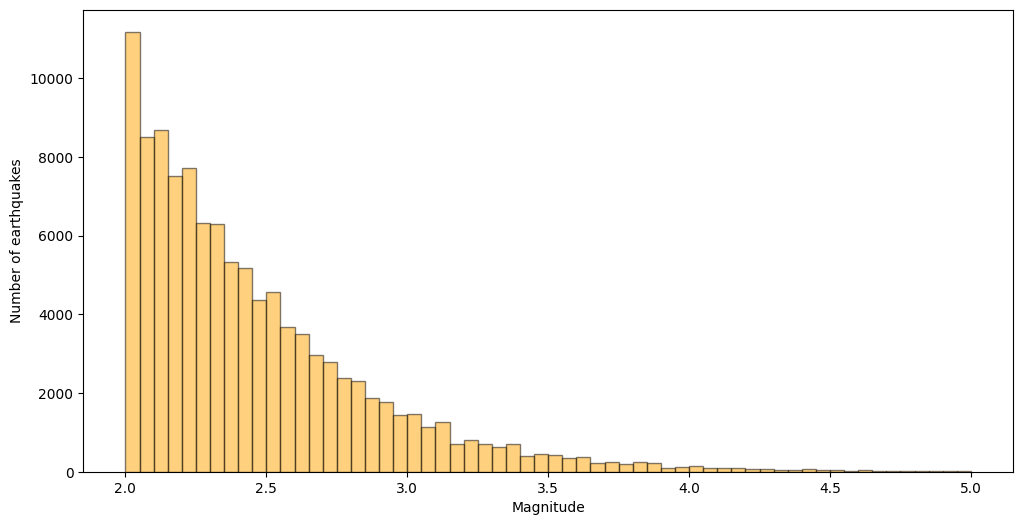

In [93]:
plt.figure(figsize=(12,6))
plt.hist(df['Magnitude'], bins=60, edgecolor='k', color='orange', alpha=0.5, range=(2, 5))
plt.xlabel('Magnitude')
plt.ylabel('Number of earthquakes')

plt.show()

##1.2) Earthquakes with dangereous magnitude
Here we plotted the earthquakes with magnitude higher than 5, since those are the ones that may begin to cause damages to the structures, distributed along the time of the dataset provided. The highest ones which are above 6.5 start causing serious damages to populated areas according to Richter scale.

<ipython-input-70-fd8fac5c4f27>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax0.plot(mod_df['Elapsed time'], mod_df['Magnitude'], 'bo', markersize=10, alpha=0.5, color='red')
<ipython-input-70-fd8fac5c4f27>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax0.plot(mod_df['Elapsed time'], mod_df['Magnitude'], 'bo', markersize=15, color='red')


Text(0, 0.5, 'Magnitude')

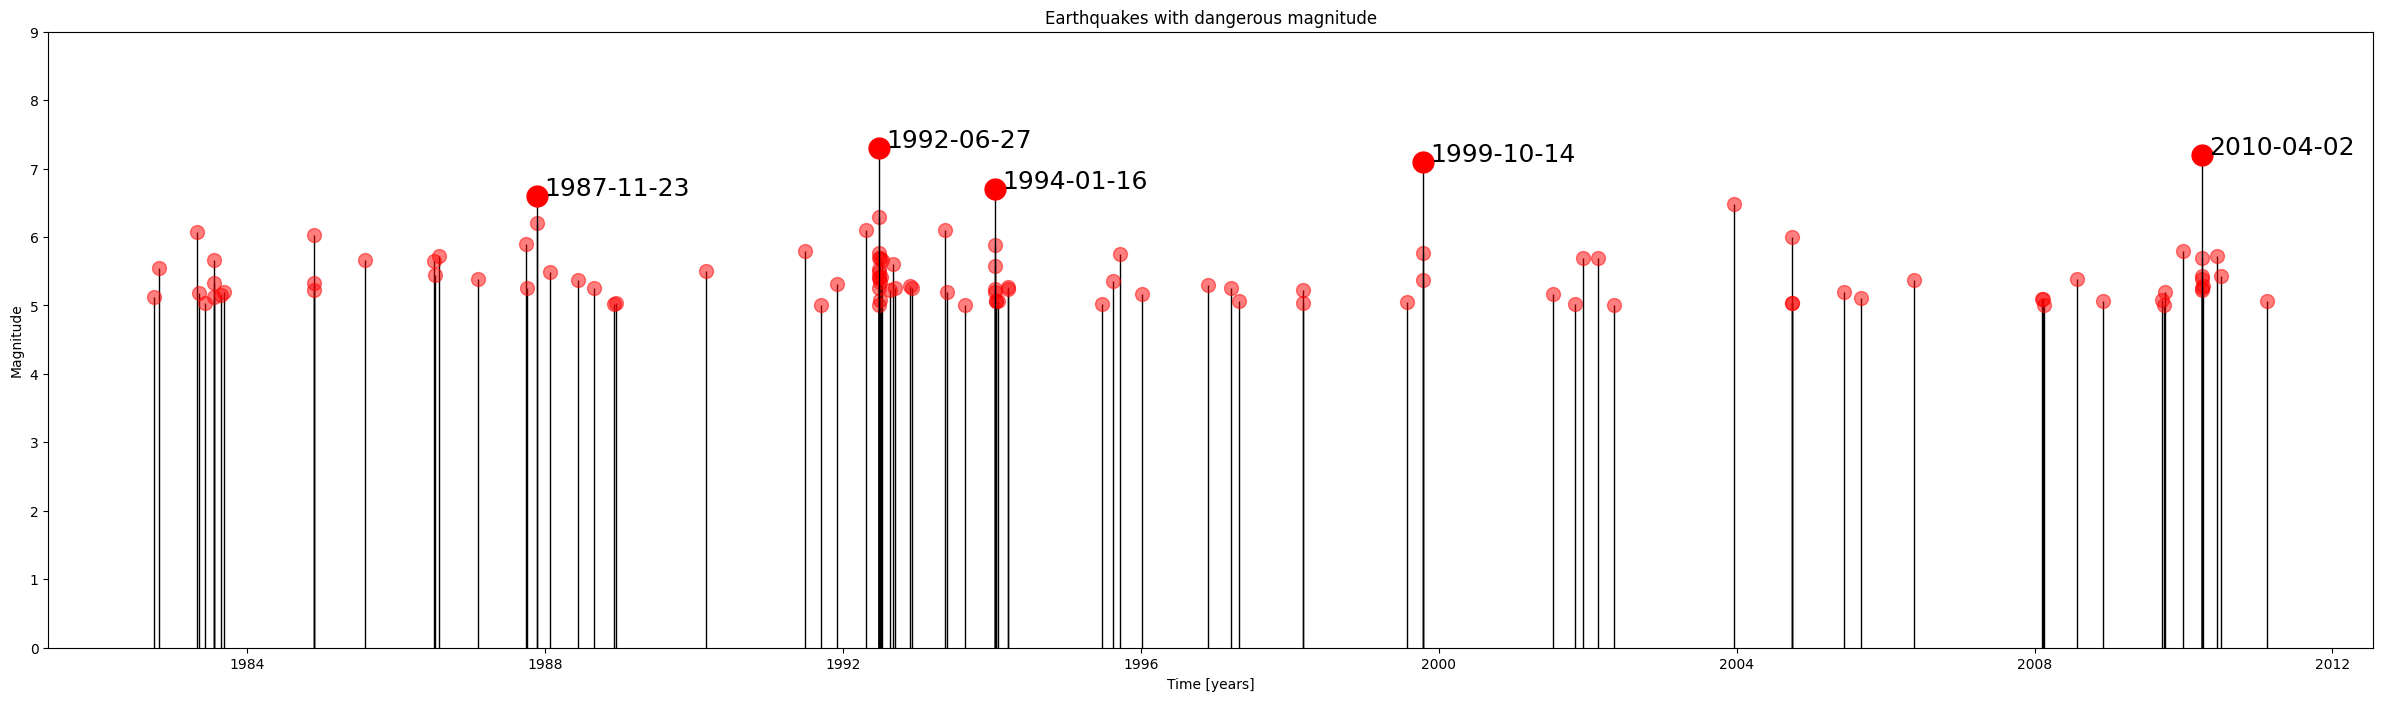

In [70]:
fig0, ax0 = plt.subplots(figsize=(30, 8))

mod_df = df.copy()
mod_df = mod_df[(mod_df['Magnitude']>=5) & (mod_df['Magnitude']<=6.5)]

ax0.vlines(mod_df['Elapsed time'], 0, mod_df['Magnitude'], colors='k', linestyle='-', lw=1)
ax0.plot(mod_df['Elapsed time'], mod_df['Magnitude'], 'bo', markersize=10, alpha=0.5, color='red')

ax0.set_ylim(0, 9)

mod_df = df.copy()
mod_df = mod_df[mod_df['Magnitude']>6.5]
ax0.vlines(mod_df['Elapsed time'], 0, mod_df['Magnitude'], colors='k', linestyle='-', lw=1)
ax0.plot(mod_df['Elapsed time'], mod_df['Magnitude'], 'bo', markersize=15, color='red')
mod_df['date'] = mod_df['Elapsed time'].dt.strftime('%Y-%m-%d')
for i, (x_value, y_value) in enumerate(zip(mod_df['Elapsed time'], mod_df['Magnitude'])):
   plt.annotate(mod_df['date'].iloc[i], xy=(x_value,  y_value), xytext=(5,  0.6), textcoords='offset points', fontsize=18)

ax0.set_title('Earthquakes with dangerous magnitude')
ax0.set_xlabel('Time [years]')
ax0.set_ylabel('Magnitude')

## 1.3) 3D spatial distribution
Here a spatial distribution of earthquakes along the three different axis is visualized. The colors of the events help visualize the intensity of the earthquakes. Such visualization is coadjuvant for the identification of the higher seismic areas of South-California.

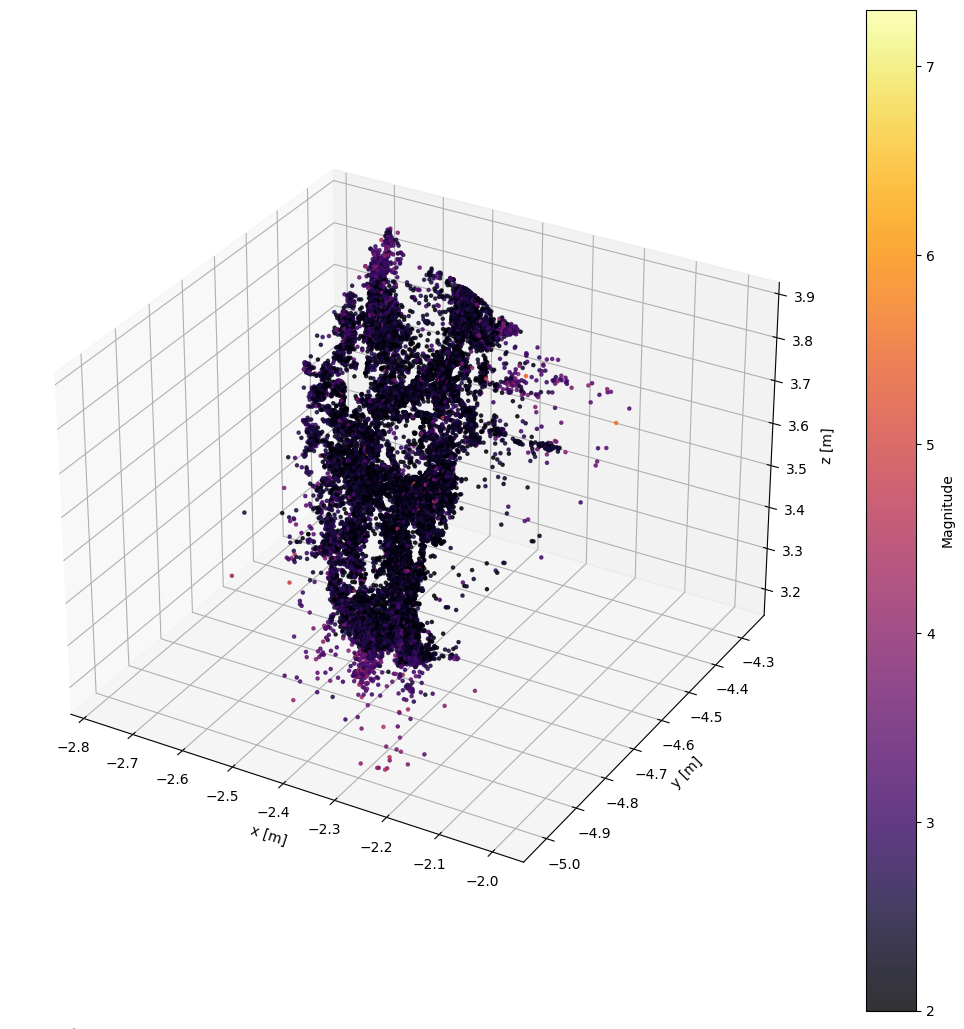

In [71]:
fig1 = plt.figure(figsize=(13,13))
ax1 = fig1.add_subplot(1, 1, 1, projection='3d')
p2 = ax1.scatter(df['x [m]'], df['y [m]'], df['z [m]'], c=df['Magnitude'], cmap='inferno', marker='.', alpha=0.8)
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.set_zlabel('z [m]')
col_bar = fig1.colorbar(p2)
col_bar.set_label('Magnitude')

## 1.4) 2D spatial distribution
With the support of `seaborn` a two dimensional visualization of the distribution is provided.

One can observe form the `jointplots` how the different coordinates of the hypocenters vary in function of the time. For what concerns the x coordinate, its mean shifted towards east as the time increased. For the y coordinate, its mean shifted towards south and finally for the altitude, i.e. the z coordiante, tended to lower as the time increased.


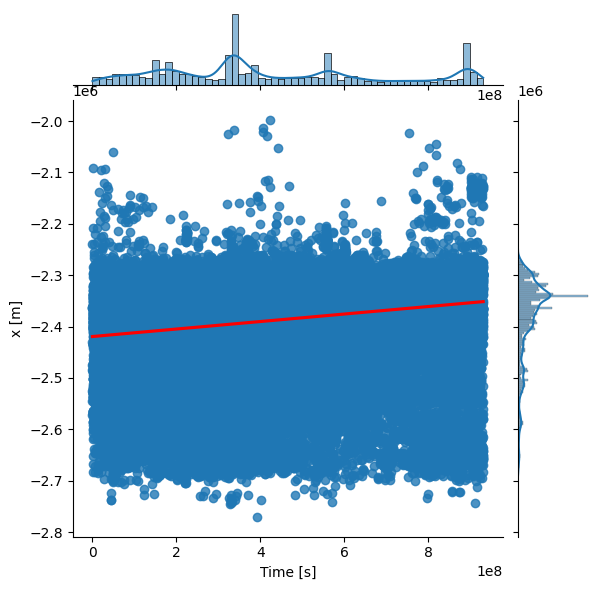

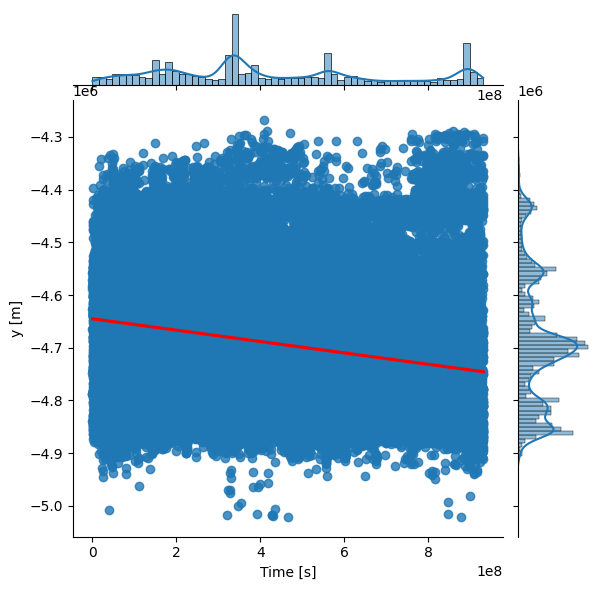

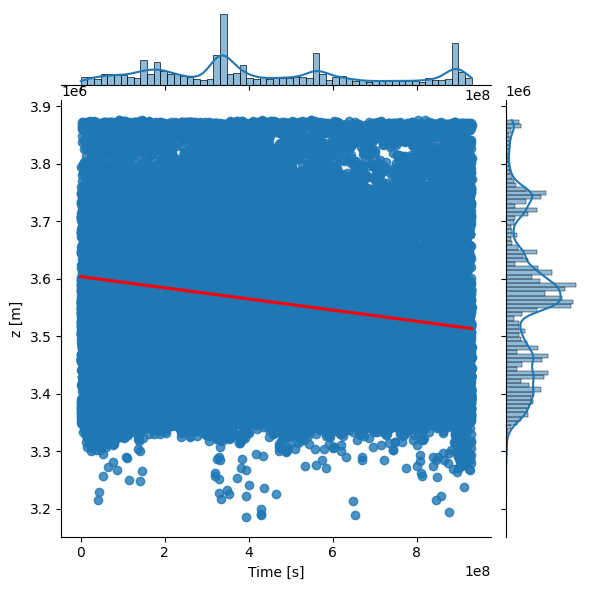

In [72]:
sns.jointplot(data=df, x='Time [s]', y='x [m]', kind='reg', joint_kws={'line_kws':{'color':'r'}})
sns.jointplot(data=df, x='Time [s]', y='y [m]', kind='reg', joint_kws={'line_kws':{'color':'r'}})
sns.jointplot(data=df, x='Time [s]', y='z [m]', kind='reg', joint_kws={'line_kws':{'color':'r'}})
plt.show()

# 2) Distribution $P_m(t)$ of the waiting times #

For what concernes the number of bins, assuming the waiting times to be random, i.e. $P_m(t) \approx Poisson$, the number of bins can be chosen to be $\sqrt n$.

## 2.1) Computing of waiting times
In this sectionthe distribution of waiting times is computed for different values of magnitude **m**= 2, 3, 4, 5 for events of magnitude m and above.

Text(0.5, 0, 'Waiting time')

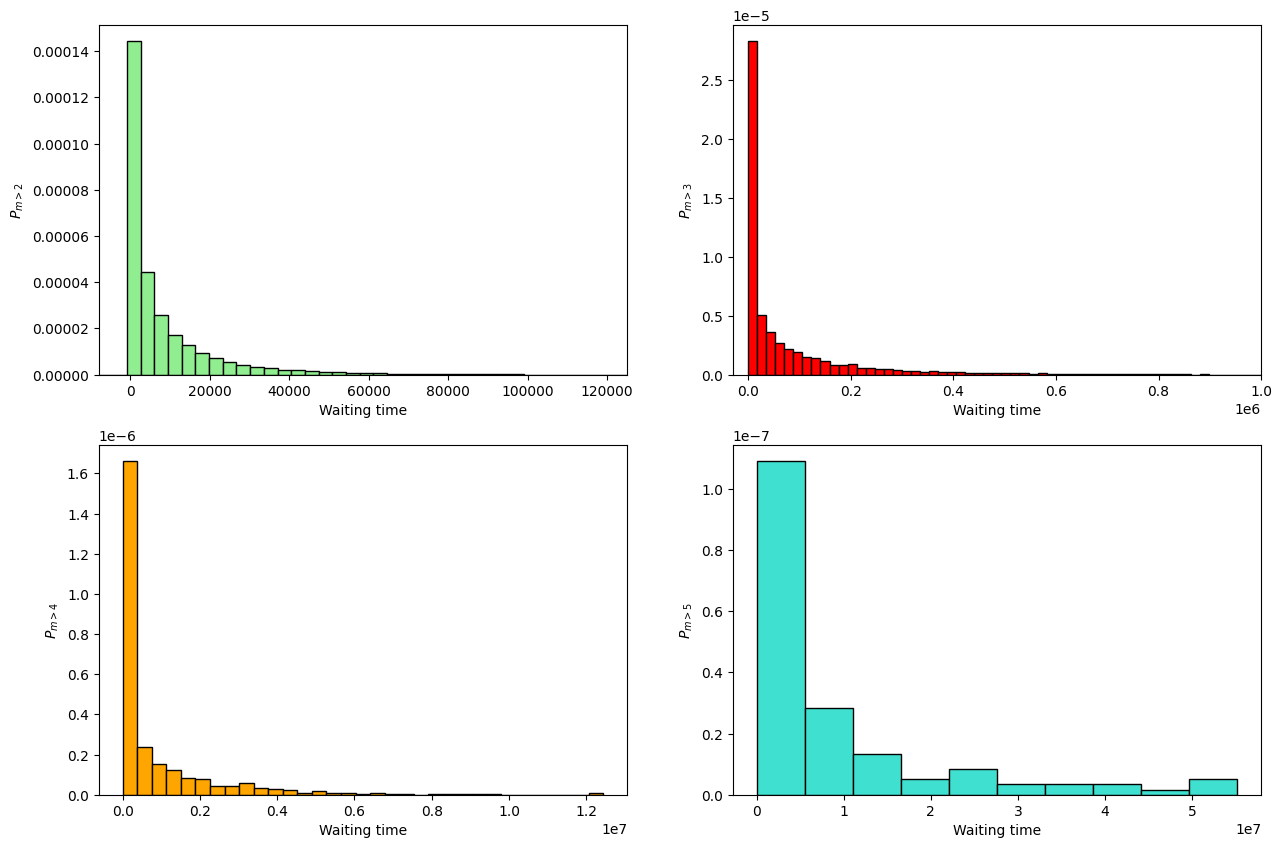

In [73]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

#dataframe copy
mod_df2 = df.copy()
#filtering of the dataframe for magnitude above 2
mod_df2 = mod_df2[mod_df2['Magnitude'] >= 2]
#computing waiting times
mod_df2['diff'] = mod_df2['Time [s]'].diff()
#number of bins used
num_bins2 = int(np.sqrt(mod_df2['diff'].shape[0]))
#plotting of the histogram
counts, bin_edges, _ = axs[0, 0].hist(mod_df2['diff'], bins=num_bins2, color='lightgreen', edgecolor='black', density=True)
axs[0, 0].set_xlim(-0.008e6, 0.125e6)
axs[0, 0].set_ylabel('$P_{m>2}$')
axs[0, 0].set_xlabel('Waiting time')

mod_df3 = df.copy()
mod_df3 = mod_df3[mod_df3['Magnitude'] >= 3]
mod_df3['diff'] = mod_df3['Time [s]'].diff()
num_bins3 = int(np.sqrt(mod_df3['diff'].shape[0]))
counts, bin_edges, _ = axs[0, 1].hist(mod_df3['diff'], bins=num_bins3, color='red', edgecolor='black', density=True)
axs[0, 1].set_xlim(-0.03e6, 1e6)
axs[0, 1].set_ylabel('$P_{m>3}$')
axs[0, 1].set_xlabel('Waiting time')

mod_df4 = df.copy()
mod_df4 = mod_df4[mod_df4['Magnitude'] >= 4]
mod_df4['diff'] = mod_df4['Time [s]'].diff()
num_bins4 = int(np.sqrt(mod_df4['diff'].shape[0]))
counts, bin_edges, _ = axs[1, 0].hist(mod_df4['diff'], bins=num_bins4, color='orange', edgecolor='black', density=True)
axs[1, 0].set_ylabel('$P_{m>4}$')
axs[1, 0].set_xlabel('Waiting time')

mod_df5 = df.copy()
mod_df5 = mod_df5[mod_df5['Magnitude'] >= 5]
mod_df5['diff'] = mod_df5['Time [s]'].diff()
num_bins5 = int(np.sqrt(mod_df5['diff'].shape[0]))
counts, bin_edges, _ = axs[1, 1].hist(mod_df5['diff'], bins=num_bins5, color='turquoise', edgecolor='black', density=True)
axs[1, 1].set_ylabel('$P_{m>5}$')
axs[1, 1].set_xlabel('Waiting time')


###2.1.1) Computing the KDE distribution
The Kernel density distribution is a way to estimate the probability density function of a random variable in a non-parametric way.

Text(0.5, 0, 'Waiting time')

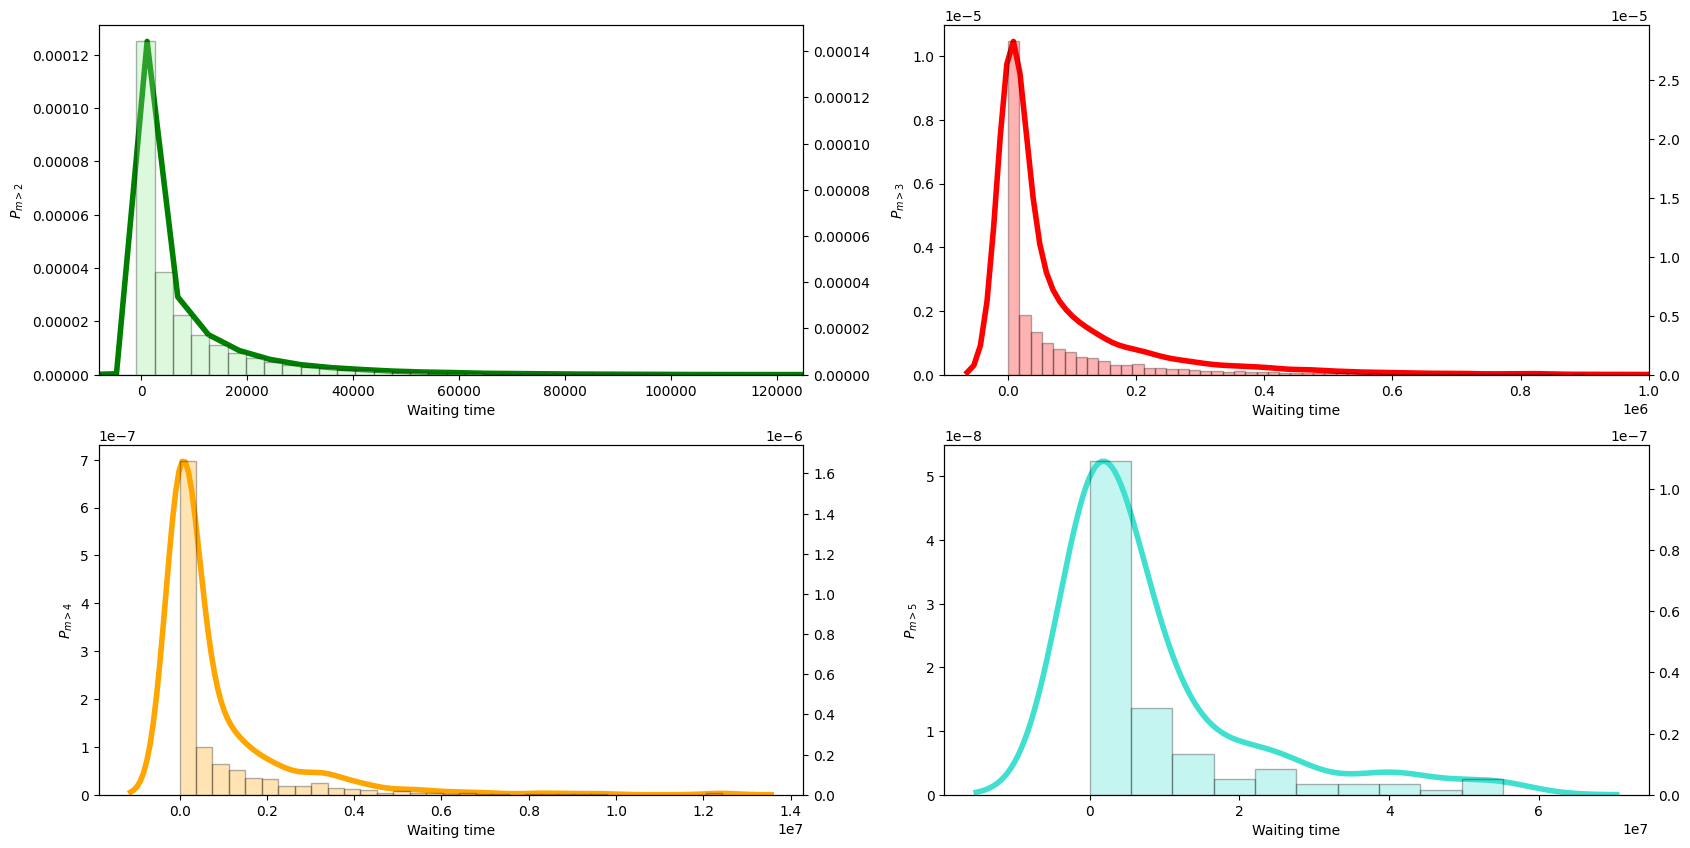

In [74]:
fig2, axs2 = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

#plotting of the kde distribution
sns.kdeplot(data=mod_df2, ax=axs2[0, 0], x='diff', linewidth=4, color='green')
ax2 = axs2[0, 0].twinx()
counts, bin_edges, _ = ax2.hist(mod_df2['diff'], bins=num_bins2, color='lightgreen', edgecolor='black', density=True, alpha=0.3)
axs2[0, 0].set_xlim(-0.008e6, 0.125e6)
axs2[0, 0].set_ylabel('$P_{m>2}$')
axs2[0, 0].set_xlabel('Waiting time')

sns.kdeplot(data=mod_df3, ax=axs2[0, 1], x='diff', linewidth=4, color='red')
ax3 = axs2[0, 1].twinx()
counts, bin_edges, _ = ax3.hist(mod_df3['diff'], bins=num_bins3, color='red', edgecolor='black', density=True, alpha=0.3)
axs2[0, 1].set_xlim(-0.1e6, 1e6)
axs2[0, 1].set_ylabel('$P_{m>3}$')
axs2[0, 1].set_xlabel('Waiting time')

sns.kdeplot(data=mod_df4, ax=axs2[1, 0], x='diff', linewidth=4, color='orange')
ax4 = axs2[1, 0].twinx()
counts, bin_edges, _ = ax4.hist(mod_df4['diff'], bins=num_bins4, color='orange', edgecolor='black', density=True, alpha=0.3)
axs2[1, 0].set_ylabel('$P_{m>4}$')
axs2[1, 0].set_xlabel('Waiting time')

sns.kdeplot(data=mod_df5, ax=axs2[1, 1], x='diff', linewidth=4, color='turquoise')
ax5 = axs2[1, 1].twinx()
counts, bin_edges, _ = ax5.hist(mod_df5['diff'], bins=num_bins5, color='turquoise', edgecolor='black', density=True, alpha=0.3)
axs2[1, 1].set_ylabel('$P_{m>5}$')
axs2[1, 1].set_xlabel('Waiting time')

The bandwidth selection strongly influences the estimate obtained from the KDE: using a small bandwidth value can lead to over-fitting while using a large bandwidth value may result in under-fitting.

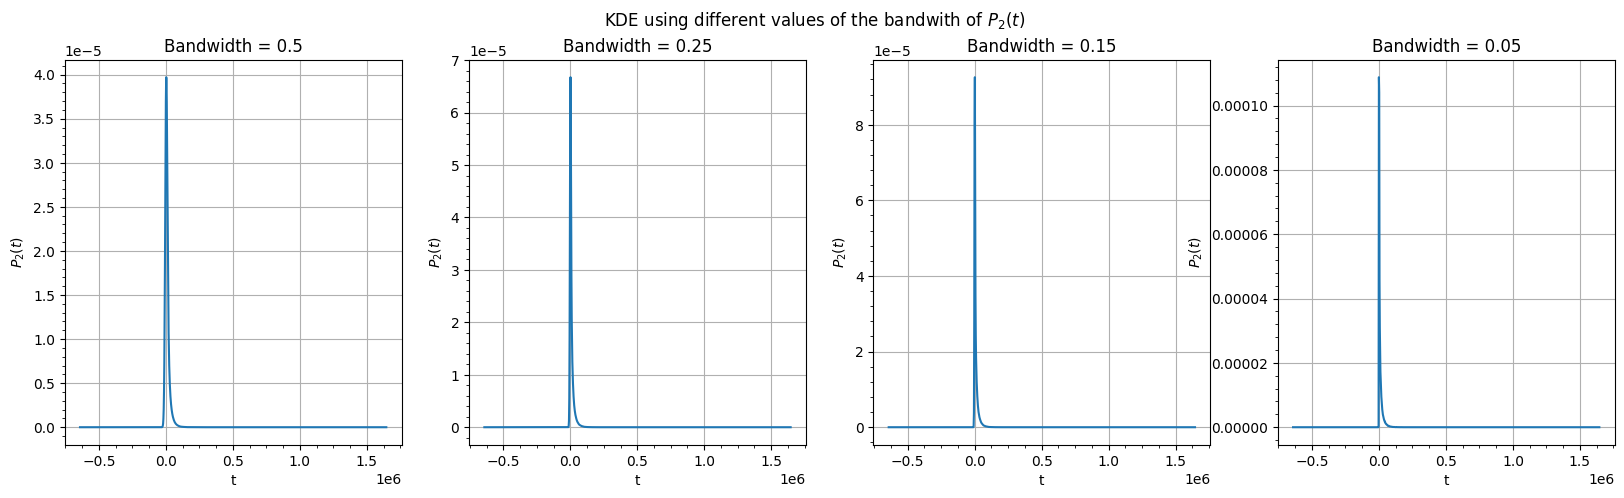

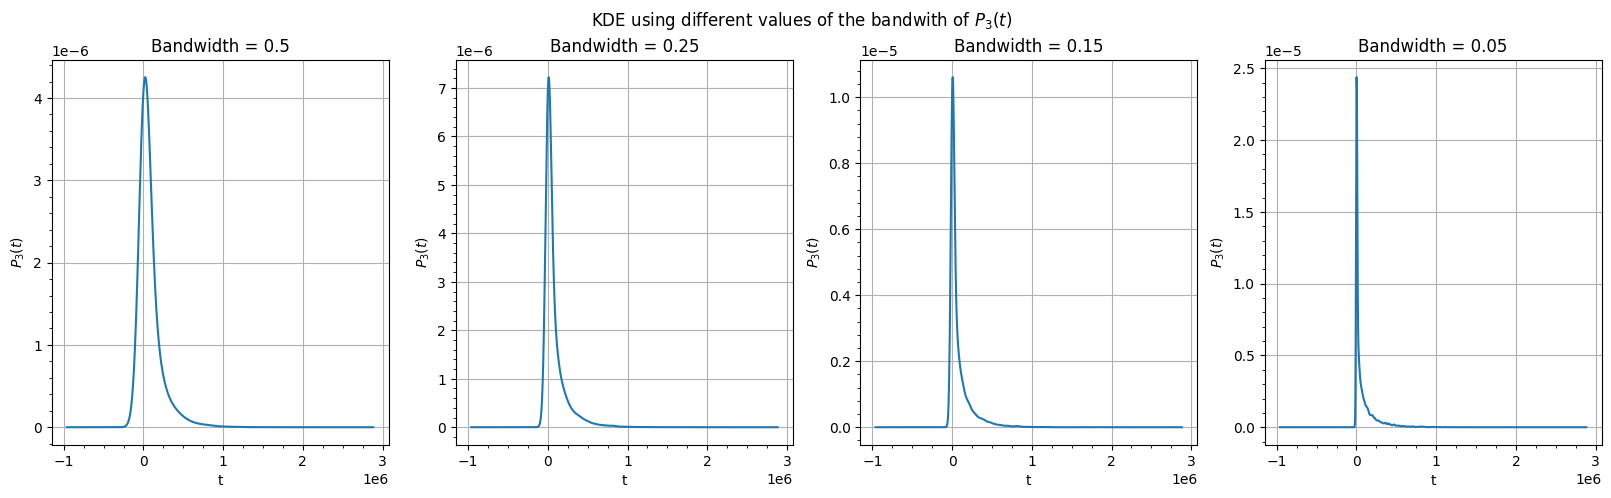

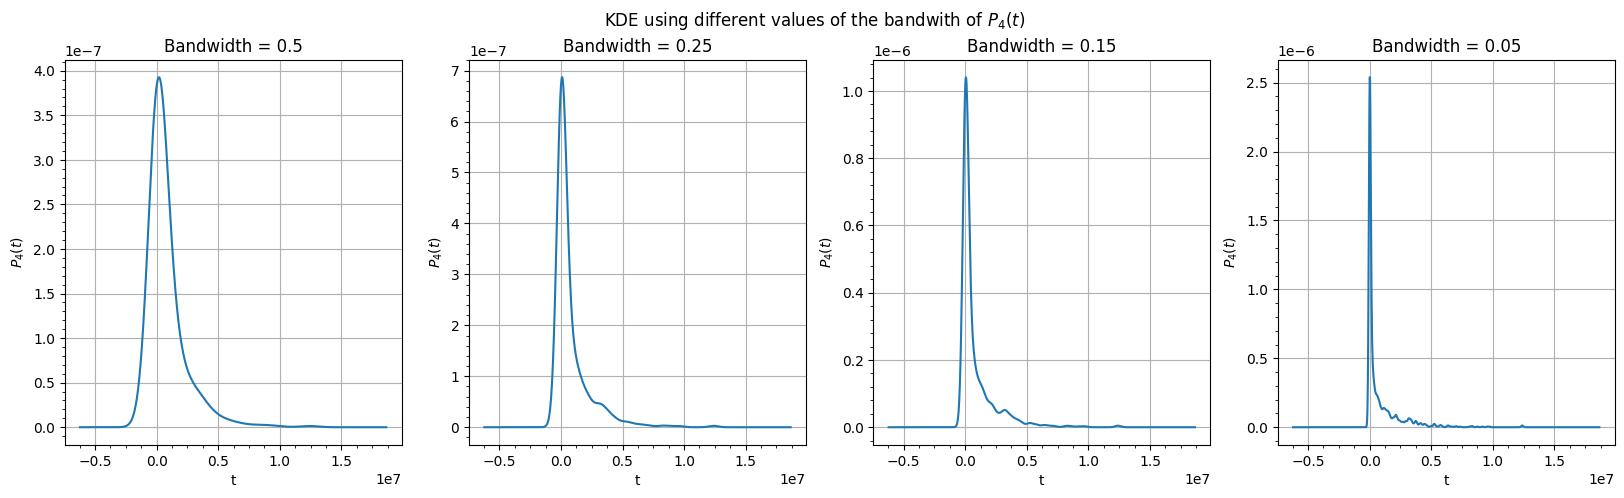

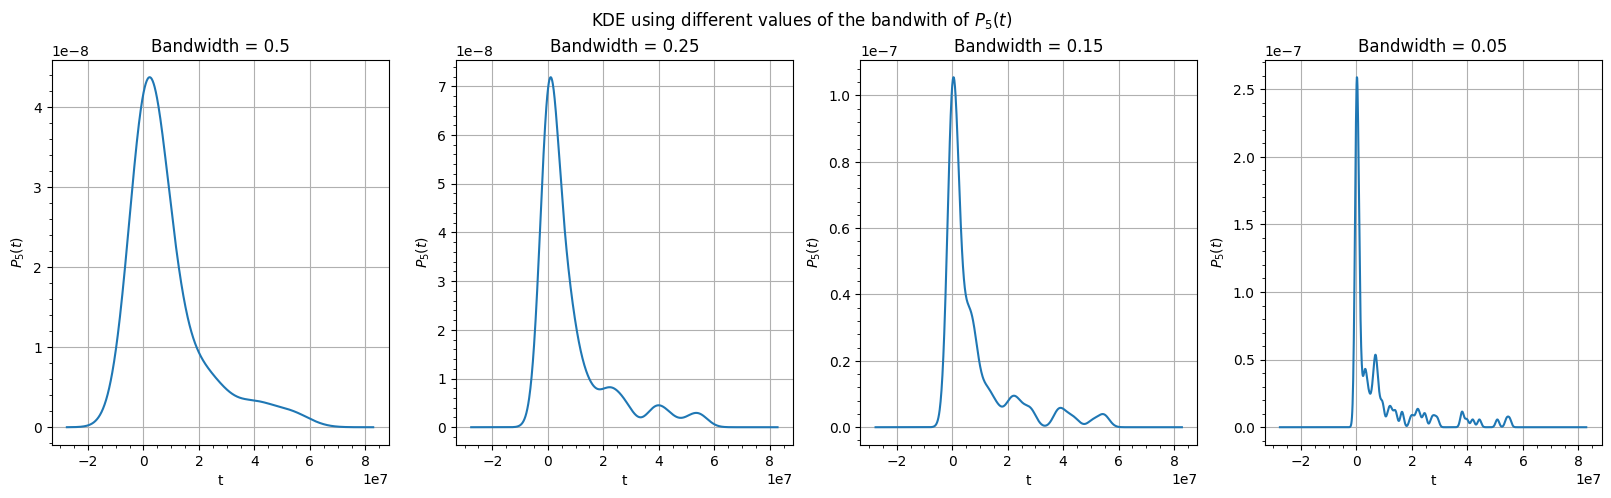

In [75]:
#bandwidth estimation example for m = 2

fig_testB1, axs_testB1 = plt.subplots(1, 4, figsize=(20, 5))
fig_testB1.suptitle('KDE using different values of the bandwith of $P_2(t)$')

# using b = 0.5
kde_m2_b1 = mod_df2['diff'].plot.kde(ax =axs_testB1[0], bw_method = 0.5)
axs_testB1[0].set_title("Bandwidth = 0.5")
axs_testB1[0].set_xlabel("t")
axs_testB1[0].set_ylabel('$P_2(t)$')
axs_testB1[0].grid()
axs_testB1[0].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB1[0].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.25
kde_m2_b2 = mod_df2['diff'].plot.kde(ax =axs_testB1[1], bw_method = 0.25)
axs_testB1[1].set_title("Bandwidth = 0.25")
axs_testB1[1].set_xlabel("t")
axs_testB1[1].set_ylabel('$P_2(t)$')
axs_testB1[1].grid()
axs_testB1[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB1[1].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.15
kde_m2_b3 = mod_df2['diff'].plot.kde(ax =axs_testB1[2], bw_method = 0.15)
axs_testB1[2].set_title("Bandwidth = 0.15")
axs_testB1[2].set_xlabel("t")
axs_testB1[2].set_ylabel('$P_2(t)$')
axs_testB1[2].grid()
axs_testB1[2].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB1[2].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.05
kde_m2_b4 = mod_df2['diff'].plot.kde(ax =axs_testB1[3], bw_method = 0.05)
axs_testB1[3].set_title("Bandwidth = 0.05")
axs_testB1[3].set_xlabel("t")
axs_testB1[3].set_ylabel('$P_2(t)$')
axs_testB1[3].grid()
axs_testB1[3].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB1[3].yaxis.set_minor_locator(AutoMinorLocator(5))



#bandwidth estimation example for m = 3
fig_testB3, axs_testB3 = plt.subplots(1, 4, figsize=(20, 5))
fig_testB3.suptitle('KDE using different values of the bandwith of $P_3(t)$')

# using b = 0.5
kde_m2_b1 = mod_df3['diff'].plot.kde(ax =axs_testB3[0], bw_method = 0.5)
axs_testB3[0].set_title("Bandwidth = 0.5")
axs_testB3[0].set_xlabel("t")
axs_testB3[0].set_ylabel('$P_3(t)$')
axs_testB3[0].grid()
axs_testB3[0].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB3[0].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.25
kde_m2_b2 = mod_df3['diff'].plot.kde(ax =axs_testB3[1], bw_method = 0.25)
axs_testB3[1].set_title("Bandwidth = 0.25")
axs_testB3[1].set_xlabel("t")
axs_testB3[1].set_ylabel('$P_3(t)$')
axs_testB3[1].grid()
axs_testB3[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB3[1].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.15
kde_m2_b3 = mod_df3['diff'].plot.kde(ax =axs_testB3[2], bw_method = 0.15)
axs_testB3[2].set_title("Bandwidth = 0.15")
axs_testB3[2].set_xlabel("t")
axs_testB3[2].set_ylabel('$P_3(t)$')
axs_testB3[2].grid()
axs_testB3[2].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB3[2].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.05
kde_m2_b4 = mod_df3['diff'].plot.kde(ax =axs_testB3[3], bw_method = 0.05)
axs_testB3[3].set_title("Bandwidth = 0.05")
axs_testB3[3].set_xlabel("t")
axs_testB3[3].set_ylabel('$P_3(t)$')

axs_testB3[3].grid()
axs_testB3[3].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB3[3].yaxis.set_minor_locator(AutoMinorLocator(5))



#bandwidth estimation example for m = 4

fig_testB4, axs_testB4 = plt.subplots(1, 4, figsize=(20, 5))
fig_testB4.suptitle('KDE using different values of the bandwith of $P_4(t)$')

# using b = 0.5
kde_m4_b1 = mod_df4['diff'].plot.kde(ax =axs_testB4[0], bw_method = 0.5)
axs_testB4[0].set_title("Bandwidth = 0.5")
axs_testB4[0].set_xlabel("t")
axs_testB4[0].set_ylabel('$P_4(t)$')
axs_testB4[0].grid()
axs_testB4[0].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB4[0].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.25
kde_m4_b2 = mod_df4['diff'].plot.kde(ax =axs_testB4[1], bw_method = 0.25)
axs_testB4[1].set_title("Bandwidth = 0.25")
axs_testB4[1].set_xlabel("t")
axs_testB4[1].set_ylabel('$P_4(t)$')
axs_testB4[1].grid()
axs_testB4[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB4[1].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.15
kde_m4_b3 = mod_df4['diff'].plot.kde(ax =axs_testB4[2], bw_method = 0.15)
axs_testB4[2].set_title("Bandwidth = 0.15")
axs_testB4[2].set_xlabel("t")
axs_testB4[2].set_ylabel('$P_4(t)$')
axs_testB4[2].grid()
axs_testB4[2].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB4[2].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.05
kde_m4_b4 = mod_df4['diff'].plot.kde(ax =axs_testB4[3], bw_method = 0.05)
axs_testB4[3].set_title("Bandwidth = 0.05")
axs_testB4[3].set_xlabel("t")
axs_testB4[3].set_ylabel('$P_4(t)$')

axs_testB4[3].grid()
axs_testB4[3].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB4[3].yaxis.set_minor_locator(AutoMinorLocator(5))



#bandwidth estimation example for m = 5

fig_testB5, axs_testB5 = plt.subplots(1, 4, figsize=(20, 5))
fig_testB5.suptitle('KDE using different values of the bandwith of $P_5(t)$')

# using b = 0.5
kde_m4_b1 = mod_df5['diff'].plot.kde(ax =axs_testB5[0], bw_method = 0.5)
axs_testB5[0].set_title("Bandwidth = 0.5")
axs_testB5[0].set_xlabel("t")
axs_testB5[0].set_ylabel('$P_5(t)$')
axs_testB5[0].grid()
axs_testB5[0].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB5[0].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.25
kde_m4_b2 = mod_df5['diff'].plot.kde(ax =axs_testB5[1], bw_method = 0.25)
axs_testB5[1].set_title("Bandwidth = 0.25")
axs_testB5[1].set_xlabel("t")
axs_testB5[1].set_ylabel('$P_5(t)$')
axs_testB5[1].grid()
axs_testB5[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB5[1].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.15
kde_m4_b3 = mod_df5['diff'].plot.kde(ax =axs_testB5[2], bw_method = 0.15)
axs_testB5[2].set_title("Bandwidth = 0.15")
axs_testB5[2].set_xlabel("t")
axs_testB5[2].set_ylabel('$P_5(t)$')
axs_testB5[2].grid()
axs_testB5[2].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB5[2].yaxis.set_minor_locator(AutoMinorLocator(5))

# using b = 0.05
kde_m4_b4 = mod_df5['diff'].plot.kde(ax =axs_testB5[3], bw_method = 0.05)
axs_testB5[3].set_title("Bandwidth = 0.05")
axs_testB5[3].set_xlabel("t")
axs_testB5[3].set_ylabel('$P_5(t)$')

axs_testB5[3].grid()
axs_testB5[3].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB5[3].yaxis.set_minor_locator(AutoMinorLocator(5))

From the graphical visaulization the most appropriate bandwidth appears to be 0.15.

###2.1.2) Fitting of the KDE distribution
The data has been fitted exploiting `scipy.optimize.curve_fit` with an exponential function $f(x) = A e^{-Bx}$. As known from theory, the optimal values are obtained by minimizing the sum of the squared residuals.



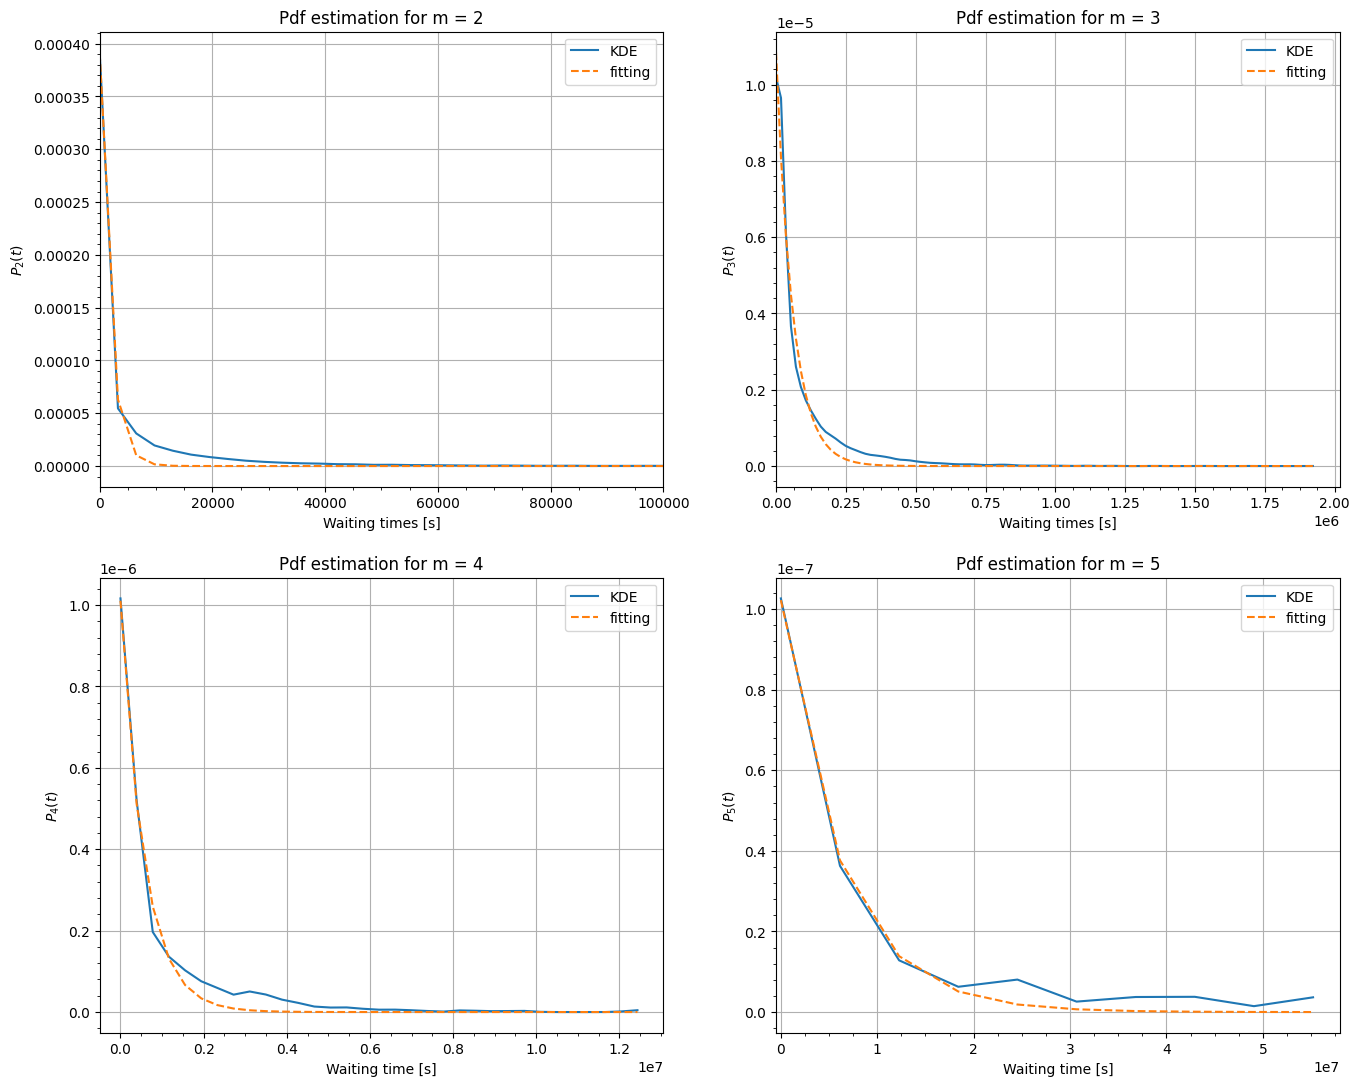

In [76]:
#results for m = 2 #
figure4, axs_kde = plt.subplots(nrows=2, ncols=2, figsize=(16, 13))

bw2 = 0.01

#create the kde estimation
mod_df2 = mod_df2.dropna()
kde_m2_obj = scipy.stats.gaussian_kde(mod_df2['diff'], bw_method=bw2)

#evaluating the kde
x_m2 = np.linspace(0, mod_df2['diff'].max(),  int(np.sqrt(len(mod_df2['diff']))) )
kde_function_m2 = kde_m2_obj.evaluate(x_m2)

#plotting the estimated kde
axs_kde[0][0].plot(x_m2,kde_function_m2)

#defining the function to fit
def func(t, a, b):
    return a * np.exp(- b * t)

popt_m2, pcov_m2 = scipy.optimize.curve_fit(func, x_m2, kde_function_m2, p0 = [0, 0.01e-5])

#plotting the estimated function
pdf_fitting_m2 = func(x_m2,popt_m2[0],popt_m2[1])
axs_kde[0][0].plot(x_m2,pdf_fitting_m2, '--')

axs_kde[0][0].set_title("Pdf estimation for m = 2")
axs_kde[0][0].set_ylabel('$P_2(t)$')
axs_kde[0][0].set_xlabel('Waiting times [s]')
axs_kde[0][0].legend(["KDE","fitting"])
axs_kde[0][0].grid()
axs_kde[0][0].set_xlim(0, 0.1e6)
axs_kde[0][0].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_kde[0][0].yaxis.set_minor_locator(AutoMinorLocator(5))


bw3 = 0.15

#create the kde estimation
mod_df3 = mod_df3.dropna()
kde_m3_obj = scipy.stats.gaussian_kde(mod_df3['diff'], bw_method=bw3)

#evaluating the kde
x_m3 = np.linspace(mod_df3['diff'].min(), mod_df3['diff'].max(),  int(np.sqrt(len(mod_df3['diff']))) )
kde_function_m3 = kde_m3_obj.evaluate(x_m3)

#plotting the estimated kde
axs_kde[0][1].plot(x_m3,kde_function_m3)

#defining the function to fit
def func(t, a, b):
    return a * np.exp(- b * t)

popt_m3, pcov_m3 = scipy.optimize.curve_fit(func, x_m3, kde_function_m3, p0 = [0, 8e-5])

#plotting the estimated function
pdf_fitting_m3 = func(x_m3,popt_m3[0],popt_m3[1])
axs_kde[0][1].plot(x_m3,pdf_fitting_m3, '--')

axs_kde[0][1].set_title("Pdf estimation for m = 3")
axs_kde[0][1].set_ylabel('$P_3(t)$')
axs_kde[0][1].set_xlabel('Waiting times [s]')
axs_kde[0][1].legend(["KDE","fitting"])
axs_kde[0][1].grid()
axs_kde[0][1].set_xlim(left = 0)
axs_kde[0][1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_kde[0][1].yaxis.set_minor_locator(AutoMinorLocator(5))


bw4 = 0.15

#create the kde estimation
mod_df4 = mod_df4.dropna()
kde_m4_obj = scipy.stats.gaussian_kde(mod_df4['diff'], bw_method=bw4)

#evaluating the kde
x_m4 = np.linspace(mod_df4['diff'].min(), mod_df4['diff'].max(),  int(np.sqrt(len(mod_df4['diff']))) )
kde_function_m4 = kde_m4_obj.evaluate(x_m4)

#plotting the estimated kde
axs_kde[1][0].plot(x_m4,kde_function_m4)

#defining the function to fit
def func(t, a, b):
    return a * np.exp(- b * t)

popt_m4, pcov_m4 = scipy.optimize.curve_fit(func, x_m4, kde_function_m4, p0 = [0, 1e-6])

#plotting the estimated function
pdf_fitting_m4 = func(x_m4,popt_m4[0],popt_m4[1])
axs_kde[1][0].plot(x_m4,pdf_fitting_m4, '--')

axs_kde[1][0].set_title("Pdf estimation for m = 4")
axs_kde[1][0].set_ylabel('$P_4(t)$')
axs_kde[1][0].set_xlabel('Waiting time [s]')
axs_kde[1][0].legend(["KDE","fitting"])
axs_kde[1][0].grid()
axs_kde[1][0].set_xlim(left = -0.5e6)
axs_kde[1][0].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_kde[1][0].yaxis.set_minor_locator(AutoMinorLocator(5))


bw5 = 0.15

#create the kde estimation
mod_df5 = mod_df5.dropna()
kde_m5_obj = scipy.stats.gaussian_kde(mod_df5['diff'], bw_method=bw5)

#evaluating the kde
x_m5 = np.linspace(mod_df5['diff'].min(), mod_df5['diff'].max(),  int(np.sqrt(len(mod_df5['diff']))) )
kde_function_m5 = kde_m5_obj.evaluate(x_m5)

#plotting the estimated kde
axs_kde[1][1].plot(x_m5,kde_function_m5)

#defining the function to fit
def func(t, a, b):
    return a * np.exp(- b * t)

popt_m5, pcov_m5 = scipy.optimize.curve_fit(func, x_m5, kde_function_m5, p0 = [0, 1e-6])

#plotting the estimated function
pdf_fitting_m5 = func(x_m5,popt_m5[0],popt_m5[1])
axs_kde[1][1].plot(x_m5, pdf_fitting_m5, '--')

axs_kde[1][1].set_title("Pdf estimation for m = 5")
axs_kde[1][1].set_ylabel('$P_5(t)$')
axs_kde[1][1].set_xlabel('Waiting time [s]')
axs_kde[1][1].legend(["KDE","fitting"])
axs_kde[1][1].grid()
axs_kde[1][1].set_xlim(left = -0.5e6)
axs_kde[1][1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_kde[1][1].yaxis.set_minor_locator(AutoMinorLocator(5))


Here in this section the goodness of fit has been performed using the $\chi^2$ in order to verify if the function chosen well approximates the data.

In [77]:
p = np.arange(0, 40, 0.1)

#results for m = 2
ndof_m2 = len(x_m2) - 1

# calculate the chi^2
chi2_m2 = np.sum(((kde_function_m2 - pdf_fitting_m2)**2) / np.std(kde_function_m2)**2)
print("chi2 =", chi2_m2)

# calculate the p-value from the chi^2, the n.d.o.f., and the cumulative chi^2 distribution
pvalue_2m = 1. - scipy.stats.chi2.cdf(chi2_m2, ndof_m2)
print("p-value =", pvalue_2m)


#results for m = 3
ndof_m3 = len(x_m3) - 1

# calculate the chi^2
chi2_m3 = np.sum(((kde_function_m3 - pdf_fitting_m3)**2) / np.std(kde_function_m3)**2)
print("chi2 =", chi2_m3)

# calculate the p-value from the chi^2, the n.d.o.f., and the cumulative chi^2 distribution
pvalue_m3 = 1. - scipy.stats.chi2.cdf(chi2_m3, ndof_m3)
print("p-value =", pvalue_m3)


#results for m = 4
ndof_m4 = len(x_m4) - 1

# calculate the chi^2
chi2_m4 = np.sum(((kde_function_m4 - pdf_fitting_m4)**2) / np.std(kde_function_m4)**2)
print("chi2 =", chi2_m4)

# calculate the p-value from the chi^2, the n.d.o.f., and the cumulative chi^2 distribution
pvalue_m4 = 1. - scipy.stats.chi2.cdf(chi2_m4, ndof_m4)
print("p-value =", pvalue_m4)

#results for m = 5
ndof_m5 = len(x_m5) - 1

# calculate the chi^2
chi2_m5 = np.sum(((kde_function_m5 - pdf_fitting_m5)**2) / np.std(kde_function_m5)**2)
print("chi2 =", chi2_m5)

# calculate the p-value from the chi^2, the n.d.o.f., and the cumulative chi^2 distribution
pvalue_m5 = 1. - (scipy.stats.chi2.cdf(chi2_m5, ndof_m5))
print("p-value =", pvalue_m5)

chi2 = 2.811785870812248
p-value = 1.0
chi2 = 2.599310646004606
p-value = 1.0
chi2 = 0.42884450484404396
p-value = 1.0
chi2 = 0.09865890067690312
p-value = 0.9999999758673352


The p-values are higher than the level of significance, chosen to be $\alpha = 0.05$, therefore we cannot conclude that the fitting is unsatisfactory.

##2.2) Log-log visualization
In this point we plotted the log-log scale of the distribution of the data, in order to appreciate the power-law distribution: $P(x) = Cx^{-k}$ where $x$ is the vector that contains the waiting times.
In fact plotting in log-log scale we will visualize $log_{10}P(x) = log_{10}(C)-k \cdot log_{10}(x)$.

Text(0.5, 0, 'Waiting time [log]')

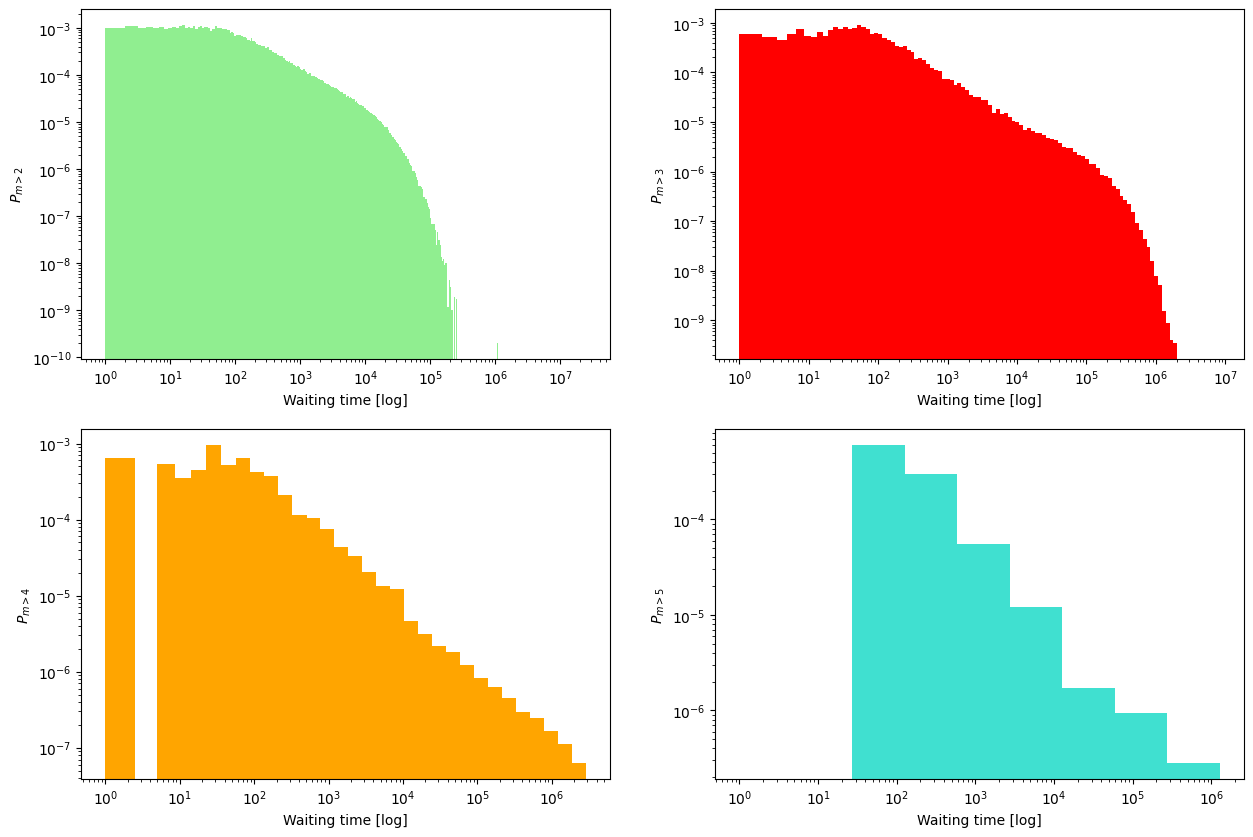

In [78]:
fig1, axs1 = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

num_bins2_log = np.logspace(0, 6, num_bins2)
x_bins2 = np.cumsum(num_bins2_log)
counts_log, bin_edges_log, _ = axs1[0, 0].hist(mod_df2['diff'], bins=x_bins2, color='lightgreen', density=True)
axs1[0, 0].set_xscale('log')
axs1[0, 0].set_yscale('log')
axs1[0, 0].set_ylabel('$P_{m>2}$')
axs1[0, 0].set_xlabel('Waiting time [log]')

num_bins3_log = np.logspace(0, 6, num_bins3)
x_bins3 = np.cumsum(num_bins3_log)
counts_log, bin_edges_log, _ = axs1[0, 1].hist(mod_df3['diff'], bins=x_bins3, color='red', density=True)
axs1[0, 1].set_xscale('log')
axs1[0, 1].set_yscale('log')
axs1[0, 1].set_ylabel('$P_{m>3}$')
axs1[0, 1].set_xlabel('Waiting time [log]')

num_bins4_log = np.logspace(0, 6, num_bins4)
x_bins4 = np.cumsum(num_bins4_log)
counts_log, bin_edges_log, _ = axs1[1, 0].hist(mod_df4['diff'], bins=x_bins4, color='orange', density=True)
axs1[1, 0].set_xscale('log')
axs1[1, 0].set_yscale('log')
axs1[1, 0].set_ylabel('$P_{m>4}$')
axs1[1, 0].set_xlabel('Waiting time [log]')

num_bins5_log = np.logspace(0, 6, num_bins5)
x_bins5 = np.cumsum(num_bins5_log)
counts_log, bin_edges_log, _ = axs1[1, 1].hist(mod_df5['diff'], bins=x_bins5, color='turquoise', density=True)
axs1[1, 1].set_xscale('log')
axs1[1, 1].set_yscale('log')
axs1[1, 1].set_ylabel('$P_{m>5}$')
axs1[1, 1].set_xlabel('Waiting time [log]')

###2.2.1) Power-law fitting
The linear relation cannot be appreciated for all magnitudes. Especially for the lower ones, i.e. **m=2, 3**.
In fact in those cases we had to filter out the highest and lowest waiting times. \\
Our choice was supported by the fact that the probaility of having a high waiting time for events of low magnitude decreases rapidly and therefore their probability is pretty low. For what concernes the lower waiting times, they have a different probability distribution with respect to the higher ones that have a linear behaviour. Those are the reason for which we have kept just the data in the middle, that followed a linear decrease, according to the power-law.

Text(0, 0.5, 'Y-axis label')

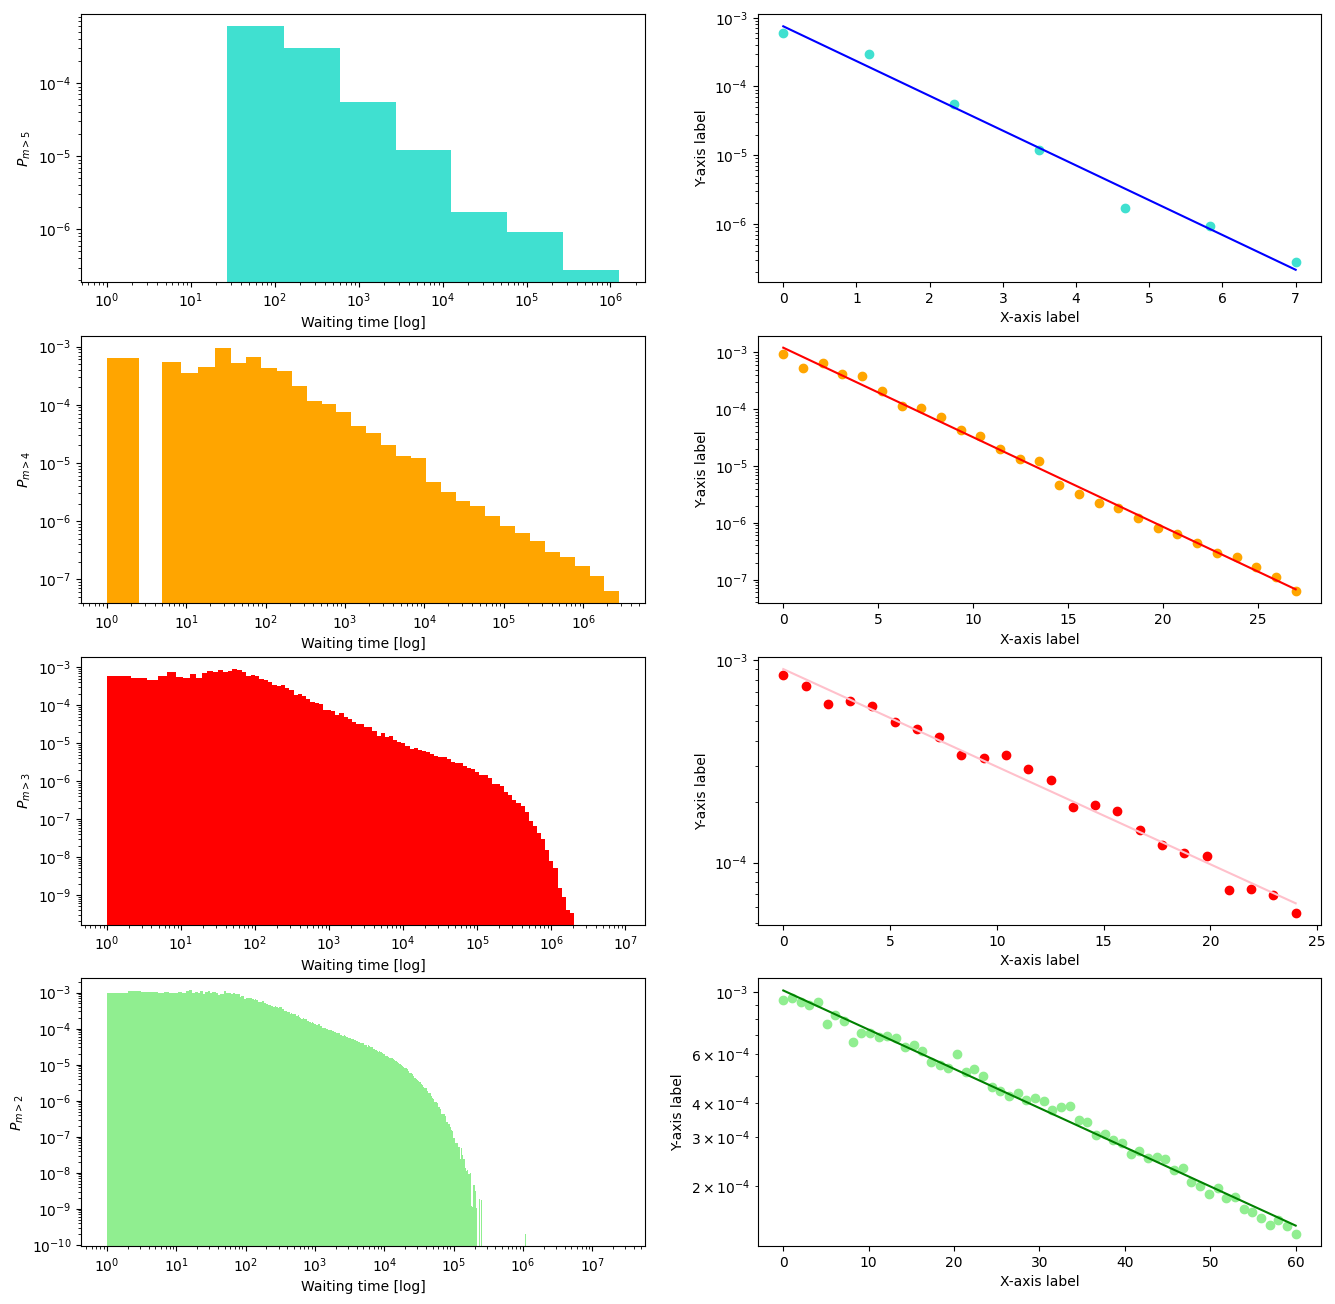

In [79]:
figs, axs = plt.subplots(4, 2, figsize=(16, 16))

num_bins5_log = np.logspace(0, 6, num_bins5)
x_bins5 = np.cumsum(num_bins5_log)
counts_log, bin_edges_log, _ = axs[0, 0].hist(mod_df5['diff'], bins=x_bins5, color='turquoise', density=True)
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].set_ylabel('$P_{m>5}$')
axs[0, 0].set_xlabel('Waiting time [log]')

counts_log = counts_log[counts_log>0]
space = np.linspace(0, len(counts_log), len(counts_log))

axs[0, 1].scatter(space, counts_log, c='turquoise')

# Define the linear fitting function
def f1(x, a0, a1):
    return a0 + a1 * x

# Using log of counts for fitting
(fa0, fa1), cov = scipy.optimize.curve_fit(f1, space, np.log(counts_log))
y1 = f1(space, fa0, fa1)

# Taking exp to revert back from log scale
axs[0, 1].plot(space, np.exp(y1), color='blue', label="linear")
axs[0, 1].set_yscale('log')
axs[0, 1].set_xlabel('X-axis label')
axs[0, 1].set_ylabel('Y-axis label')


num_bins4_log = np.logspace(0, 6, num_bins4)
x_bins4 = np.cumsum(num_bins4_log)
counts_log, bin_edges_log, _ = axs[1, 0].hist(mod_df4['diff'], bins=x_bins4, color='orange', density=True)
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_ylabel('$P_{m>4}$')
axs[1, 0].set_xlabel('Waiting time [log]')

counts_log = counts_log[counts_log>0]
counts_log = counts_log[4::]
space = np.linspace(0, len(counts_log), len(counts_log))

axs[1, 1].scatter(space, counts_log, c='orange')

(fa0, fa1), cov = scipy.optimize.curve_fit(f1, space, np.log(counts_log))
y1 = f1(space, fa0, fa1)

axs[1, 1].plot(space, np.exp(y1), color='red', label="linear")
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('X-axis label')
axs[1, 1].set_ylabel('Y-axis label')


num_bins3_log = np.logspace(0, 6, num_bins3)
x_bins3 = np.cumsum(num_bins3_log)
counts_log, bin_edges_log, _ = axs[2, 0].hist(mod_df3['diff'], bins=x_bins3, color='red', density=True)
axs[2, 0].set_xscale('log')
axs[2, 0].set_yscale('log')
axs[2, 0].set_ylabel('$P_{m>3}$')
axs[2, 0].set_xlabel('Waiting time [log]')

counts_log = counts_log[counts_log>0]
counts_log = counts_log[16:40]
space = np.linspace(0, len(counts_log), len(counts_log))

axs[2, 1].scatter(space, counts_log, c='red')

(fa0, fa1), cov = scipy.optimize.curve_fit(f1, space, np.log(counts_log))
y1 = f1(space, fa0, fa1)

axs[2, 1].plot(space, np.exp(y1), color='pink', label="linear")
axs[2, 1].set_yscale('log')
axs[2, 1].set_xlabel('X-axis label')
axs[2, 1].set_ylabel('Y-axis label')

num_bins2_log = np.logspace(0, 6, num_bins2)
x_bins2 = np.cumsum(num_bins2_log)
counts_log, bin_edges_log, _ = axs[3, 0].hist(mod_df2['diff'], bins=x_bins2, color='lightgreen', density=True)
axs[3, 0].set_xscale('log')
axs[3, 0].set_yscale('log')
axs[3, 0].set_ylabel('$P_{m>2}$')
axs[3, 0].set_xlabel('Waiting time [log]')

counts_log = counts_log[counts_log>0]
counts_log = counts_log[30:90]
space = np.linspace(0, len(counts_log), len(counts_log))

axs[3, 1].scatter(space, counts_log, c='lightgreen')

(fa0, fa1), cov = scipy.optimize.curve_fit(f1, space, np.log(counts_log))
y1 = f1(space, fa0, fa1)

axs[3, 1].plot(space, np.exp(y1), color='green', label="linear")
axs[3, 1].set_yscale('log')
axs[3, 1].set_xlabel('X-axis label')
axs[3, 1].set_ylabel('Y-axis label')

# 3) Distribution $P_m(r)$ of the distance between an event and the next one

The probability distribution of the following events has been computed for different values of magnitude > m, for  **m  = 2, 3, 4, 5 **.





## 3.1) Distribution  $P_m(i)$ for i = x, y, z
For what regards the number of bins, assumng the position of the events to be random, thererfore the number of bin are been choosen as $\sqrt n$, where $n$ are numbers of entries of the histogram.

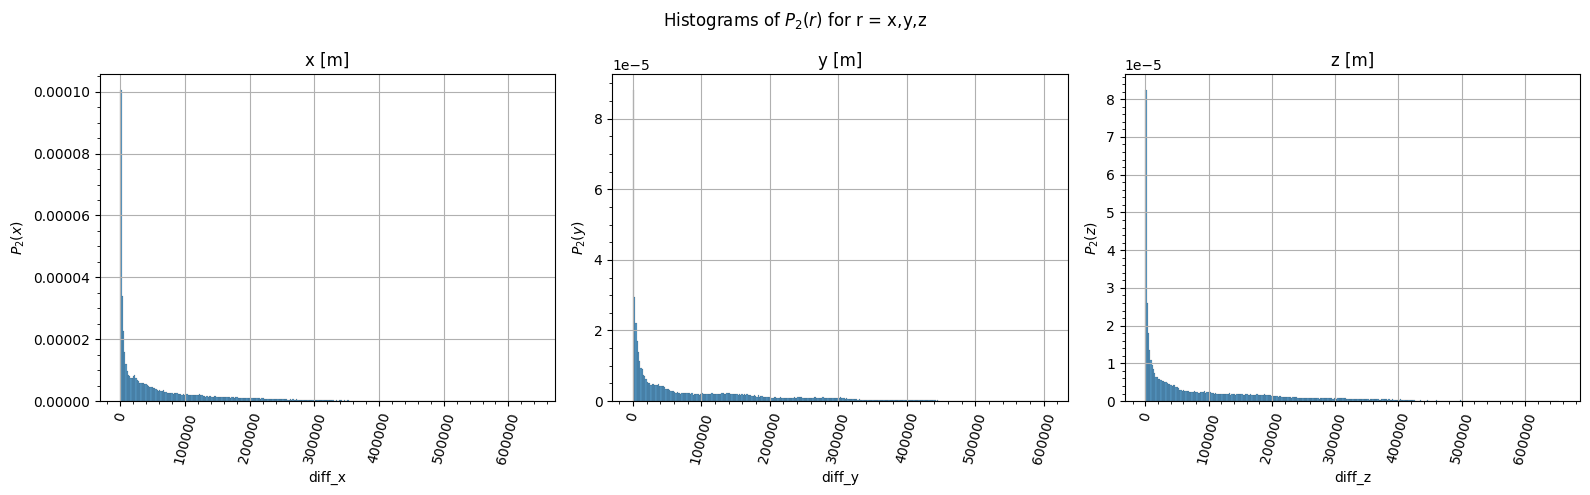

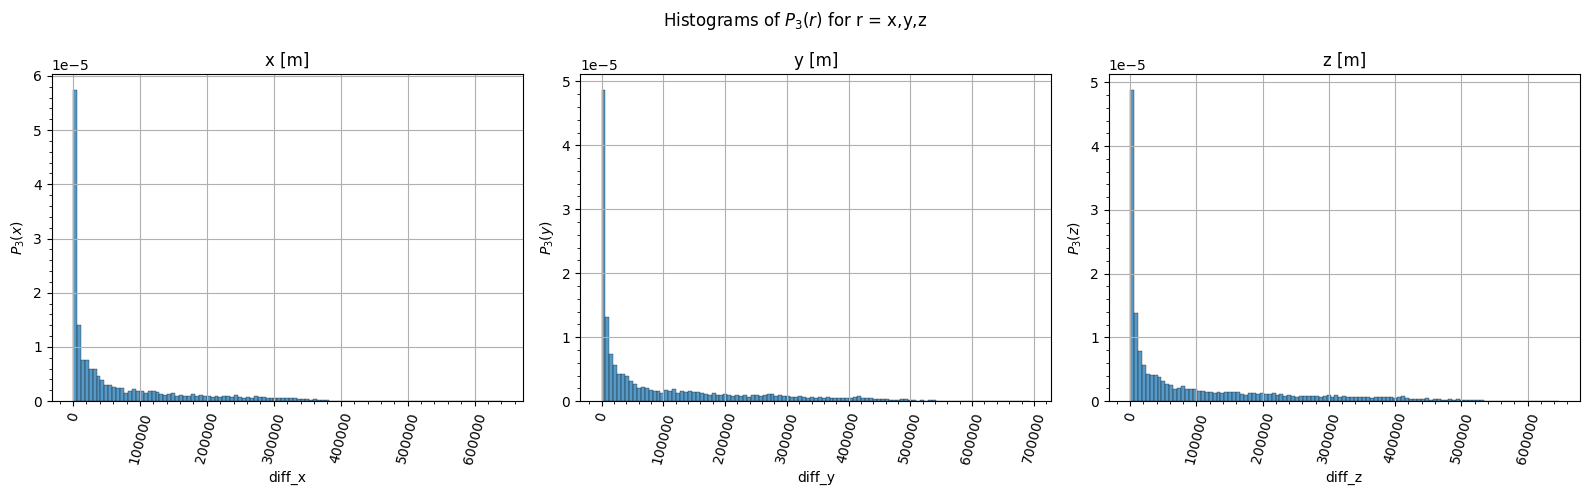

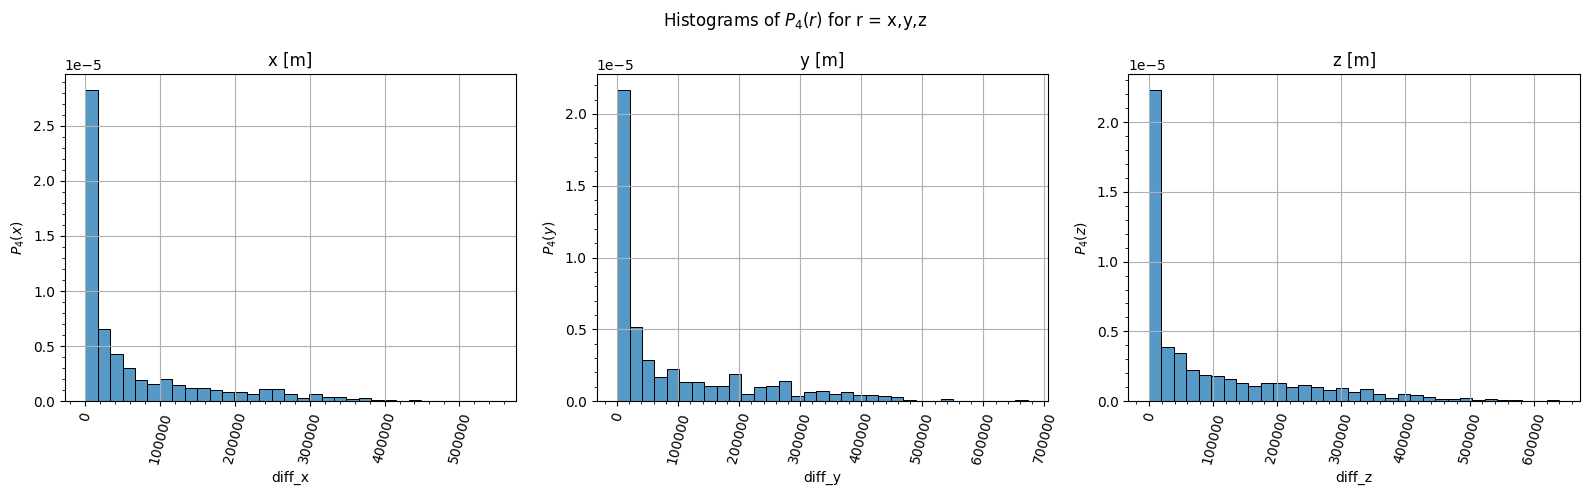

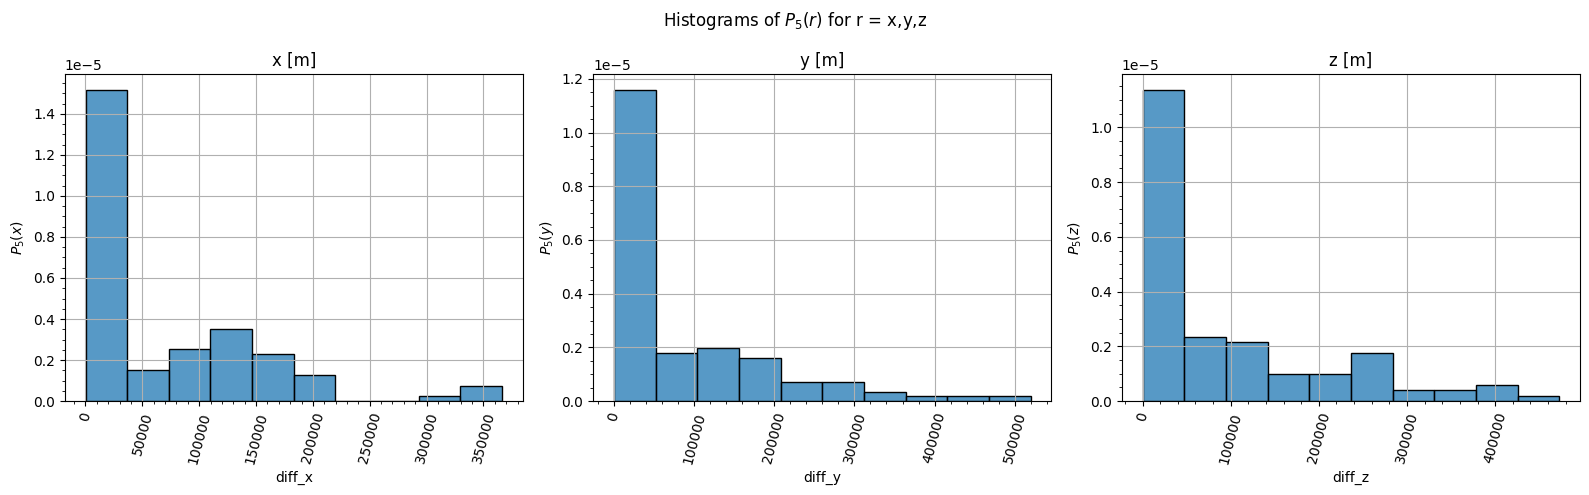

In [80]:
#histograms of the Pm(r)

## results for m = 2 ##
mod_dfm2 = df.copy()
mod_dfm2 = mod_dfm2[mod_dfm2['Magnitude'] >= 2]
mod_dfm2['diff_x'] = abs(mod_dfm2['x [m]'].diff())
mod_dfm2['diff_y'] = abs(mod_dfm2['y [m]'].diff())
mod_dfm2['diff_z'] = abs(mod_dfm2['z [m]'].diff())
mod_dfm2['r'] = np.sqrt(mod_dfm2['diff_x']**2 + mod_dfm2['diff_y']**2 + mod_dfm2['diff_z']**2 )
mod_dfm2 = mod_dfm2.dropna()

fig2, axs2 = plt.subplots(1, 3, figsize=(16, 5))
fig2.suptitle('Histograms of $P_2(r)$ for r = x,y,z')

bins_2 = int(np.sqrt(mod_dfm2['diff_x'].shape[0]))

sns.histplot(data = mod_dfm2, x="diff_x", stat = "density", kde = False, bins = bins_2, ax = axs2[0])
axs2[0].set_title("x [m]")
axs2[0].set_ylabel('$P_2(x)$')
axs2[0].tick_params(axis='x', labelrotation = 75)
axs2[0].grid()
axs2[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axs2[0].yaxis.set_minor_locator(AutoMinorLocator(4))


sns.histplot(data = mod_dfm2, x="diff_y", stat = "density", kde = False, bins = bins_2, ax = axs2[1])
axs2[1].set_title("y [m]")
axs2[1].set_ylabel('$P_2(y)$')
axs2[1].tick_params(axis='x', labelrotation = 75)
axs2[1].grid()
axs2[1].xaxis.set_minor_locator(AutoMinorLocator(5))
axs2[1].yaxis.set_minor_locator(AutoMinorLocator(4))


sns.histplot(data = mod_dfm2, x="diff_z", stat = "density", kde = False, bins = bins_2, ax = axs2[2])
axs2[2].set_title("z [m]")
axs2[2].set_ylabel('$P_2(z)$')
axs2[2].tick_params(axis='x', labelrotation = 75)
axs2[2].grid()
axs2[2].xaxis.set_minor_locator(AutoMinorLocator(5))
axs2[2].yaxis.set_minor_locator(AutoMinorLocator(5))

plt.tight_layout()

## results for m = 3 ##
mod_dfm3 = df.copy()
mod_dfm3 = mod_dfm3[mod_dfm3['Magnitude'] >= 3]
mod_dfm3['diff_x'] = abs(mod_dfm3['x [m]'].diff())
mod_dfm3['diff_y'] = abs(mod_dfm3['y [m]'].diff())
mod_dfm3['diff_z'] = abs(mod_dfm3['z [m]'].diff())
mod_dfm3['r'] = np.sqrt(mod_dfm3['diff_x']**2 + mod_dfm3['diff_y']**2 + mod_dfm3['diff_z']**2 )
mod_dfm3 = mod_dfm3.dropna()

fig3, axs3 = plt.subplots(1, 3, figsize=(16, 5))
fig3.suptitle('Histograms of $P_3(r)$ for r = x,y,z')

bins_3 = int(np.sqrt(mod_dfm3['diff_x'].shape[0]))

sns.histplot(data = mod_dfm3, x="diff_x", stat = "density", kde = False, bins = bins_3, ax = axs3[0])
axs3[0].set_title("x [m]")
axs3[0].set_ylabel('$P_3(x)$')
axs3[0].tick_params(axis='x', labelrotation = 75)
axs3[0].grid()
axs3[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axs3[0].yaxis.set_minor_locator(AutoMinorLocator(5))


sns.histplot(data = mod_dfm3, x="diff_y", stat = "density", kde = False, bins = bins_3, ax = axs3[1])
axs3[1].set_title("y [m]")
axs3[1].set_ylabel('$P_3(y)$')
axs3[1].tick_params(axis='x', labelrotation = 75)
axs3[1].grid()
axs3[1].xaxis.set_minor_locator(AutoMinorLocator(5))
axs3[1].yaxis.set_minor_locator(AutoMinorLocator(5))

sns.histplot(data = mod_dfm3, x="diff_z", stat = "density", kde = False, bins = bins_3, ax = axs3[2])
axs3[2].set_title("z [m]")
axs3[2].set_ylabel('$P_3(z)$')
axs3[2].tick_params(axis='x', labelrotation = 75)
axs3[2].grid()
axs3[2].xaxis.set_minor_locator(AutoMinorLocator(5))
axs3[2].yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tight_layout()


## results for m = 4 ##
mod_dfm4 = df.copy()
mod_dfm4 = mod_dfm4[mod_dfm4['Magnitude'] >= 4]
mod_dfm4['diff_x'] = abs(mod_dfm4['x [m]'].diff())
mod_dfm4['diff_y'] = abs(mod_dfm4['y [m]'].diff())
mod_dfm4['diff_z'] = abs(mod_dfm4['z [m]'].diff())
mod_dfm4['r'] = np.sqrt(mod_dfm4['diff_x']**2 + mod_dfm4['diff_y']**2 + mod_dfm4['diff_z']**2 )
mod_dfm4 = mod_dfm4.dropna()

fig4, axs4 = plt.subplots(1, 3, figsize=(16, 5))
fig4.suptitle('Histograms of $P_4(r)$ for r = x,y,z')

bins_4 = int(np.sqrt(mod_dfm4['diff_x'].shape[0]))

sns.histplot(data = mod_dfm4, x="diff_x", stat = "density", kde = False, bins = bins_4, ax = axs4[0])
axs4[0].set_title("x [m]")
axs4[0].set_ylabel('$P_4(x)$')
axs4[0].tick_params(axis='x', labelrotation = 75)
axs4[0].grid()
axs4[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axs4[0].yaxis.set_minor_locator(AutoMinorLocator(5))


sns.histplot(data = mod_dfm4, x="diff_y", stat = "density", kde = False, bins = bins_4, ax = axs4[1])
axs4[1].set_title("y [m]")
axs4[1].set_ylabel('$P_4(y)$')
axs4[1].tick_params(axis='x', labelrotation = 75)
axs4[1].grid()
axs4[1].xaxis.set_minor_locator(AutoMinorLocator(5))
axs4[1].yaxis.set_minor_locator(AutoMinorLocator(5))


sns.histplot(data = mod_dfm4, x="diff_z", stat = "density", kde = False, bins = bins_4, ax = axs4[2])
#axs4[2].lines[0].set_color('crimson')
axs4[2].set_title("z [m]")
axs4[2].set_ylabel('$P_4(z)$')
axs4[2].tick_params(axis='x', labelrotation = 75)
plt.tight_layout()
axs4[2].grid()
axs4[2].xaxis.set_minor_locator(AutoMinorLocator(5))
axs4[2].yaxis.set_minor_locator(AutoMinorLocator(5))


## results for m = 5 ##
mod_dfm5 = df.copy()
mod_dfm5 = mod_dfm5[mod_dfm5['Magnitude'] >= 5]
mod_dfm5['diff_x'] = abs(mod_dfm5['x [m]'].diff())
mod_dfm5['diff_y'] = abs(mod_dfm5['y [m]'].diff())
mod_dfm5['diff_z'] = abs(mod_dfm5['z [m]'].diff())
mod_dfm5['r'] = np.sqrt(mod_dfm5['diff_x']**2 + mod_dfm5['diff_y']**2 + mod_dfm5['diff_z']**2 )
mod_dfm5 = mod_dfm5.dropna()

fig5, axs5 = plt.subplots(1, 3, figsize=(16, 5))
fig5.suptitle('Histograms of $P_5(r)$ for r = x,y,z')

bins_5 = int(np.sqrt(mod_dfm5['diff_x'].shape[0]))

sns.histplot(data = mod_dfm5, x="diff_x", stat = "density", kde = False, bins = bins_5, ax = axs5[0])
axs5[0].set_title("x [m]")
axs5[0].set_ylabel('$P_5(x)$')
axs5[0].tick_params(axis='x', labelrotation = 75)
axs5[0].grid()
axs5[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axs5[0].yaxis.set_minor_locator(AutoMinorLocator(4))

sns.histplot(data = mod_dfm5, x="diff_y", stat = "density", kde = False, bins = bins_5, ax = axs5[1])
axs5[1].set_title("y [m]")
axs5[1].set_ylabel('$P_5(y)$')
axs5[1].tick_params(axis='x', labelrotation = 75)
axs5[1].grid()
axs5[1].xaxis.set_minor_locator(AutoMinorLocator(5))
axs5[1].yaxis.set_minor_locator(AutoMinorLocator(4))

a = sns.histplot(data = mod_dfm5, x="diff_z", stat = "density", kde = False, bins = bins_5, ax = axs5[2])
axs5[2].set_title("z [m]")
axs5[2].set_ylabel('$P_5(z)$')
axs5[2].tick_params(axis='x', labelrotation = 75)
axs5[2].grid()
axs5[2].xaxis.set_minor_locator(AutoMinorLocator(5))
axs5[2].yaxis.set_minor_locator(AutoMinorLocator(4))

plt.tight_layout()





## 3.2) Distribution  $P_m(r)$
In this part, we took $r$ as the euclidian distances beween the different spatial coordiantes $ r = \sqrt {x^2 +y^2 + z^2  }$.


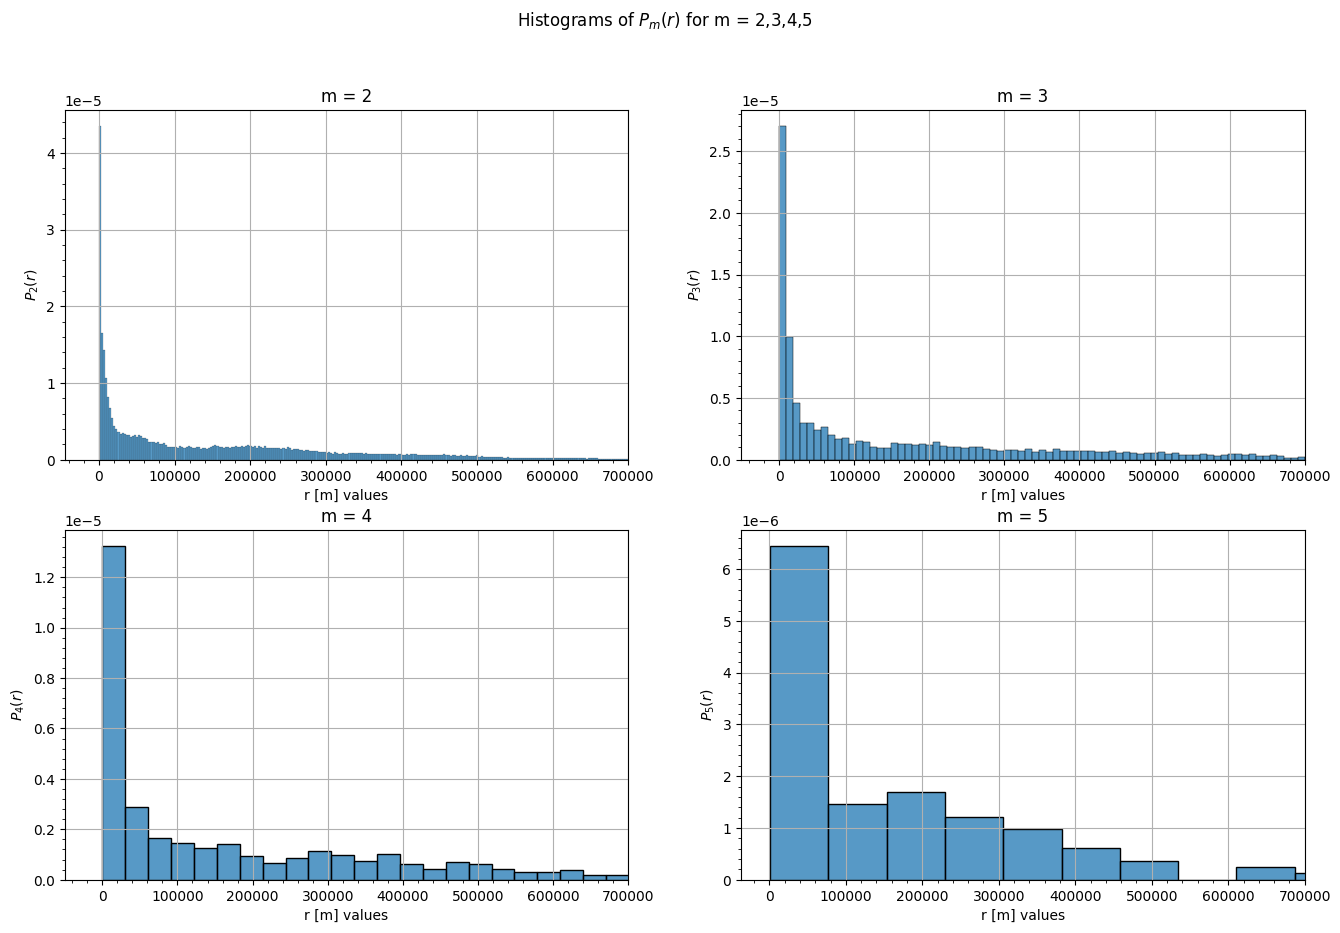

In [81]:
figr, axsr = plt.subplots(2, 2, figsize=(16, 10))
figr.suptitle('Histograms of $P_m(r)$ for m = 2,3,4,5')

sns.histplot(data = mod_dfm2, x="r", stat = "density", kde = False, bins = bins_2, ax = axsr[0][0])
axsr[0][0].set_title("m = 2")
axsr[0][0].set_xlabel('r [m] values')
axsr[0][0].set_xlim(right = 0.7e6)
axsr[0][0].set_ylabel('$P_2(r)$')
axsr[0][0].grid()
axsr[0][0].xaxis.set_minor_locator(AutoMinorLocator(5))
axsr[0][0].yaxis.set_minor_locator(AutoMinorLocator(5))

sns.histplot(data = mod_dfm3, x="r", stat = "density", kde = False, bins = bins_3, ax = axsr[0][1])
axsr[0][1].set_title("m = 3")
axsr[0][1].set_xlabel('r [m] values')
axsr[0][1].set_xlim(right = 0.7e6)
axsr[0][1].set_ylabel('$P_3(r)$')
axsr[0][1].grid()
axsr[0][1].xaxis.set_minor_locator(AutoMinorLocator(5))
axsr[0][1].yaxis.set_minor_locator(AutoMinorLocator(5))

sns.histplot(data = mod_dfm4, x="r", stat = "density", kde = False, bins = bins_4, ax = axsr[1][0])
axsr[1][0].set_title("m = 4")
axsr[1][0].set_xlabel('r [m] values')
axsr[1][0].set_xlim(right = 0.7e6)
axsr[1][0].set_ylabel('$P_4(r)$')
axsr[1][0].grid()
axsr[1][0].xaxis.set_minor_locator(AutoMinorLocator(5))
axsr[1][0].yaxis.set_minor_locator(AutoMinorLocator(5))

sns.histplot(data = mod_dfm5, x="r", stat = "density", kde = False, bins = bins_5, ax = axsr[1][1])
axsr[1][1].set_title("m = 5")
axsr[1][1].set_xlabel('r [m] values')
axsr[1][1].set_xlim(right = 0.7e6)
axsr[1][1].set_ylabel('$P_5(r)$')
axsr[1][1].grid()
#axsr[1][1].xaxis.set_major_locator(MultipleLocator(0.2e6))
axsr[1][1].xaxis.set_minor_locator(AutoMinorLocator(5))
#axsr[1][1].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axsr[1][1].yaxis.set_minor_locator(AutoMinorLocator(5))

From the data distrubution one can understand that for higher magnitude are less frequent. In fact the entries that regards the distances between the events of higher magnitude are lower, and the binning size enlanrges as well.




## 3.3) Power-law fitting

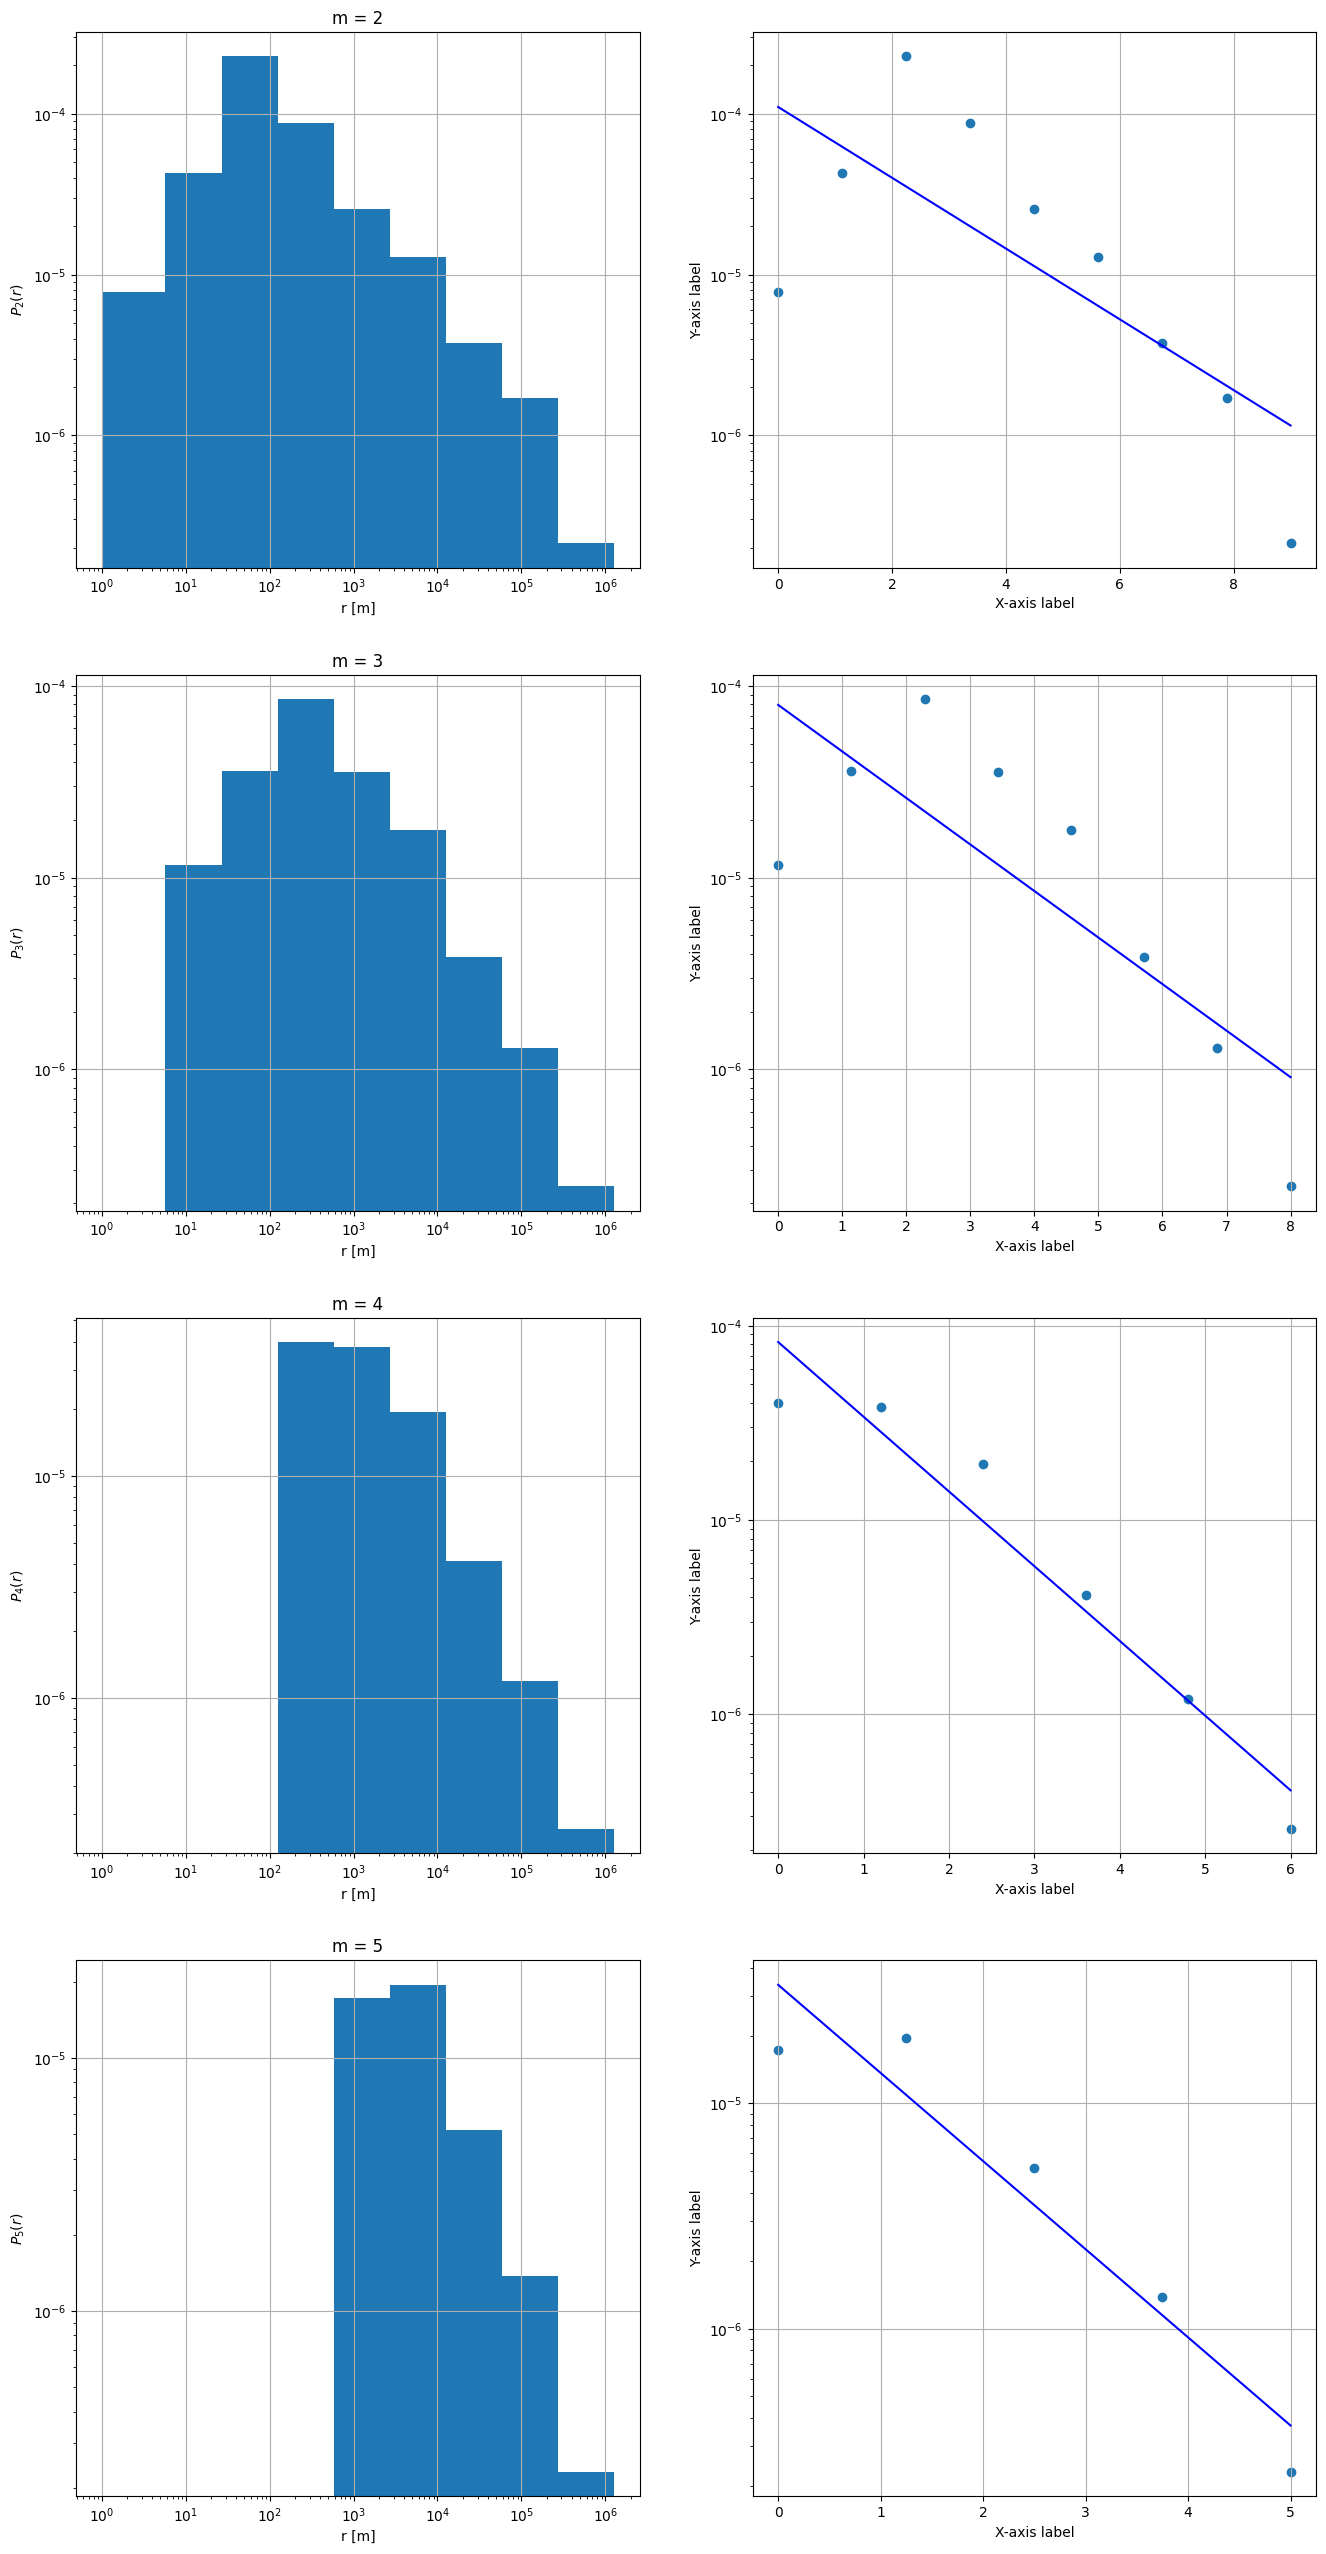

In [82]:
figs, axs = plt.subplots(4, 2, figsize=(16, 32))


num_bins2_log = np.logspace(0, 6, bins_5)
x_bins2 = np.cumsum(num_bins2_log)
counts_log, bin_edges_log, _ = axs[0, 0].hist(mod_dfm2['r'], bins=x_bins2, density=True)
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].grid()
axs[0, 0].set_title("m = 2")
axs[0, 0].set_ylabel('$P_{2}(r)$')
axs[0, 0].set_xlabel('r [m]')

counts_log = counts_log[counts_log>0]
space = np.linspace(0, len(counts_log), len(counts_log))

axs[0, 1].scatter(space, counts_log)

# Define the linear fitting function
def f1(x, a0, a1):
    return a0 + a1 * x

# Using log of counts for fitting
(fa0, fa1), cov = scipy.optimize.curve_fit(f1, space, np.log(counts_log))
y1 = f1(space, fa0, fa1)

# Taking exp to revert back from log scale
axs[0, 1].plot(space, np.exp(y1), color='blue', label="linear")
axs[0, 1].set_yscale('log')
axs[0, 1].set_xlabel('X-axis label')
axs[0, 1].set_ylabel('Y-axis label')
axs[0, 1].grid()



#m = 3

num_bins3_log = np.logspace(0, 6, bins_5)
x_bins3 = np.cumsum(num_bins3_log)
counts_log, bin_edges_log, _ = axs[1, 0].hist(mod_dfm3['r'], bins=x_bins3, density=True)
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].grid()
axs[1, 0].set_title("m = 3")
axs[1, 0].set_ylabel('$P_{3}(r)$')
axs[1, 0].set_xlabel('r [m]')

counts_log = counts_log[counts_log>0]
space = np.linspace(0, len(counts_log), len(counts_log))

axs[1, 1].scatter(space, counts_log)

# Define the linear fitting function
def f1(x, a0, a1):
    return a0 + a1 * x

# Using log of counts for fitting
(fa0, fa1), cov = scipy.optimize.curve_fit(f1, space, np.log(counts_log))
y1 = f1(space, fa0, fa1)

# Taking exp to revert back from log scale
axs[1, 1].plot(space, np.exp(y1), color='blue', label="linear")
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('X-axis label')
axs[1, 1].set_ylabel('Y-axis label')
axs[1, 1].grid()



#m = 4

num_bins4_log = np.logspace(0, 6, bins_5)
x_bins4 = np.cumsum(num_bins4_log)
counts_log, bin_edges_log, _ = axs[2, 0].hist(mod_dfm4['r'], bins=x_bins4, density=True)
axs[2, 0].set_xscale('log')
axs[2, 0].set_yscale('log')
axs[2, 0].grid()
axs[2, 0].set_title("m = 4")
axs[2, 0].set_ylabel('$P_{4}(r)$')
axs[2, 0].set_xlabel('r [m]')

counts_log = counts_log[counts_log>0]
space = np.linspace(0, len(counts_log), len(counts_log))

axs[2, 1].scatter(space, counts_log)

# Define the linear fitting function
def f1(x, a0, a1):
    return a0 + a1 * x

# Using log of counts for fitting
(fa0, fa1), cov = scipy.optimize.curve_fit(f1, space, np.log(counts_log))
y1 = f1(space, fa0, fa1)

# Taking exp to revert back from log scale
axs[2, 1].plot(space, np.exp(y1), color='blue', label="linear")
axs[2, 1].set_yscale('log')
axs[2, 1].set_xlabel('X-axis label')
axs[2, 1].set_ylabel('Y-axis label')
axs[2, 1].grid()



#m = 5

num_bins5_log = np.logspace(0, 6, bins_5)
x_bins5 = np.cumsum(num_bins5_log)
counts_log, bin_edges_log, _ = axs[3, 0].hist(mod_dfm5['r'], bins=x_bins5, density=True)
axs[3, 0].set_xscale('log')
axs[3, 0].set_yscale('log')
axs[3, 0].grid()
axs[3, 0].set_title("m = 5")
axs[3, 0].set_ylabel('$P_{5}(r)$')
axs[3, 0].set_xlabel('r [m]')

counts_log = counts_log[counts_log>0]
space = np.linspace(0, len(counts_log), len(counts_log))

axs[3, 1].scatter(space, counts_log)

# Define the linear fitting function
def f1(x, a0, a1):
    return a0 + a1 * x

# Using log of counts for fitting
(fa0, fa1), cov = scipy.optimize.curve_fit(f1, space, np.log(counts_log))
y1 = f1(space, fa0, fa1)

# Taking exp to revert back from log scale
axs[3, 1].plot(space, np.exp(y1), color='blue', label="linear")
axs[3, 1].set_yscale('log')
axs[3, 1].set_xlabel('X-axis label')
axs[3, 1].set_ylabel('Y-axis label')
axs[3, 1].grid()



In [83]:
#m = 5

num_bins5_log = np.logspace(0, 6, bins_5)
x_bins5 = np.cumsum(num_bins5_log)
counts_log, bin_edges_log, _ = axs[3, 0].hist(mod_dfm5['r'], bins=x_bins5, density=True)
axs[3, 0].set_xscale('log')
axs[3, 0].set_yscale('log')
axs[3, 0].grid()
axs[3, 0].set_title("m = 5")
axs[3, 0].set_ylabel('$P_{5}(r)$')
axs[3, 0].set_xlabel('r [m]')

counts_log = counts_log[counts_log>0]
space = np.linspace(0, len(counts_log), len(counts_log))

axs[3, 1].scatter(space, counts_log)

# Define the linear fitting function
def f1(x, a0, a1):
    return a0 + a1 * x

# Using log of counts for fitting
(fa0, fa1), cov = scipy.optimize.curve_fit(f1, space, np.log(counts_log))
y1 = f1(space, fa0, fa1)

# Taking exp to revert back from log scale
axs[3, 1].plot(space, np.exp(y1), color='blue', label="linear")
axs[3, 1].set_yscale('log')
axs[3, 1].set_xlabel('X-axis label')
axs[3, 1].set_ylabel('Y-axis label')

Text(703.8261363636362, 0.5, 'Y-axis label')

###3.4 ) Computing the KDE distribution
The Kernel density distribution is a way to estimate the probability density function of a random variable in a non-parametric way.

The bandwidth selection strongly influences the estimate obtained from the KDE: using a small bandwidth value can lead to over-fitting while using a large bandwidth value may result in under-fitting.


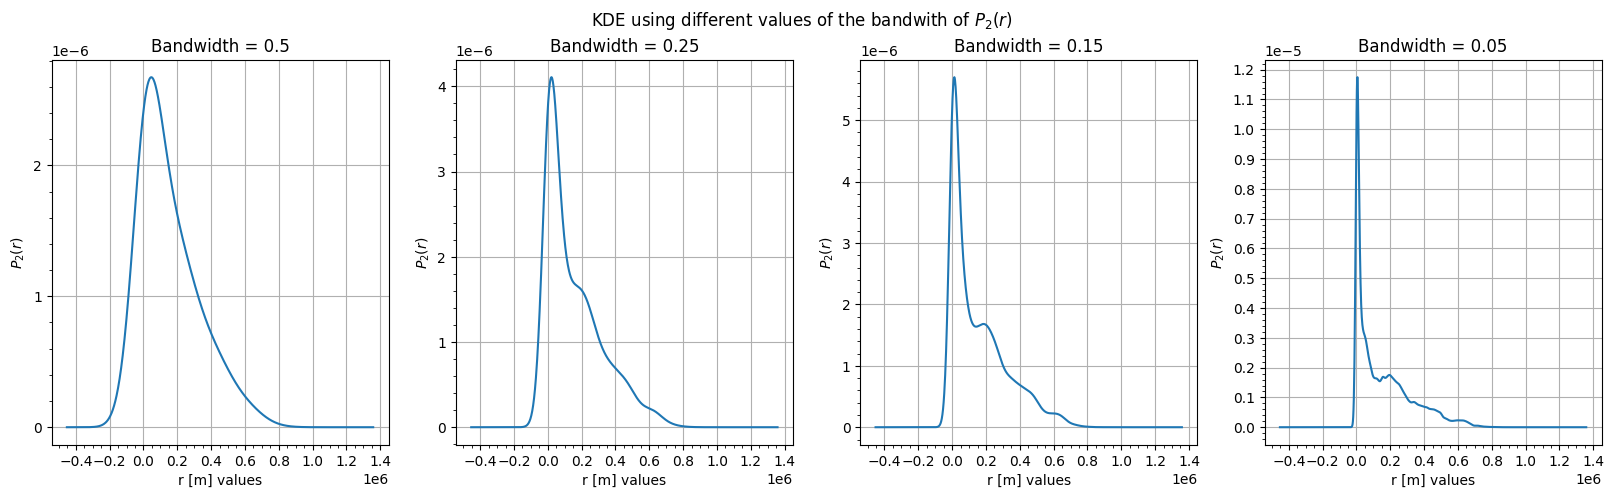

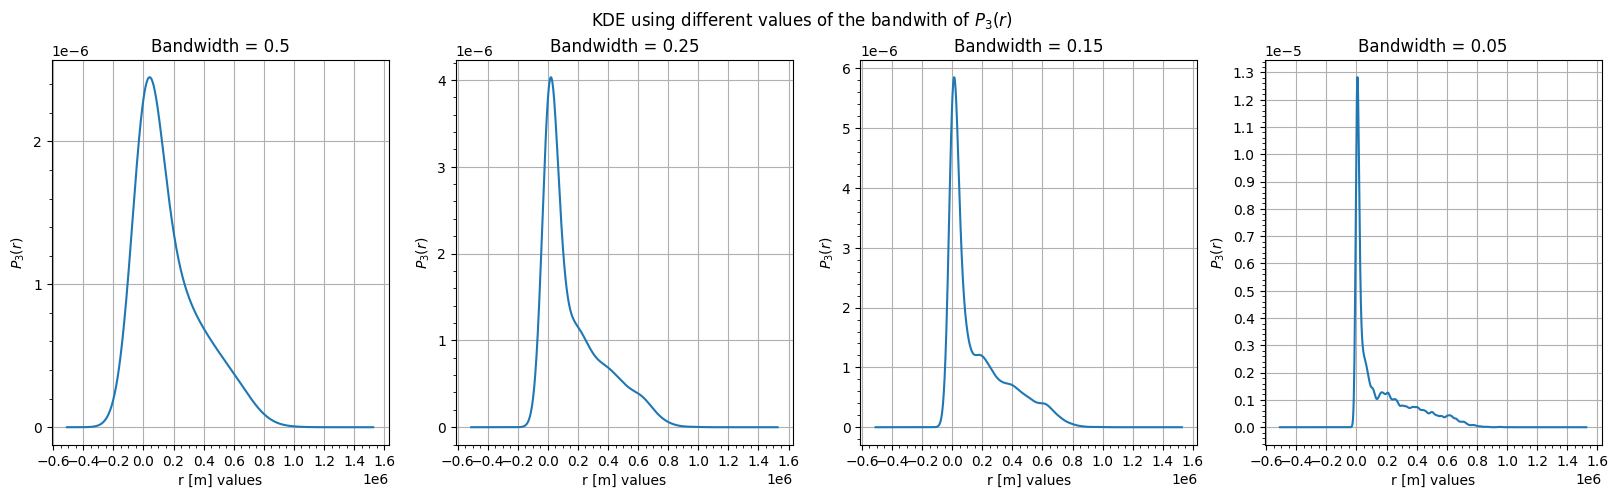

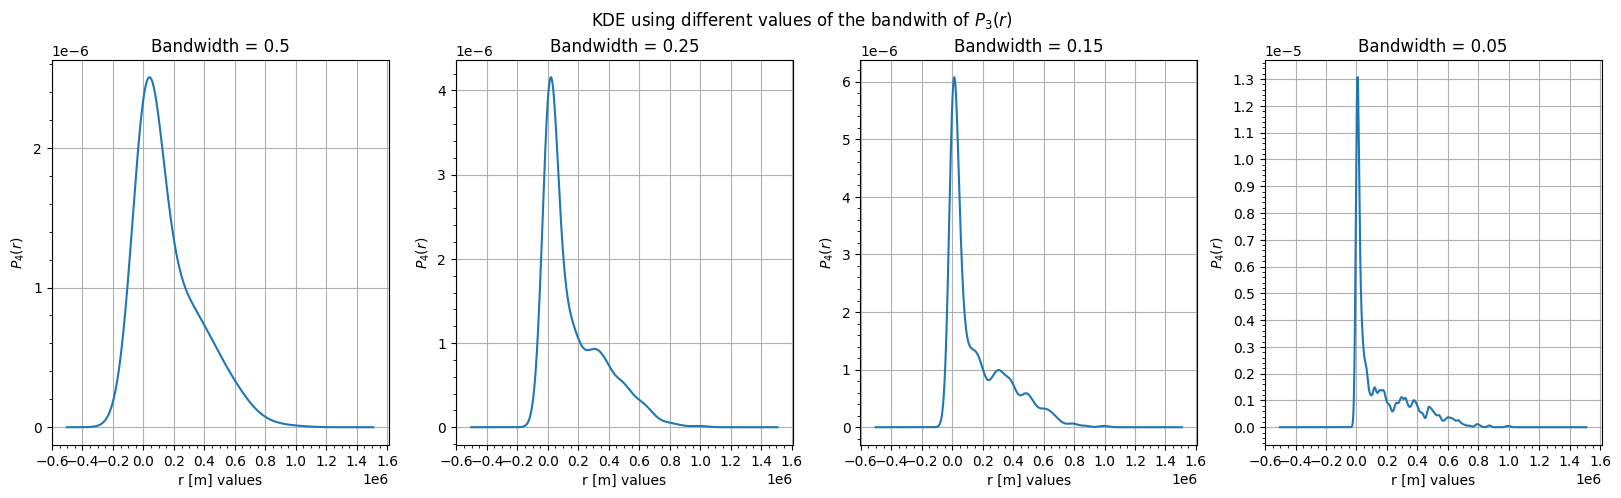

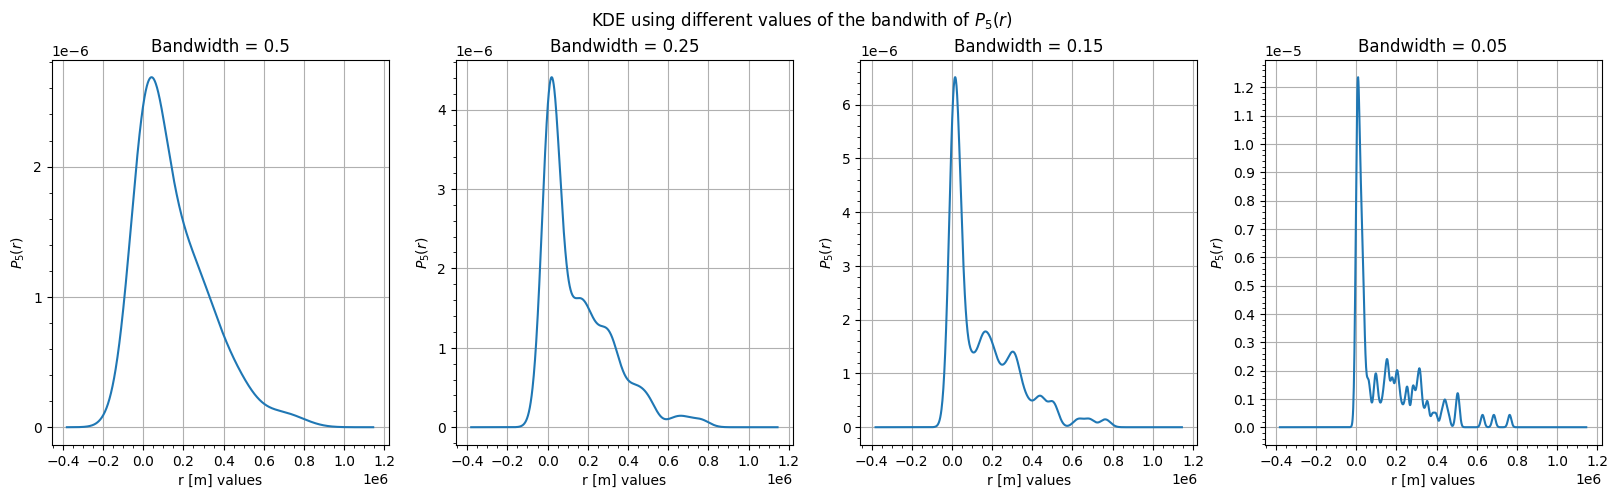

In [84]:
#comparing different values for the bandwidth

#bandwidth estimation example for m = 2

fig_testB, axs_testB = plt.subplots(1, 4, figsize=(20, 5))
fig_testB.suptitle('KDE using different values of the bandwith of $P_2(r)$')

# using b = 0.5
kde_m2_b1 = mod_dfm2['r'].plot.kde(ax =axs_testB[0], bw_method = 0.5)
axs_testB[0].set_title("Bandwidth = 0.5")
axs_testB[0].set_xlabel('r [m] values')
axs_testB[0].set_ylabel('$P_2(r)$')
axs_testB[0].grid()
axs_testB[0].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_testB[0].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB[0].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_testB[0].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.25
kde_m2_b2 = mod_dfm2['r'].plot.kde(ax =axs_testB[1], bw_method = 0.25)
axs_testB[1].set_title("Bandwidth = 0.25")
axs_testB[1].set_xlabel('r [m] values')
axs_testB[1].set_ylabel('$P_2(r)$')
axs_testB[1].grid()
axs_testB[1].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_testB[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB[1].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_testB[1].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.15
kde_m2_b3 = mod_dfm2['r'].plot.kde(ax =axs_testB[2], bw_method = 0.15)
axs_testB[2].set_title("Bandwidth = 0.15")
axs_testB[2].set_xlabel('r [m] values')
axs_testB[2].set_ylabel('$P_2(r)$')
axs_testB[2].grid()
axs_testB[2].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_testB[2].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB[2].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_testB[2].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.05
kde_m2_b4 = mod_dfm2['r'].plot.kde(ax =axs_testB[3], bw_method = 0.05)
axs_testB[3].set_title("Bandwidth = 0.05")
axs_testB[3].set_xlabel('r [m] values')
axs_testB[3].set_ylabel('$P_2(r)$')
axs_testB[3].grid()
axs_testB[3].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_testB[3].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB[3].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_testB[3].yaxis.set_minor_locator(AutoMinorLocator(5))


# results for m = 3 #

fig_testB, axs_testB = plt.subplots(1, 4, figsize=(20, 5))
fig_testB.suptitle('KDE using different values of the bandwith of $P_3(r)$')

# using b = 0.5
kde_m3_b1 = mod_dfm3['r'].plot.kde(ax =axs_testB[0], bw_method = 0.5)
axs_testB[0].set_title("Bandwidth = 0.5")
axs_testB[0].set_xlabel('r [m] values')
axs_testB[0].set_ylabel('$P_3(r)$')
axs_testB[0].grid()
axs_testB[0].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_testB[0].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB[0].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_testB[0].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.25
kde_m3_b2 = mod_dfm3['r'].plot.kde(ax =axs_testB[1], bw_method = 0.25)
axs_testB[1].set_title("Bandwidth = 0.25")
axs_testB[1].set_xlabel('r [m] values')
axs_testB[1].set_ylabel('$P_3(r)$')
axs_testB[1].grid()
axs_testB[1].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_testB[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB[1].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_testB[1].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.15
kde_m2_b3 = mod_dfm3['r'].plot.kde(ax =axs_testB[2], bw_method = 0.15)
axs_testB[2].set_title("Bandwidth = 0.15")
axs_testB[2].set_xlabel('r [m] values')
axs_testB[2].set_ylabel('$P_3(r)$')
axs_testB[2].grid()
axs_testB[2].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_testB[2].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB[2].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_testB[2].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.05
kde_m3_b4 = mod_dfm3['r'].plot.kde(ax =axs_testB[3], bw_method = 0.05)
axs_testB[3].set_title("Bandwidth = 0.05")
axs_testB[3].set_xlabel('r [m] values')
axs_testB[3].set_ylabel('$P_3(r)$')
axs_testB[3].grid()
axs_testB[3].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_testB[3].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB[3].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_testB[3].yaxis.set_minor_locator(AutoMinorLocator(5))


# results for m = 4 #

fig_testB, axs_testB = plt.subplots(1, 4, figsize=(20, 5))
fig_testB.suptitle('KDE using different values of the bandwith of $P_3(r)$')

# using b = 0.5
kde_m4_b1 = mod_dfm4['r'].plot.kde(ax =axs_testB[0], bw_method = 0.5)
axs_testB[0].set_title("Bandwidth = 0.5")
axs_testB[0].set_xlabel('r [m] values')
axs_testB[0].set_ylabel('$P_4(r)$')
axs_testB[0].grid()
axs_testB[0].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_testB[0].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB[0].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_testB[0].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.25
kde_m4_b2 = mod_dfm4['r'].plot.kde(ax =axs_testB[1], bw_method = 0.25)
axs_testB[1].set_title("Bandwidth = 0.25")
axs_testB[1].set_xlabel('r [m] values')
axs_testB[1].set_ylabel('$P_4(r)$')
axs_testB[1].grid()
axs_testB[1].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_testB[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB[1].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_testB[1].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.15
kde_m4_b3 = mod_dfm4['r'].plot.kde(ax =axs_testB[2], bw_method = 0.15)
axs_testB[2].set_title("Bandwidth = 0.15")
axs_testB[2].set_xlabel('r [m] values')
axs_testB[2].set_ylabel('$P_4(r)$')
axs_testB[2].grid()
axs_testB[2].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_testB[2].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB[2].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_testB[2].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.05
kde_m4_b4 = mod_dfm4['r'].plot.kde(ax =axs_testB[3], bw_method = 0.05)
axs_testB[3].set_title("Bandwidth = 0.05")
axs_testB[3].set_xlabel('r [m] values')
axs_testB[3].set_ylabel('$P_4(r)$')
axs_testB[3].grid()
axs_testB[3].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_testB[3].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB[3].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_testB[3].yaxis.set_minor_locator(AutoMinorLocator(5))


# results for m = 5 #

fig_testB, axs_testB = plt.subplots(1, 4, figsize=(20, 5))
fig_testB.suptitle('KDE using different values of the bandwith of $P_5(r)$')

# using b = 0.5
kde_m5_b1 = mod_dfm5['r'].plot.kde(ax =axs_testB[0], bw_method = 0.5)
axs_testB[0].set_title("Bandwidth = 0.5")
axs_testB[0].set_xlabel('r [m] values')
axs_testB[0].set_ylabel('$P_5(r)$')
axs_testB[0].grid()
axs_testB[0].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_testB[0].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB[0].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_testB[0].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.25
kde_m5_b2 = mod_dfm5['r'].plot.kde(ax =axs_testB[1], bw_method = 0.25)
axs_testB[1].set_title("Bandwidth = 0.25")
axs_testB[1].set_xlabel('r [m] values')
axs_testB[1].set_ylabel('$P_5(r)$')
axs_testB[1].grid()
axs_testB[1].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_testB[1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB[1].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_testB[1].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.15
kde_m5_b3 = mod_dfm5['r'].plot.kde(ax =axs_testB[2], bw_method = 0.15)
axs_testB[2].set_title("Bandwidth = 0.15")
axs_testB[2].set_xlabel('r [m] values')
axs_testB[2].set_ylabel('$P_5(r)$')
axs_testB[2].grid()
axs_testB[2].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_testB[2].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB[2].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_testB[2].yaxis.set_minor_locator(AutoMinorLocator(5))


# using b = 0.05
kde_m4_b5 = mod_dfm5['r'].plot.kde(ax =axs_testB[3], bw_method = 0.05)
axs_testB[3].set_title("Bandwidth = 0.05")
axs_testB[3].set_xlabel('r [m] values')
axs_testB[3].set_ylabel('$P_5(r)$')
axs_testB[3].grid()
axs_testB[3].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_testB[3].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_testB[3].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_testB[3].yaxis.set_minor_locator(AutoMinorLocator(5))

As it's possible to observe from the graph, using a bandwidth of 0.5 will underfit the data while using a bandwidth of 0.05 will overfit the data.

Among the different methods of selecting the appropriate bandwidth, has been used the "rule of thumb", observing that choosing a bandwidth of 0.15 offers a good compromise.

##3.5) Fitting of the KDE distribution
The data has been fitted exploiting `scipy.optimize.curve_fit` with an exponential function $f(x) = A e^{-Bx}$. As known from theory, the optimal values are obtained by minimizing the sum of the squared residuals.

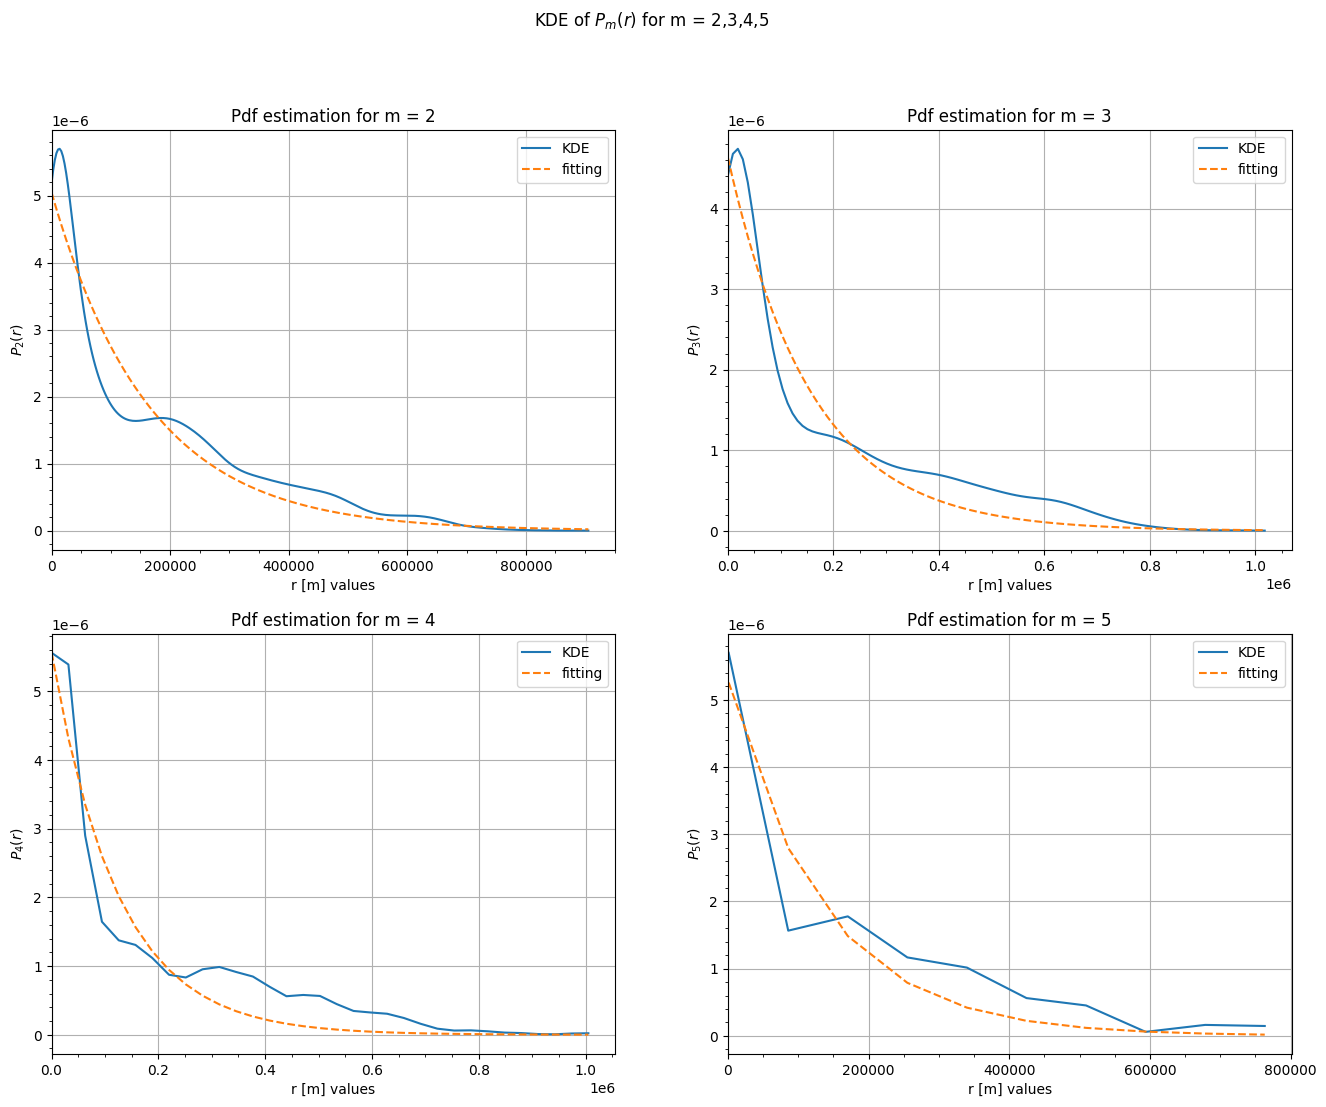

In [85]:
fig_kde, axs_kde = plt.subplots(2, 2, figsize=(16, 12))
fig_kde.suptitle('KDE of $P_m(r)$ for m = 2,3,4,5')


# results for m = 2 #

bw2 = 0.15

#create the kde estimation
kde_m2_obj = scipy.stats.gaussian_kde(mod_dfm2['r'], bw_method=bw2)

#evaluating the kde
x_m2 = np.linspace(mod_dfm2['r'].min(), mod_dfm2['r'].max(),  int(math.sqrt(len(mod_dfm2['r'])))  )
kde_function_m2 = kde_m2_obj.evaluate(x_m2)

#plotting the estimated kde
axs_kde[0][0].plot(x_m2,kde_function_m2)

#defining the function to fit
def func(t, a, b):
    return a * np.exp(- b * t)

popt_m2, pcov_m2 = scipy.optimize.curve_fit(func, x_m2, kde_function_m2, p0 = [0,6e-6])

#plotting the estimated function
pdf_fitting_m2 = func(x_m2,popt_m2[0],popt_m2[1])
axs_kde[0][0].plot(x_m2,pdf_fitting_m2, '--')

axs_kde[0][0].set_title("Pdf estimation for m = 2")
axs_kde[0][0].set_ylabel('$P_2(r)$')
axs_kde[0][0].set_xlabel('r [m] values')
axs_kde[0][0].legend(["KDE","fitting"])
axs_kde[0][0].grid()
axs_kde[0][0].set_xlim(left = 0)
axs_kde[0][0].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_kde[0][0].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_kde[0][0].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_kde[0][0].yaxis.set_minor_locator(AutoMinorLocator(5))


# results for m = 3 #

bw3 = 0.2

#create the kde estimation
kde_m3_obj = scipy.stats.gaussian_kde(mod_dfm3['r'], bw_method=bw3)

#evaluating the kde
x_m3 = np.linspace(mod_dfm3['r'].min(), mod_dfm3['r'].max(), int(math.sqrt(len(mod_dfm3['r']))) )
kde_function_m3 = kde_m3_obj.evaluate(x_m3)

#plotting the estimated kde
axs_kde[0][1].plot(x_m3,kde_function_m3)

#defining the function to fit
def func(t, a, b):
    return a * np.exp(- b * t)

popt_m3, pcov_m3 = scipy.optimize.curve_fit(func, x_m3, kde_function_m3, p0 = [0,6e-6])

#plotting the estimated function
pdf_fitting_m3 = func(x_m3,popt_m3[0],popt_m3[1])
axs_kde[0][1].plot(x_m3,pdf_fitting_m3, '--')

axs_kde[0][1].set_title("Pdf estimation for m = 3")
axs_kde[0][1].set_ylabel('$P_3(r)$')
axs_kde[0][1].set_xlabel('r [m] values')
axs_kde[0][1].legend(["KDE","fitting"])
axs_kde[0][1].grid()
axs_kde[0][1].set_xlim(left = 0)
axs_kde[0][1].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_kde[0][1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_kde[0][1].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_kde[0][1].yaxis.set_minor_locator(AutoMinorLocator(5))


# results for m = 4 #

bw4 = 0.15

#create the kde estimation
kde_m4_obj = scipy.stats.gaussian_kde(mod_dfm4['r'], bw_method=bw4)

#evaluating the kde
x_m4 = np.linspace(mod_dfm4['r'].min(), mod_dfm4['r'].max(), int(np.sqrt(len(mod_dfm4['r']))) )
kde_function_m4 = kde_m4_obj.evaluate(x_m4)

#plotting the estimated kde
axs_kde[1][0].plot(x_m4,kde_function_m4)

#defining the function to fit
def func(t, a, b):
    return a * np.exp(- b * t)

popt_m4, pcov_m4 = scipy.optimize.curve_fit(func, x_m4, kde_function_m4, p0 = [0,6e-6])

#plotting the estimated function
pdf_fitting_m4 = func(x_m4,popt_m4[0],popt_m4[1])
axs_kde[1][0].plot(x_m4,pdf_fitting_m4, '--')

axs_kde[1][0].set_title("Pdf estimation for m = 4")
axs_kde[1][0].set_ylabel('$P_4(r)$')
axs_kde[1][0].set_xlabel('r [m] values')
axs_kde[1][0].legend(["KDE","fitting"])
axs_kde[1][0].grid()
axs_kde[1][0].set_xlim(left = 0)
axs_kde[1][0].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_kde[1][0].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_kde[1][0].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_kde[1][0].yaxis.set_minor_locator(AutoMinorLocator(5))


# results for m = 5 #

bw5 = 0.15

#create the kde estimation
kde_m5_obj = scipy.stats.gaussian_kde(mod_dfm5['r'], bw_method=bw5)

#evaluating the kde
x_m5 = np.linspace(mod_dfm5['r'].min(), mod_dfm5['r'].max(), int(math.sqrt(len(mod_dfm5['r']))) )
kde_function_m5 = kde_m5_obj.evaluate(x_m5)

#plotting the estimated kde
axs_kde[1][1].plot(x_m5,kde_function_m5)

#defining the function to fit
def func(t, a, b):
    return a * np.exp(- b * t)

popt_m5, pcov_m5 = scipy.optimize.curve_fit(func, x_m5, kde_function_m5, p0 = [200000,1.8e-6])

#plotting the estimated function
pdf_fitting_m5 = func(x_m5,popt_m5[0],popt_m5[1])
axs_kde[1][1].plot(x_m5,pdf_fitting_m5, '--')

axs_kde[1][1].set_title("Pdf estimation for m = 5")
axs_kde[1][1].set_ylabel('$P_5(r)$')
axs_kde[1][1].set_xlabel('r [m] values')
axs_kde[1][1].legend(["KDE","fitting"])
axs_kde[1][1].grid()
axs_kde[1][1].set_xlim(left = 0)
axs_kde[1][1].xaxis.set_major_locator(MultipleLocator(0.2e6))
axs_kde[1][1].xaxis.set_minor_locator(AutoMinorLocator(4))
axs_kde[1][1].yaxis.set_major_locator(MultipleLocator(0.1e-5))
axs_kde[1][1].yaxis.set_minor_locator(AutoMinorLocator(5))


The coefficients obtained from the fittings and their variance are:

In [86]:
#values obtained from the fitting
print("Results of the fittings: \n")
print("For m = 2: ")
print("A = %.2e +- %.2e" % (popt_m2[0], np.sqrt(pcov_m2[0,0])))
print("B = %.2e +- %.2e" % (popt_m2[1], np.sqrt(pcov_m2[1,1])))
print("\n")

print("For m = 3: ")
print("A = %.2e +- %.2e" % (popt_m3[0], np.sqrt(pcov_m3[0,0])))
print("B = %.2e +- %.2e" % (popt_m3[1], np.sqrt(pcov_m3[1,1])))
print("\n")

print("For m = 4: ")
print("A = %.2e +- %.2e" % (popt_m4[0], np.sqrt(pcov_m4[0,0])))
print("B = %.2e +- %.2e" % (popt_m4[1], np.sqrt(pcov_m4[1,1])))
print("\n")

print("For m = 5: ")
print("A = %.2e +- %.2e" % (popt_m5[0], np.sqrt(pcov_m5[0,0])))
print("B = %.2e +- %.2e" % (popt_m5[1], np.sqrt(pcov_m5[1,1])))
print("\n")

Results of the fittings: 

For m = 2: 
A = 5.05e-06 +- 8.39e-08
B = 6.08e-06 +- 1.44e-07


For m = 3: 
A = 4.63e-06 +- 1.32e-07
B = 6.29e-06 +- 2.61e-07


For m = 4: 
A = 5.56e-06 +- 3.26e-07
B = 8.06e-06 +- 7.55e-07


For m = 5: 
A = 5.30e-06 +- 5.50e-07
B = 7.46e-06 +- 1.45e-06




At this point, has been performed the goodness of fit using the $\chi^2$ to verify if the sample data is consistent with the predicted model.

In [87]:
p = np.arange(0, 40, 0.1)

#results for m = 2
ndof_m2 = len(x_m2) - 1

# calculate the chi^2
chi2_m2 = np.sum(((kde_function_m2 - pdf_fitting_m2)**2) / np.std(kde_function_m2)**2)
print("chi2 =", chi2_m2)

# calculate the p-value from the chi^2, the n.d.o.f., and the cumulative chi^2 distribution
pvalue_2m = 1. - scipy.stats.chi2.cdf(chi2_m2, ndof_m2)
print("p-value =", pvalue_2m)


#results for m = 3
ndof_m3 = len(x_m3) - 1

# calculate the chi^2
chi2_m3 = np.sum(((kde_function_m3 - pdf_fitting_m3)**2) / np.std(kde_function_m3)**2)
print("chi2 =", chi2_m3)

# calculate the p-value from the chi^2, the n.d.o.f., and the cumulative chi^2 distribution
pvalue_m3 = 1. - scipy.stats.chi2.cdf(chi2_m3, ndof_m3)
print("p-value =", pvalue_m3)


#results for m = 4
ndof_m4 = len(x_m4) - 1

# calculate the chi^2
chi2_m4 = np.sum(((kde_function_m4 - pdf_fitting_m4)**2) / np.std(kde_function_m4)**2)
print("chi2 =", chi2_m4)

# calculate the p-value from the chi^2, the n.d.o.f., and the cumulative chi^2 distribution
pvalue_m4 = 1. - scipy.stats.chi2.cdf(chi2_m4, ndof_m4)
print("p-value =", pvalue_m4)

#results for m = 5
ndof_m5 = len(x_m5) - 1

# calculate the chi^2
chi2_m5 = np.sum(((kde_function_m5 - pdf_fitting_m5)**2) / np.std(kde_function_m5)**2)
print("chi2 =", chi2_m5)

# calculate the p-value from the chi^2, the n.d.o.f., and the cumulative chi^2 distribution
pvalue_m5 = 1. - (scipy.stats.chi2.cdf(chi2_m5, ndof_m5))
print("p-value =", pvalue_m5)

chi2 = 23.75759102385399
p-value = 1.0
chi2 = 7.5451740741309195
p-value = 1.0
chi2 = 2.9982080171497225
p-value = 0.9999999999923879
chi2 = 1.0127538457310064
p-value = 0.9994075450145052


The p-values are higher than the level of significance, chosen to be $\alpha = 0.05$, therefore we cannot conclude that the fitting is unsatisfactory.

## 4) Compute the distribution $P_{m,R}(t)$ of waiting times for events of magnitude $m$ or above, which are separated by at most a distance $r<R$

## 4.1) 2D spatial spatial visualization for different radii

In this part has been analized the earthquakes without the ancestors and then the top 9 groups of earthquakes that have the same ancestor.

In [88]:
#calculating the top 9 groups of earthquakes that have the same ancestor.

mod_df2 = df.copy()
top_groups = dict((mod_df2["Prev event"].value_counts(ascending=False)))


{-1: 38744, 39805: 4209, 75422: 3318, 100065: 3198, 22089: 1347, 39859: 779, 0: 752, 58367: 499, 14073: 465, 105946: 368, 37455: 363, 8830: 341, 14848: 307, 64641: 262, 55532: 227, 32541: 207, 58368: 193, 21867: 178, 4125: 174, 11603: 174, 89331: 164, 84578: 146, 15981: 143, 67446: 142, 86316: 140, 64231: 133, 58634: 126, 41111: 126, 21241: 122, 100301: 119, 2014: 100, 28800: 94, 71075: 93, 100066: 85, 104187: 84, 51065: 82, 9074: 82, 51728: 80, 59296: 75, 70962: 75, 101472: 70, 39806: 68, 4652: 68, 53162: 64, 77443: 63, 77149: 63, 85782: 62, 43245: 61, 39243: 59, 58407: 58, 95401: 57, 40640: 56, 101306: 56, 72752: 55, 68386: 54, 41198: 54, 38267: 54, 100784: 53, 98726: 53, 46766: 53, 48727: 52, 18732: 52, 106875: 49, 75449: 49, 105398: 48, 58375: 48, 100678: 46, 58666: 46, 1268: 46, 41530: 45, 71892: 44, 46830: 44, 84797: 43, 14368: 43, 105399: 43, 91980: 43, 90511: 43, 100230: 43, 102699: 42, 38938: 42, 99381: 41, 88195: 41, 14074: 40, 98772: 40, 43389: 39, 60214: 39, 95527: 39, 1410

Text(0, 0.5, 'y [m]')

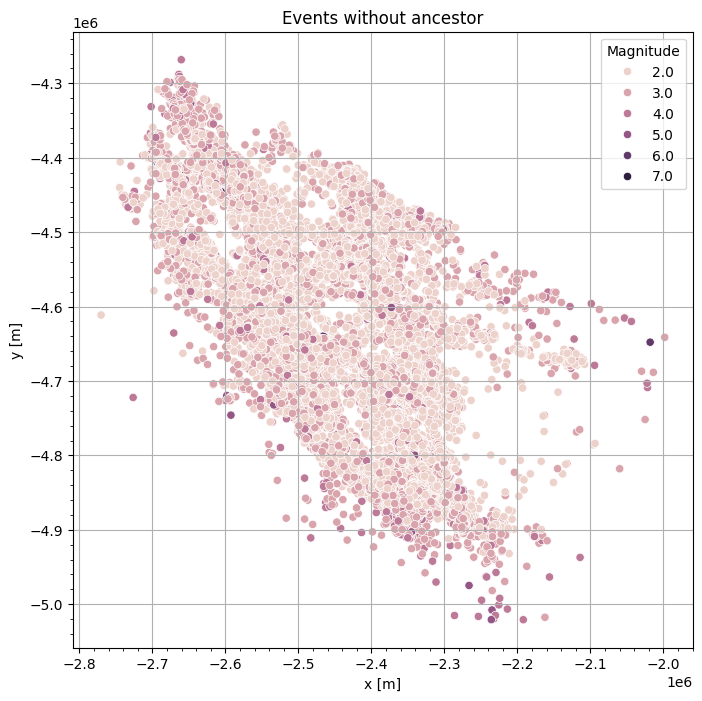

In [89]:
#plotting all the events without ancestor based on the magnitude

mod_dfnoancestor = df.copy()
mod_dfnoancestor = mod_dfnoancestor[mod_dfnoancestor["Prev event"] == -1]
mod_dfnoancestor["Magnitude"] = mod_dfnoancestor["Magnitude"].round()

fig_noanc, axs_noanc = plt.subplots(1, 1, figsize=(8, 8))

sns.scatterplot(data=mod_dfnoancestor, x="x [m]", y="y [m]", hue="Magnitude", ax = axs_noanc)

axs_noanc.grid()
axs_noanc.xaxis.set_major_locator(MultipleLocator(0.1e6))
axs_noanc.xaxis.set_minor_locator(AutoMinorLocator(5))
axs_noanc.yaxis.set_major_locator(MultipleLocator(0.1e6))
axs_noanc.yaxis.set_minor_locator(AutoMinorLocator(5))
axs_noanc.set_title("Events without ancestor")
axs_noanc.set_xlabel('x [m]')
axs_noanc.set_ylabel('y [m]')


From the graph one can observe that the uncorrelated events, i.e the ones with "prev index" = -1, are the most frequent and they are broadly distributed in space.

The indeces of the event that have the highest number of "child" events are: 39805, 75422, 100065, 22089, 39859, 0, 58367, 14073, 105946.

We choosed the radii to visualize and compare the distribution of earthquakes in spaces. The are equal for all the different group, so that the comparison is meaningfull.

For this part the radii chosen are: **5000, 10000, 15000, 20000** meters.

Text(-2349089, -4801702, 'Starting event')

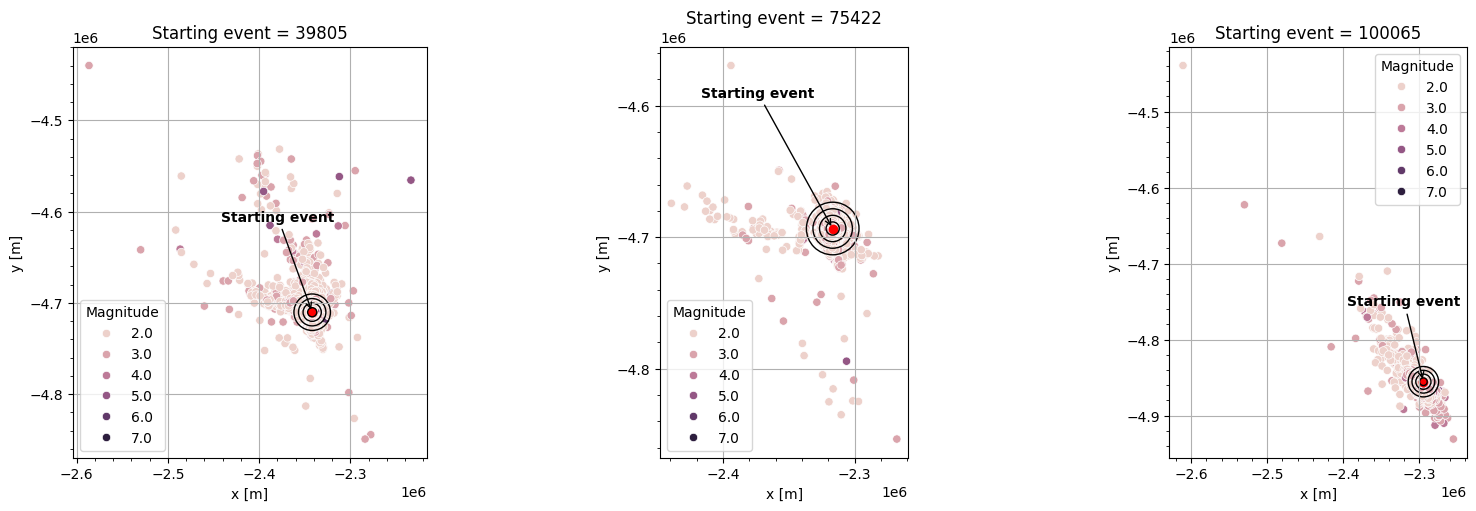

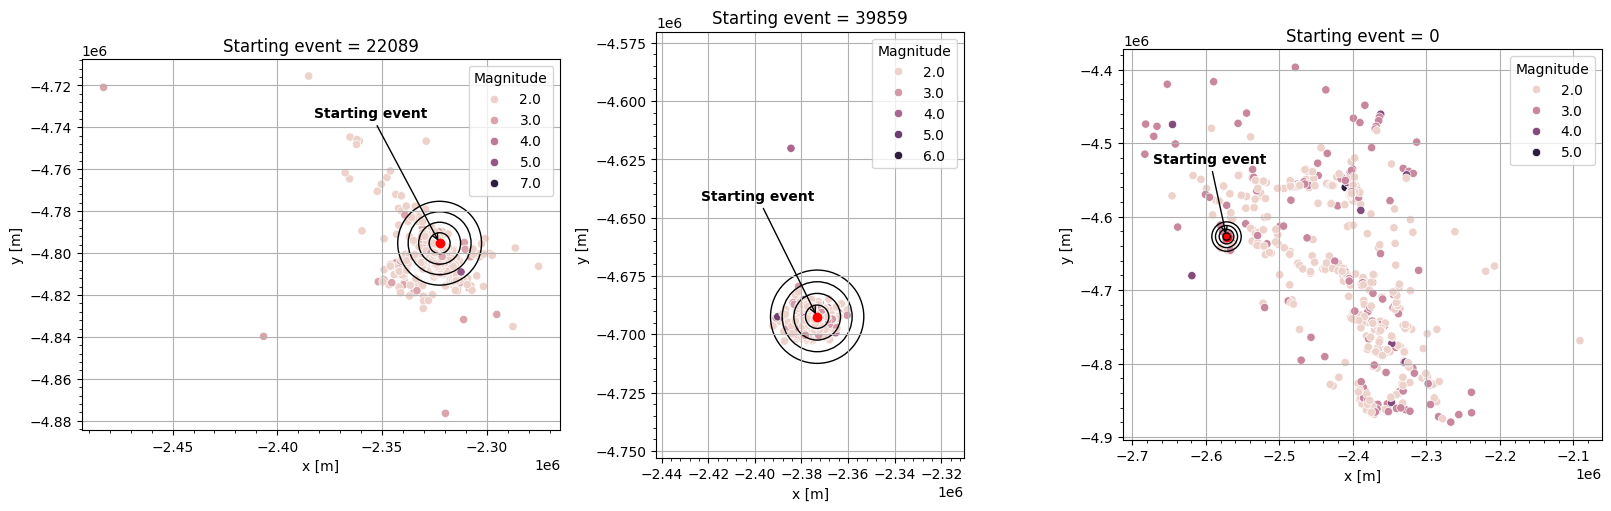

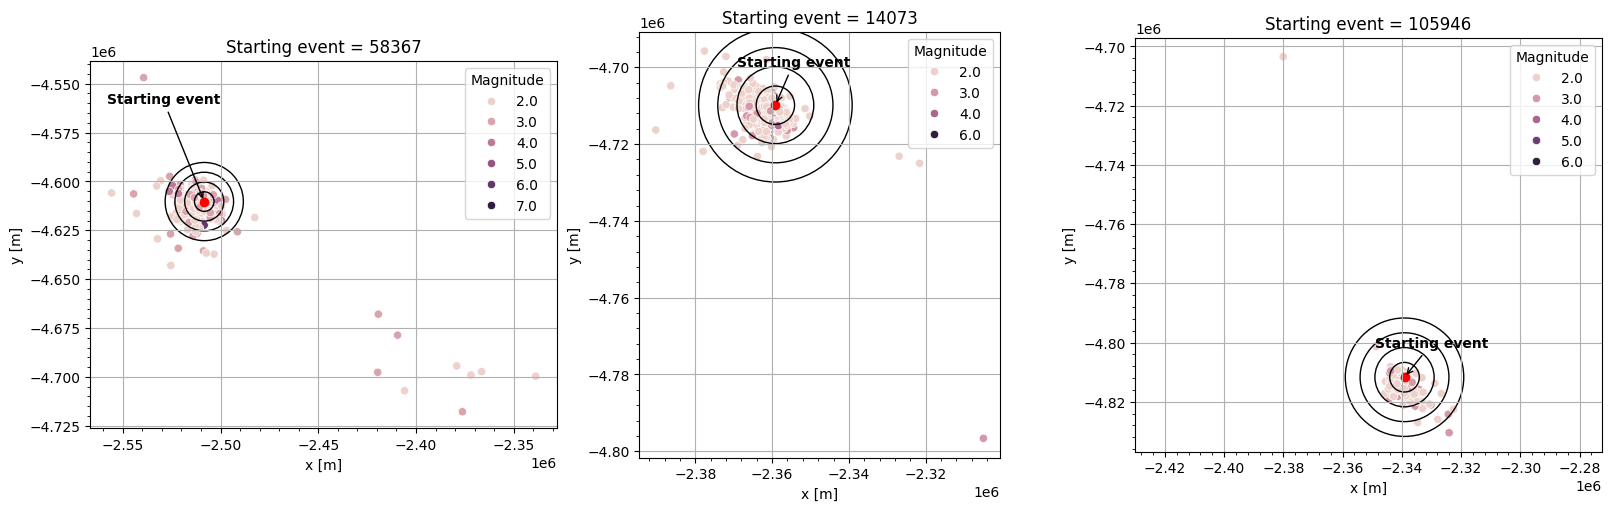

In [90]:
#radius in [m]
r = [5000, 10000, 15000, 20000]

fig_preevent1, axs_prevevent1 = plt.subplots(1, 3, figsize=(16, 5), layout="constrained")

df_events = dfc.copy()

#prev event = 39805
df_events_39805 = df_events[df_events["Prev event"] == 39805]
df_events_39805 = pd.concat([ df_events[df_events["Event"] == 39805] , df_events[df_events["Prev event"] == 39805]])
df_events_39805["r"] = np.sqrt(df_events_39805['x [m]']**2 + df_events_39805['y [m]']**2 + df_events_39805['z [m]']**2 )
df_events_39805["r"] = abs(df_events_39805["r"] - df_events_39805.iloc[0, 7])

#rounding the magnitude
df_events_39805["Magnitude"] = df_events_39805["Magnitude"].round()
sns.scatterplot(data=df_events_39805, x="x [m]", y="y [m]", hue="Magnitude", ax = axs_prevevent1[0])

axs_prevevent1[0].scatter(df_events_39805.iloc[0, 4], df_events_39805.iloc[0, 5], c='red')

axs_prevevent1[0].grid()
axs_prevevent1[0].xaxis.set_major_locator(MultipleLocator(0.1e6))
axs_prevevent1[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent1[0].yaxis.set_major_locator(MultipleLocator(0.1e6))
axs_prevevent1[0].yaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent1[0].set_title("Starting event = 39805")
axs_prevevent1[0].set_xlabel('x [m]')
axs_prevevent1[0].set_ylabel('y [m]')

for ri in r:
    Drawing_colored_circle = plt.Circle(( df_events_39805.iloc[0, 4] , df_events_39805.iloc[0, 5] ), ri, fill = False)
    axs_prevevent1[0].set_aspect( 1 )
    axs_prevevent1[0].add_artist( Drawing_colored_circle )

axs_prevevent1[0].annotate('Starting event', xy=(df_events_39805.iloc[0, 4], df_events_39805.iloc[0, 5]), xycoords='data',
            xytext=(df_events_39805.iloc[0, 4] - 100000, df_events_39805.iloc[0, 5] + 100000), textcoords='data',
            weight='bold', color="black",
            arrowprops=dict(arrowstyle='->',
                            connectionstyle="arc3",
                            color="black"))

#prev event = 75422
df_events_75422 = dfc.copy()

df_events_75422 = df_events[df_events["Prev event"] == 75422]
df_events_75422 = pd.concat([ df_events[df_events["Event"] == 75422] , df_events[df_events["Prev event"] == 75422]])
df_events_75422["r"] = np.sqrt(df_events_75422['x [m]']**2 + df_events_75422['y [m]']**2 + df_events_75422['z [m]']**2 )
df_events_75422["r"] = abs(df_events_75422["r"] - df_events_75422.iloc[0, 7])

#rounding the magnitude
df_events_75422["Magnitude"] = df_events_75422["Magnitude"].round()

sns.scatterplot(data=df_events_75422, x="x [m]", y="y [m]", hue="Magnitude", ax = axs_prevevent1[1])

axs_prevevent1[1].scatter(df_events_75422.iloc[0, 4], df_events_75422.iloc[0, 5], c='red')

axs_prevevent1[1].grid()
axs_prevevent1[1].xaxis.set_major_locator(MultipleLocator(0.1e6))
axs_prevevent1[1].xaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent1[1].yaxis.set_major_locator(MultipleLocator(0.1e6))
axs_prevevent1[1].yaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent1[1].set_title("Starting event = 75422")
axs_prevevent1[1].set_xlabel('x [m]')
axs_prevevent1[1].set_ylabel('y [m]')


for ri in r:
    Drawing_colored_circle = plt.Circle(( df_events_75422.iloc[0, 4] , df_events_75422.iloc[0, 5] ), ri, fill = False)
    axs_prevevent1[1].set_aspect( 1 )
    axs_prevevent1[1].add_artist( Drawing_colored_circle )

axs_prevevent1[1].annotate('Starting event', xy=(df_events_75422.iloc[0, 4], df_events_75422.iloc[0, 5]), xycoords='data',
            xytext=(df_events_75422.iloc[0, 4] - 100000, df_events_75422.iloc[0, 5] + 100000), textcoords='data',
            weight='bold', color="black",
            arrowprops=dict(arrowstyle='->',
                            connectionstyle="arc3",
                            color="black"))


#prev event = 100065
df_events_100065 = dfc.copy()

df_events_100065 = df_events[df_events["Prev event"] == 100065]
df_events_100065 = pd.concat([ df_events[df_events["Event"] == 100065] , df_events[df_events["Prev event"] == 100065]])
df_events_100065["r"] = np.sqrt(df_events_100065['x [m]']**2 + df_events_100065['y [m]']**2 + df_events_100065['z [m]']**2 )
df_events_100065["r"] = abs(df_events_100065["r"] - df_events_100065.iloc[0, 7])

#rounding the magnitude
df_events_100065["Magnitude"] = df_events_100065["Magnitude"].round()

sns.scatterplot(data=df_events_100065, x="x [m]", y="y [m]", hue="Magnitude", ax = axs_prevevent1[2])

axs_prevevent1[2].scatter(df_events_100065.iloc[0, 4], df_events_100065.iloc[0, 5], c='red')

axs_prevevent1[2].grid()
axs_prevevent1[2].xaxis.set_major_locator(MultipleLocator(0.1e6))
axs_prevevent1[2].xaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent1[2].yaxis.set_major_locator(MultipleLocator(0.1e6))
axs_prevevent1[2].yaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent1[2].set_title("Starting event = 100065")
axs_prevevent1[2].set_xlabel('x [m]')
axs_prevevent1[2].set_ylabel('y [m]')


for ri in r:
    Drawing_colored_circle = plt.Circle(( df_events_100065.iloc[0, 4] , df_events_100065.iloc[0, 5] ), ri, fill = False)
    axs_prevevent1[2].set_aspect( 1 )
    axs_prevevent1[2].add_artist( Drawing_colored_circle )

axs_prevevent1[2].annotate('Starting event', xy=(df_events_100065.iloc[0, 4], df_events_100065.iloc[0, 5]), xycoords='data',
            xytext=(df_events_100065.iloc[0, 4] - 100000, df_events_100065.iloc[0, 5] + 100000), textcoords='data',
            weight='bold', color="black",
            arrowprops=dict(arrowstyle='->',
                            connectionstyle="arc3",
                            color="black"))


fig_preevent2, axs_prevevent2 = plt.subplots(1, 3, figsize=(16, 5), layout="constrained")

#prev event = 22089
df_events_22089 = dfc.copy()

df_events_22089 = df_events[df_events["Prev event"] == 22089]
df_events_22089 = pd.concat([ df_events[df_events["Event"] == 22089] , df_events[df_events["Prev event"] == 22089]])
df_events_22089["r"] = np.sqrt(df_events_22089['x [m]']**2 + df_events_22089['y [m]']**2 + df_events_22089['z [m]']**2 )
df_events_22089["r"] = abs(df_events_22089["r"] - df_events_22089.iloc[0, 7])

#rounding the magnitude
df_events_22089["Magnitude"] = df_events_22089["Magnitude"].round()

sns.scatterplot(data=df_events_22089, x="x [m]", y="y [m]", hue="Magnitude", ax = axs_prevevent2[0])

axs_prevevent2[0].scatter(df_events_22089.iloc[0, 4], df_events_22089.iloc[0, 5], c='red')

axs_prevevent2[0].grid()
axs_prevevent2[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent2[0].yaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent2[0].set_title("Starting event = 22089")
axs_prevevent2[0].set_xlabel('x [m]')
axs_prevevent2[0].set_ylabel('y [m]')


for ri in r:
    Drawing_colored_circle = plt.Circle(( df_events_22089.iloc[0, 4] , df_events_22089.iloc[0, 5] ), ri, fill = False)
    axs_prevevent2[0].set_aspect( 1 )
    axs_prevevent2[0].add_artist( Drawing_colored_circle )

axs_prevevent2[0].annotate('Starting event', xy=(df_events_22089.iloc[0, 4], df_events_22089.iloc[0, 5]), xycoords='data',
            xytext=(df_events_22089.iloc[0, 4] - 60000, df_events_22089.iloc[0, 5] + 60000), textcoords='data',
            weight='bold', color="black",
            arrowprops=dict(arrowstyle='->',
                            connectionstyle="arc3",
                            color="black"))

#prev event = 39859
df_events_39859 = dfc.copy()

df_events_39859 = df_events[df_events["Prev event"] == 39859]
df_events_39859 = pd.concat([ df_events[df_events["Event"] == 39859] , df_events[df_events["Prev event"] == 39859]])
df_events_39859["r"] = np.sqrt(df_events_39859['x [m]']**2 + df_events_39859['y [m]']**2 + df_events_39859['z [m]']**2 )
df_events_39859["r"] = abs(df_events_39859["r"] - df_events_39859.iloc[0, 7])

#rounding the magnitude
df_events_39859["Magnitude"] = df_events_39859["Magnitude"].round()

sns.scatterplot(data=df_events_39859, x="x [m]", y="y [m]", hue="Magnitude", ax = axs_prevevent2[1])

axs_prevevent2[1].scatter(df_events_39859.iloc[0, 4], df_events_39859.iloc[0, 5], c='red')

axs_prevevent2[1].grid()
axs_prevevent2[1].set_xlim([df_events_39859["x [m]"].min() - 50000, df_events_39859["x [m]"].max()+50000] )
axs_prevevent2[1].set_ylim([df_events_39859["y [m]"].min() - 50000, df_events_39859["y [m]"].max()+50000] )

axs_prevevent2[1].xaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent2[1].yaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent2[1].set_title("Starting event = 39859")
axs_prevevent2[1].set_xlabel('x [m]')
axs_prevevent2[1].set_ylabel('y [m]')


for ri in r:
    Drawing_colored_circle = plt.Circle(( df_events_39859.iloc[0, 4] , df_events_39859.iloc[0, 5] ), ri, fill = False)
    axs_prevevent2[1].set_aspect( 1 )
    axs_prevevent2[1].add_artist( Drawing_colored_circle )

axs_prevevent2[1].annotate('Starting event', xy=(df_events_39859.iloc[0, 4], df_events_39859.iloc[0, 5]), xycoords='data',
            xytext=(df_events_39859.iloc[0, 4] - 50000, df_events_39859.iloc[0, 5] + 50000), textcoords='data',
            weight='bold', color="black",
            arrowprops=dict(arrowstyle='->',
                            connectionstyle="arc3",
                            color="black"))


#prev event = 0
df_events_0 = dfc.copy()

df_events_0 = df_events[df_events["Prev event"] == 0]
df_events_0 = pd.concat([ df_events[df_events["Event"] == 0] , df_events[df_events["Prev event"] == 0]])
df_events_0["r"] = np.sqrt(df_events_0['x [m]']**2 + df_events_0['y [m]']**2 + df_events_0['z [m]']**2 )
df_events_0["r"] = abs(df_events_0["r"] - df_events_0.iloc[0, 7])

#rounding the magnitude
df_events_0["Magnitude"] = df_events_0["Magnitude"].round()

sns.scatterplot(data=df_events_0, x="x [m]", y="y [m]", hue="Magnitude", ax = axs_prevevent2[2])

axs_prevevent2[2].scatter(df_events_0.iloc[0, 4], df_events_0.iloc[0, 5], c='red')

axs_prevevent2[2].grid()
axs_prevevent2[2].xaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent2[2].yaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent2[2].set_title("Starting event = 0")
axs_prevevent2[2].set_xlabel('x [m]')
axs_prevevent2[2].set_ylabel('y [m]')


for ri in r:
    Drawing_colored_circle = plt.Circle(( df_events_0.iloc[0, 4] , df_events_0.iloc[0, 5] ), ri, fill = False)
    axs_prevevent2[2].set_aspect( 1 )
    axs_prevevent2[2].add_artist( Drawing_colored_circle )

axs_prevevent2[2].annotate('Starting event', xy=(df_events_0.iloc[0, 4], df_events_0.iloc[0, 5]), xycoords='data',
            xytext=(df_events_0.iloc[0, 4] - 100000, df_events_0.iloc[0, 5] + 100000), textcoords='data',
            weight='bold', color="black",
            arrowprops=dict(arrowstyle='->',
                            connectionstyle="arc3",
                            color="black"))

#plt.show()


fig_preevent3, axs_prevevent3 = plt.subplots(1, 3, figsize=(16, 5), layout="constrained")

#prev event = 58367
df_events_58367 = dfc.copy()

df_events_58367 = df_events[df_events["Prev event"] == 58367]
df_events_58367 = pd.concat([ df_events[df_events["Event"] == 58367] , df_events[df_events["Prev event"] == 58367]])
df_events_58367["r"] = np.sqrt(df_events_58367['x [m]']**2 + df_events_58367['y [m]']**2 + df_events_58367['z [m]']**2 )
df_events_58367["r"] = abs(df_events_58367["r"] - df_events_58367.iloc[0, 7])

#rounding the magnitude
df_events_58367["Magnitude"] = df_events_58367["Magnitude"].round()

sns.scatterplot(data=df_events_58367, x="x [m]", y="y [m]", hue="Magnitude", ax = axs_prevevent3[0])

axs_prevevent3[0].scatter(df_events_58367.iloc[0, 4], df_events_58367.iloc[0, 5], c='red')

axs_prevevent3[0].grid()
axs_prevevent3[0].xaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent3[0].yaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent3[0].set_title("Starting event = 58367")
axs_prevevent3[0].set_xlabel('x [m]')
axs_prevevent3[0].set_ylabel('y [m]')


for ri in r:
    Drawing_colored_circle = plt.Circle(( df_events_58367.iloc[0, 4] , df_events_58367.iloc[0, 5] ), ri, fill = False)
    axs_prevevent3[0].set_aspect( 1 )
    axs_prevevent3[0].add_artist( Drawing_colored_circle )

axs_prevevent3[0].annotate('Starting event', xy=(df_events_58367.iloc[0, 4], df_events_58367.iloc[0, 5]), xycoords='data',
            xytext=(df_events_58367.iloc[0, 4] - 50000, df_events_58367.iloc[0, 5] + 50000), textcoords='data',
            weight='bold', color="black",
            arrowprops=dict(arrowstyle='->',
                            connectionstyle="arc3",
                            color="black"))


#prev event = 14073
df_events_14073 = dfc.copy()

df_events_14073 = df_events[df_events["Prev event"] == 14073]
df_events_14073 = pd.concat([ df_events[df_events["Event"] == 14073] , df_events[df_events["Prev event"] == 14073]])
df_events_14073["r"] = np.sqrt(df_events_14073['x [m]']**2 + df_events_14073['y [m]']**2 + df_events_14073['z [m]']**2 )
df_events_14073["r"] = abs(df_events_14073["r"] - df_events_14073.iloc[0, 7])

#rounding the magnitude
df_events_14073["Magnitude"] = df_events_14073["Magnitude"].round()

sns.scatterplot(data=df_events_14073, x="x [m]", y="y [m]", hue="Magnitude", ax = axs_prevevent3[1])

axs_prevevent3[1].scatter(df_events_14073.iloc[0, 4], df_events_14073.iloc[0, 5], c='red')

axs_prevevent3[1].grid()
axs_prevevent3[1].xaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent3[1].yaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent3[1].set_title("Starting event = 14073")
axs_prevevent3[1].set_xlabel('x [m]')
axs_prevevent3[1].set_ylabel('y [m]')


for ri in r:
    Drawing_colored_circle = plt.Circle(( df_events_14073.iloc[0, 4] , df_events_14073.iloc[0, 5] ), ri, fill = False)
    axs_prevevent3[1].set_aspect( 1 )
    axs_prevevent3[1].add_artist( Drawing_colored_circle )

axs_prevevent3[1].annotate('Starting event', xy=(df_events_14073.iloc[0, 4], df_events_14073.iloc[0, 5]), xycoords='data',
            xytext=(df_events_14073.iloc[0, 4] - 10000, df_events_14073.iloc[0, 5] + 10000), textcoords='data',
            weight='bold', color="black",
            arrowprops=dict(arrowstyle='->',
                            connectionstyle="arc3",
                            color="black"))

#prev event = 105946
df_events_105946 = dfc.copy()

df_events_105946 = df_events[df_events["Prev event"] == 105946]
df_events_105946 = pd.concat([ df_events[df_events["Event"] == 105946] , df_events[df_events["Prev event"] == 105946]])
df_events_105946["r"] = np.sqrt(df_events_105946['x [m]']**2 + df_events_105946['y [m]']**2 + df_events_105946['z [m]']**2 )
df_events_105946["r"] = abs(df_events_105946["r"] - df_events_105946.iloc[0, 7])

#rounding the magnitude
df_events_105946["Magnitude"] = df_events_105946["Magnitude"].round()

sns.scatterplot(data=df_events_105946, x="x [m]", y="y [m]", hue="Magnitude", ax = axs_prevevent3[2])

axs_prevevent3[2].scatter(df_events_105946.iloc[0, 4], df_events_105946.iloc[0, 5], c='red')

axs_prevevent3[2].grid()
axs_prevevent3[2].set_xlim([df_events_105946["x [m]"].min() - 50000, df_events_105946["x [m]"].max()+50000] )
axs_prevevent3[2].xaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent3[2].yaxis.set_minor_locator(AutoMinorLocator(5))
axs_prevevent3[2].set_title("Starting event = 105946")
axs_prevevent3[2].set_xlabel('x [m]')
axs_prevevent3[2].set_ylabel('y [m]')


for ri in r:
    Drawing_colored_circle = plt.Circle(( df_events_105946.iloc[0, 4] , df_events_105946.iloc[0, 5] ), ri, fill = False)
    axs_prevevent3[2].set_aspect( 1 )
    axs_prevevent3[2].add_artist( Drawing_colored_circle )

axs_prevevent3[2].annotate('Starting event', xy=(df_events_105946.iloc[0, 4], df_events_105946.iloc[0, 5]), xycoords='data',
            xytext=(df_events_105946.iloc[0, 4] - 10000, df_events_105946.iloc[0, 5] + 10000), textcoords='data',
            weight='bold', color="black",
            arrowprops=dict(arrowstyle='->',
                            connectionstyle="arc3",
                            color="black"))





## 4.2) Distribution $P_{m,R}(t)$ of the chosen group for i-th group
It has been represented the event number 39805, since it is the earthquake with most children, so we can appreciate a meaningful distribution.

First it has been visualized the log-log scale in **green**, for any combinations of magnitude and radius. As expected, one can observe the linear decay of the probability, according to the power-law function.

Moreover, for a given magnitude m and for increasing values of raddi the probabilty of finding an event is more probable.
Instaed, fixing the radius, for increasing value of magnitude, the probability of finding events decreases very rapidly.

On the second part, in **blue**, the same analysis is made but the used scale is linear.






Give me a number from 1 to 8 (or 0 if you want to plot uncorrelated events without ancestors): 1


<ipython-input-95-6fd176dedb41>:75: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=mod_dfr_m, ax=axs2[r, m], x="Waiting Times [s]", linewidth=4, color='blue')


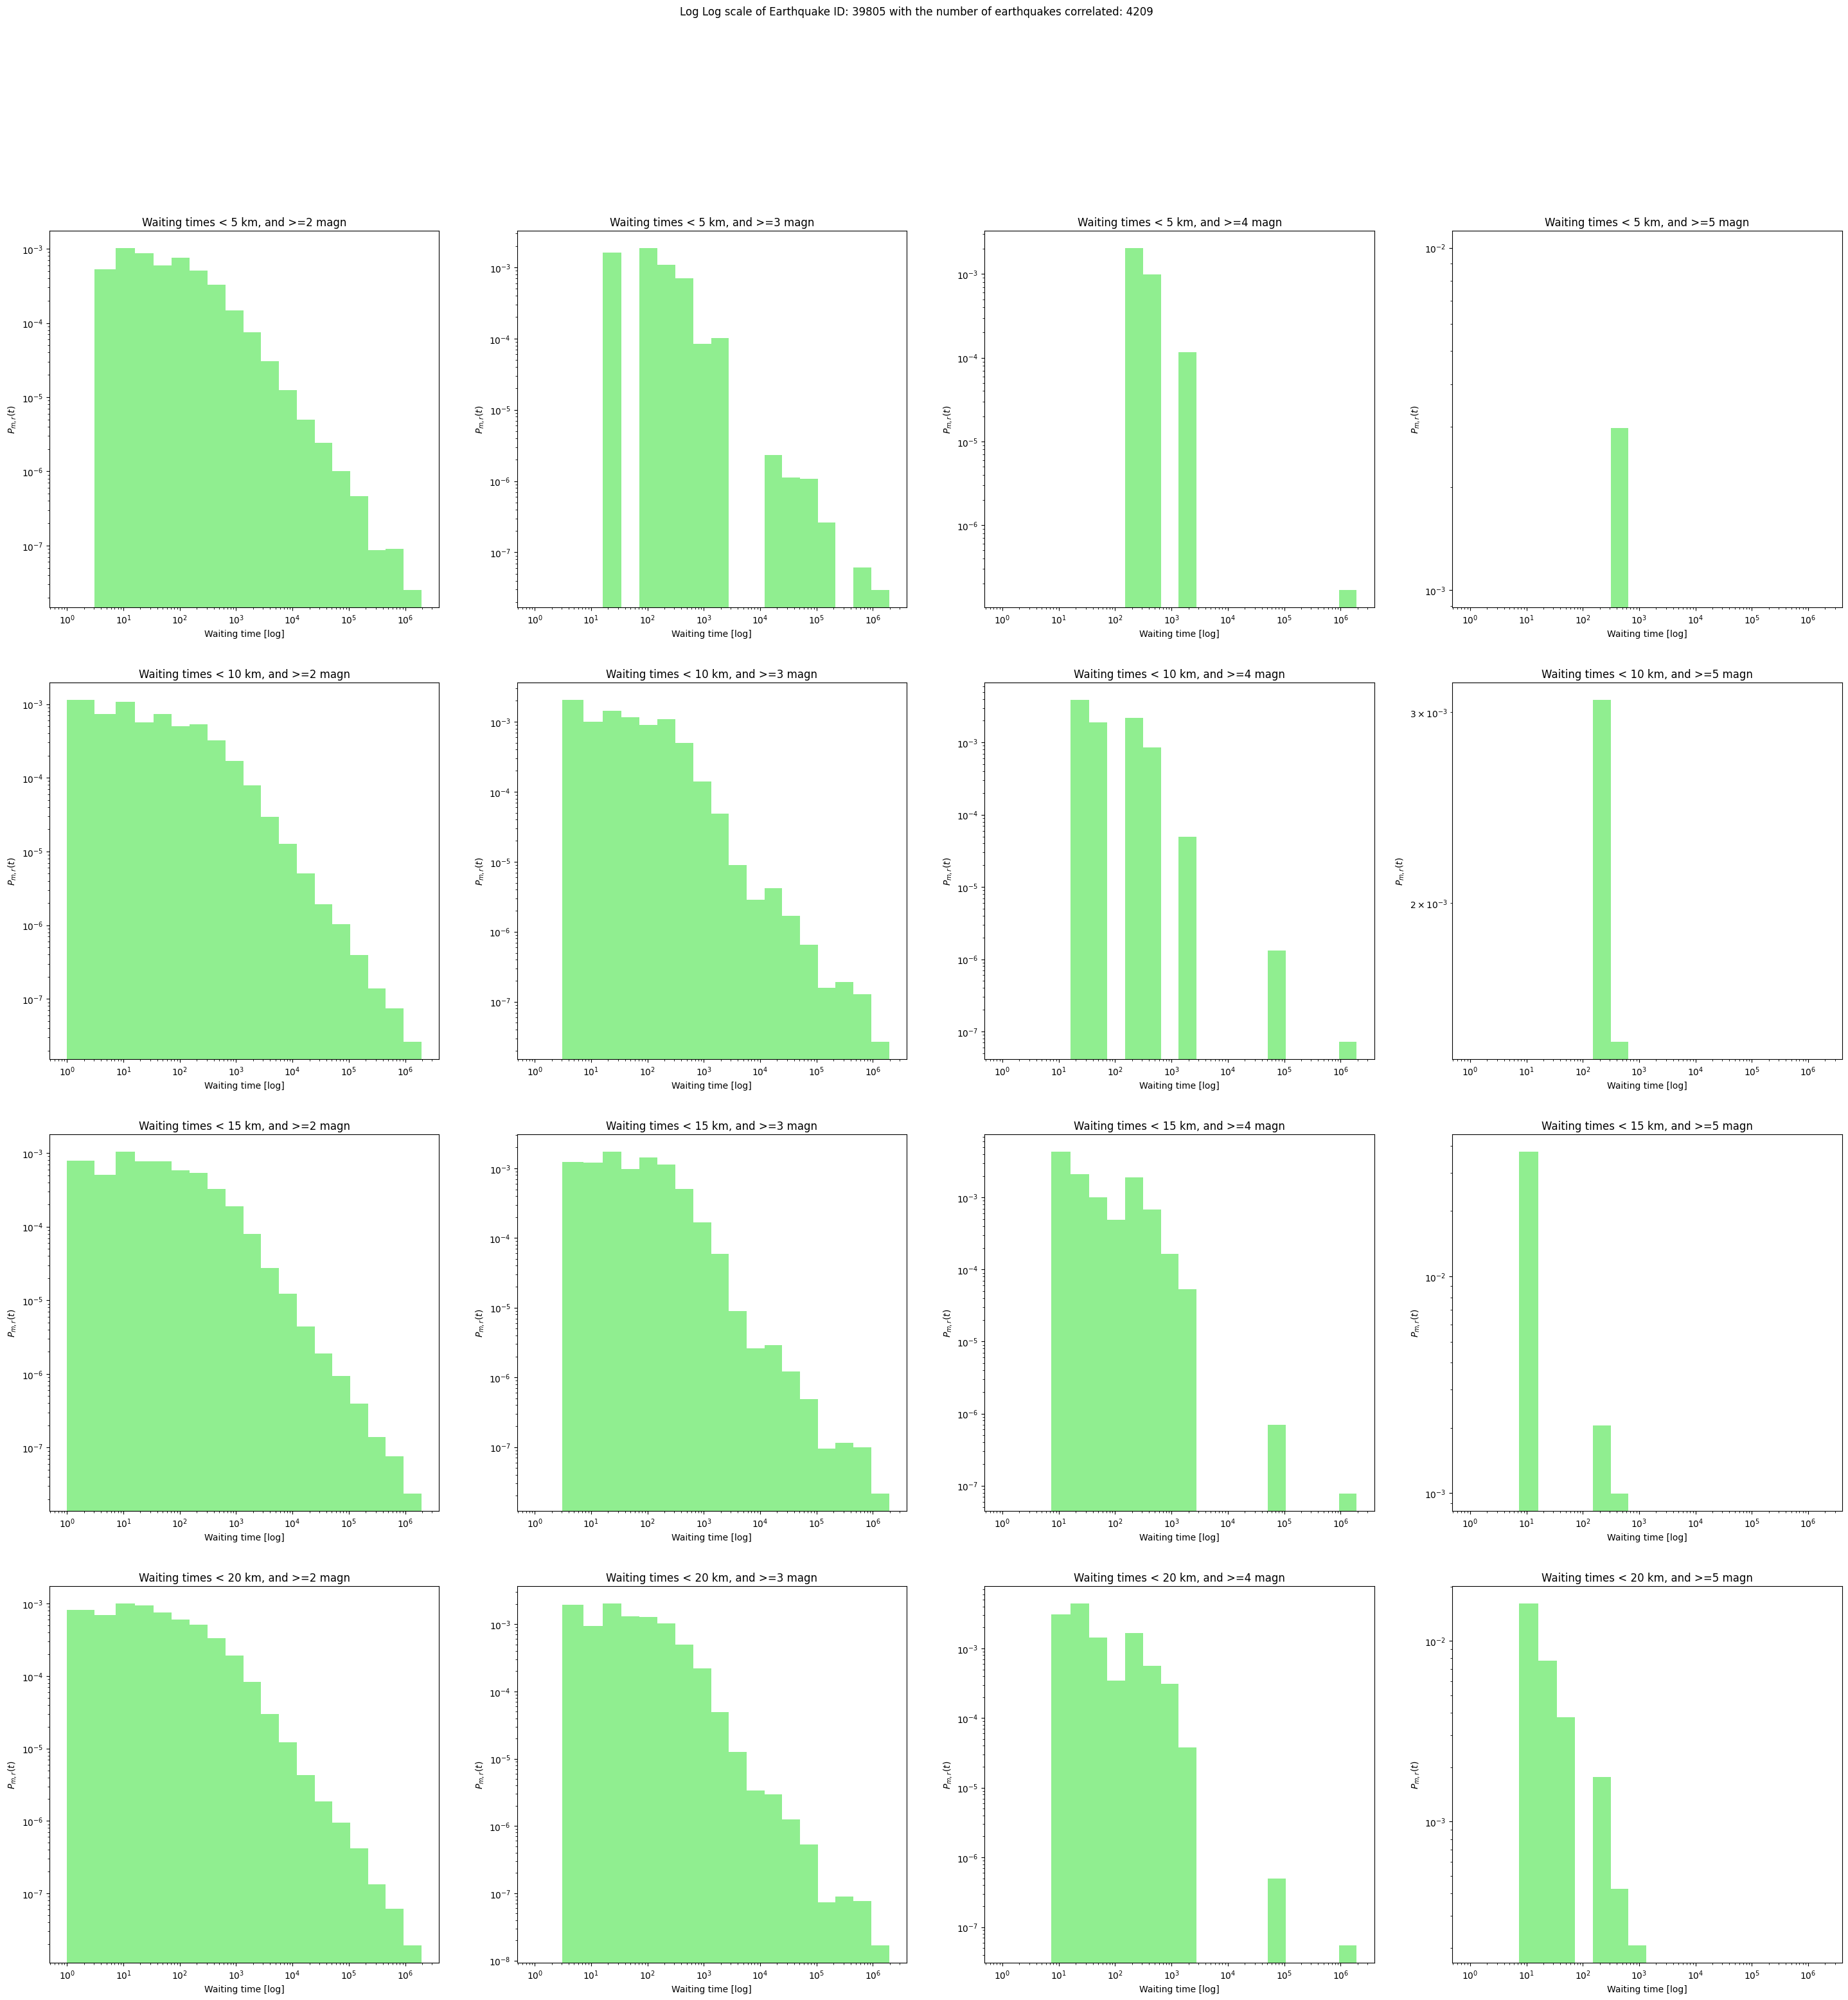

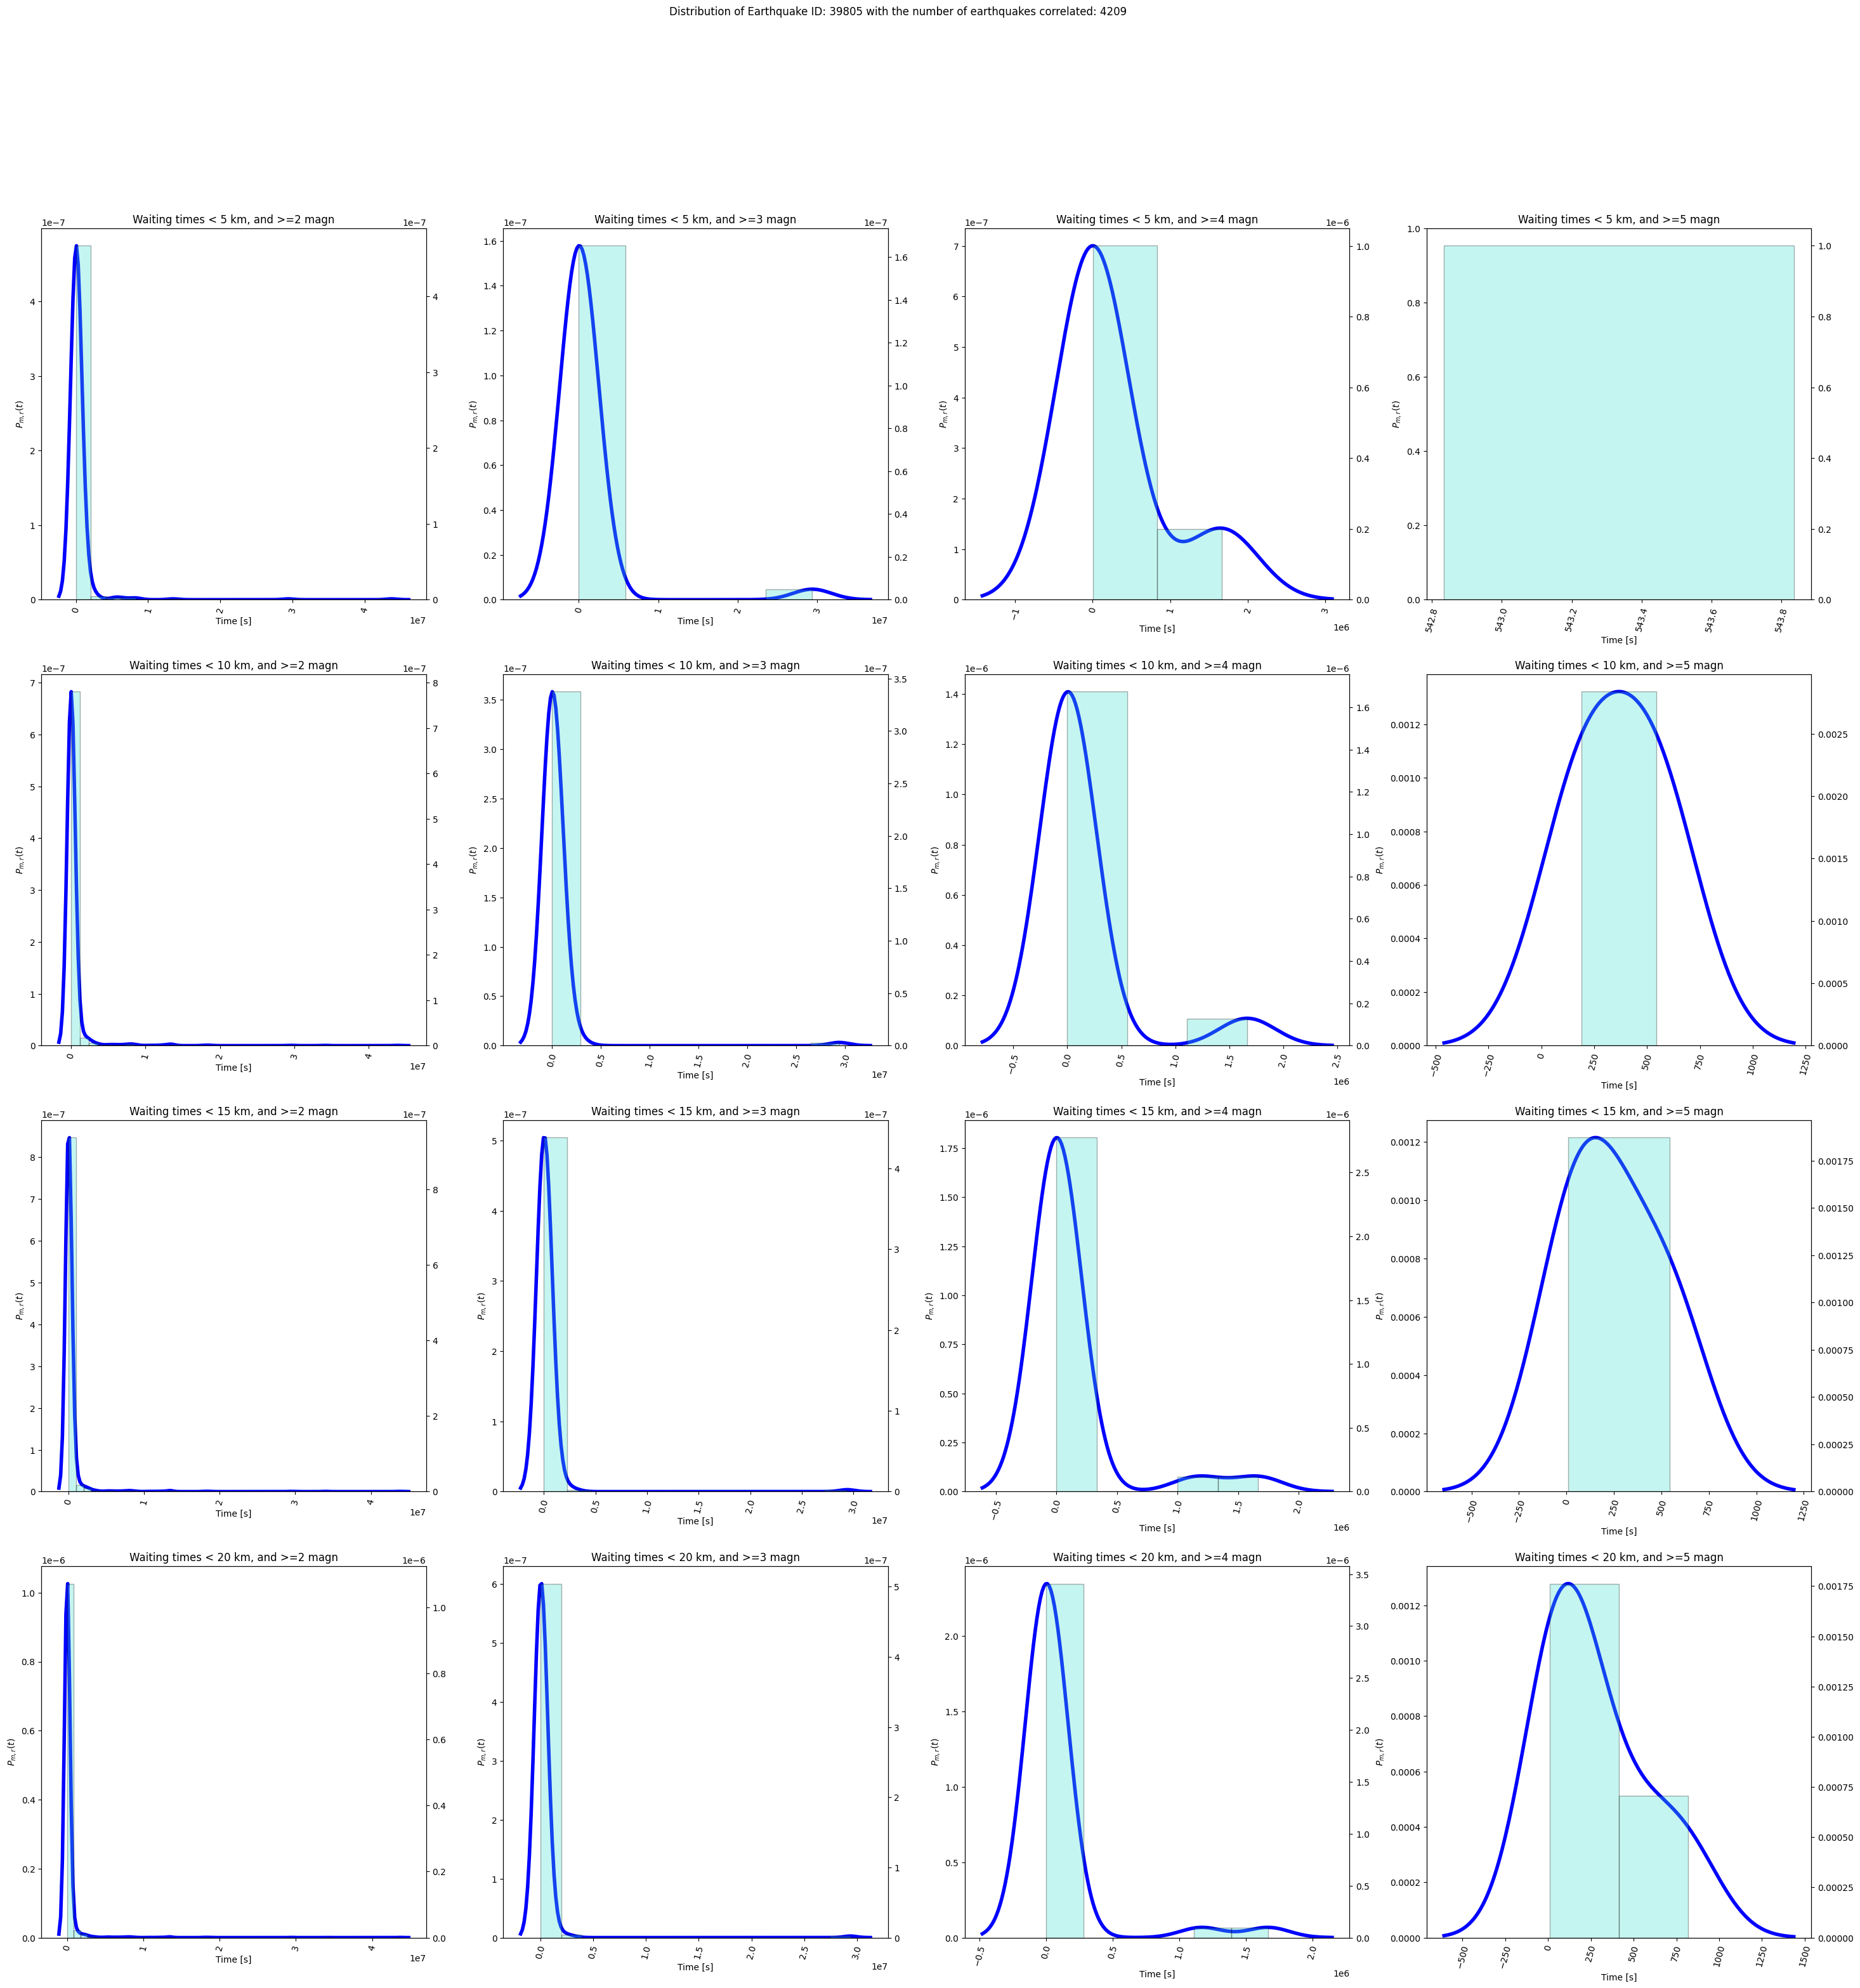

In [95]:
mod_dfr = df.copy()
# dictionary containing the ID of the earthquakes which have generated multiple related earthquakes
d_distrib = {-1: 38744, 39805: 4209, 75422: 3318, 100065: 3198, 22089: 1347, 39859: 779, 58367: 499, 14073: 465, 105946: 368}

# choose one of them, with the number 0, you choose the uncorrelated earthquakes without ancestors
n_choosen = int(input('Give me a number from 1 to 8 (or 0 if you want to plot uncorrelated events without ancestors): '))
d_key = list(d_distrib.keys())
l_distrib = [-1,39805, 75422, 100065, 22089, 39859, 58367, 14073, 105946]


if n_choosen > 0:
  # creation of a dataframe containing the information of the ancestor earthquake
  m1 = mod_dfr[mod_dfr['Event'] == l_distrib[n_choosen]]
  # creation of a dataframe containing the information of the correlated earthquakes with the ancestor one
  m2 = mod_dfr[mod_dfr['Prev event'] == l_distrib[n_choosen]]
  mod_dfr = pd.concat([m1,m2])
else:
  # creation of a dataframe containing the information of the uncorrelated earthquakes
  mod_dfr = mod_dfr[mod_dfr['Prev event'] == l_distrib[n_choosen]]

# create columns whose content is the distance in x, y, z between the generating earthquake and the n-th correlated earthquake
mod_dfr['diff_x'] = abs(mod_dfr['x [m]'] - mod_dfr['x [m]'].iloc[0])
mod_dfr['diff_y'] = abs(mod_dfr['y [m]'] - mod_dfr['y [m]'].iloc[0])
mod_dfr['diff_z'] = abs(mod_dfr['z [m]'] - mod_dfr['z [m]'].iloc[0])

# compute Euclidean distance in km
mod_dfr['r'] = np.sqrt(mod_dfr['diff_x']**2 + mod_dfr['diff_y']**2 + mod_dfr['diff_z']**2 )/1000
#mod_dfr['Waiting Times [s]'] = np.abs(mod_dfr['Time [s]'] - mod_dfr['Time [s]'].iloc[0])

# compute the waiting times between the events
mod_dfr['Waiting Times [s]'] = np.abs(mod_dfr['Time [s]'].diff())
mod_dfr = mod_dfr.dropna()

# list with different radius in km
radius = [5, 10, 15, 20]

# list with different magnitude in km
magnitude = [2,3,4,5]

# plot of Log Log scale of the choosen ancestor Earthquake with the number of correlated earthquakes
fig1, axs1 = plt.subplots(4, 4, figsize=(36, 35))
fig1.suptitle('Log Log scale of Earthquake ID: ' + str(d_key[n_choosen]) + ' with the number of earthquakes correlated: ' +  str(d_distrib[d_key[n_choosen]]))

# plot of Distribution of the choosen ancestor Earthquake with the number of correlated earthquakes
fig2, axs2 = plt.subplots(4, 4, figsize=(36, 35))
fig2.suptitle('Distribution of Earthquake ID: ' + str(d_key[n_choosen]) + ' with the number of earthquakes correlated: ' +  str(d_distrib[d_key[n_choosen]]))

# Start main cycle with all the combinations between the different radius and magnitude
for r in range(len(radius)):
  # filtered the dataframe with a certain radius
  mod_dfr_R = mod_dfr[mod_dfr['r'] < radius[r]]

  # filtered the dataframe with a certain magnitude
  for m in range(len(magnitude)):
    mod_dfr_m = mod_dfr_R[mod_dfr_R['Magnitude'] >= magnitude[m]]

    # if the dataframe hasn't entry, don't plot it
    if(mod_dfr_m.shape[0] > 0):

      mod_dfr_m = mod_dfr_m[mod_dfr_m['Waiting Times [s]'] > 0]

      bins_2 = int(np.sqrt(mod_dfr_m.shape[0]))

      # plotting the log log scale
      num_bins2_log = np.logspace(0, 6, 20)
      x_bins2 = np.cumsum(num_bins2_log)
      counts_log, bin_edges_log, _ = axs1[r, m].hist(mod_dfr_m["Waiting Times [s]"], bins=x_bins2, color='lightgreen', density=True)
      axs1[r][m].set_title("Waiting times < " +str(radius[r]) + " km, and >=" +str(magnitude[m]) + " magn")
      axs1[r][m].set_xscale('log')
      axs1[r][m].set_yscale('log')
      axs1[r][m].set_ylabel('$P_{m,r}(t)$')
      axs1[r][m].set_xlabel('Waiting time [log]')

      # plotting the distribution with a KDE estimation
      sns.kdeplot(data=mod_dfr_m, ax=axs2[r, m], x="Waiting Times [s]", linewidth=4, color='blue')
      ax2 = axs2[r, m].twinx()
      counts, bin_edges, _ = ax2.hist(mod_dfr_m["Waiting Times [s]"], bins=bins_2, color='turquoise', edgecolor='black', density=True, alpha=0.3)
      axs2[r][m].set_title("Waiting times < " +str(radius[r]) + " km, and >=" +str(magnitude[m]) + " magn")
      axs2[r][m].set_xlabel('Time [s]')
      axs2[r][m].set_ylabel('$P_{m,r}(t)$')
      axs2[r][m].tick_params(axis='x', labelrotation = 75)

# End main cycle
